# Surrogate Modeling in context of MD-Simulations

Aiman Chbib, Thomas Reise Kato

In [2]:
import copy
import csv
import glob
import os

import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import spearmanr

import seaborn as sns

from sklearn.metrics import mean_absolute_error, pairwise_distances, root_mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

## Einführung

In diesem Notebook beschäftigen wir uns mir der Entwicklung eines Sirrogate Models zur Vorhersage physikalischer Größen. Ziel ist es, ein datengetriebenes Regressionsmedell zu trainieren, das die Ergebnisse einer tueren Smulation approximiert und damit schnelle Vorhersagen ermöglicht.

### Motivation

Viele wissenschaftliche und technische Fragestellungen basieren auf numerischen Simulationen. Diese Simulationen liefern präzise Ergebnisse, sind jedoch häufig rechenintensiv und somit auch zeitaufwendig. In unserem Fall beträgt die Dauer eines Simulationspunktes im Schnitt zwei bis drei Stunden.

Ein Surrogate Model dient als efiziente Näherung dieser Simulation. Es lernt den Zusammenhang zwischen Eingangsparametern (Features) und Zielgrößen (Label) aus vorhandenen Simulationsdaten. Features sind unserem Fall die Lennard-Jones Potentiale (SigC, SigH, EpsC, EpsH). Diese beschreiben die Anziehungskräfte zwischen Partikeln. Unser Label ist die Dichte. Nach dem Training des Models kann es neue Vorhersagen in Sekundenbruchteilen liefern.

### Problemstellung

Gegeben ist ein Datensatz, bestehend aus 4 Samples, aus Simulationen:

- Input: Lennard-Jones Parameter

- Output: Dichte (Zielgröße)

Das Problem lässt sich als folgendes beschreiben:

$$
f_\theta(x) \approx y
$$

Dabei gilt:

- $x$: Eingangsvektor

- $y$: Simulierte Zielgröße

- $f_\theta$: Parametrisches Modell

- $\theta$: Zu lernender Parameter

Das Ziel ist es, die Modellparameter so zu bestimmen, dass der Fehler zwischen Vorhersage und Simulationswert minimiert wird.

### Bewertung des Modells

Zur Quantifizierurng der Modellgüte werden die beiden typischen Regressionsmetriken verwendet:

- RMSE (Root Mean Squared Error)

- MAE (Mean Absolute Error)

Diese messen die Abweichungen zwischen Modellvorhersage und Referenzsimulation.

### Ziele

Folgende Ziele werden verfolgt:

1. Säuberung & Explorative Analyse des Datensatzes

2. Implementierung Regressionsmodell

3. Training des Modells

4.  Bewertung der Modellleistung

## Helpers & Parameters

### Global Setting Parameters

In [3]:
SEED = 42
BATCH_SIZE = 16
NUM_EPOCHS = 400
PATIENCE = 40
MIN_DELTA = 1e-4
AL_ITER = NUM_EPOCHS
K = 30
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE = torch.device("mps" if torch.backends.mps.is_available() else DEVICE)

### Global best models

In [4]:
BEST_NN = None
BEST_AL_RANDOM = None
BEST_AL_BOUNDARY = None
BEST_AL_SPARSE = None
BEST_AL_ERROR_BASED = None
BEST_AL_QBC = None

### Save Parameters

In [5]:
LOSS_NN_TRAIN = []
LOSS_NN_VAL = []

RMSE_VAL_NN = []
MAE_VAL_NN = []
FEATURE_SCALER_NN = None
TARGET_SCALER_NN = None

RMSE_VAL_AL_RANDOM = []
MAE_VAL_AL_RANDOM = []
FEATURE_SCALER_AL_RANDOM = None
TARGET_SCALER_AL_RANDOM = None

RMSE_VAL_AL_BOUNDARY = []
MAE_VAL_AL_BOUNDARY = []
FEATURE_SCALER_AL_BOUNDARY = None
TARGET_SCALER_AL_BOUNDARY = None

RMSE_VAL_AL_SPARSE = []
MAE_VAL_AL_SPARSE = []
FEATURE_SCALER_AL_SPARSE = None
TARGET_SCALER_AL_SPARSE = None

RMSE_VAL_AL_ERROR_BASED = []
MAE_VAL_AL_ERROR_BASED = []
FEATURE_SCALER_AL_ERROR_BASED = None
TARGET_SCALER_AL_ERROR_BASED = None

RMSE_VAL_AL_QBC = []
MAE_VAL_AL_QBC = []
FEATURE_SCALER_AL_QBC = None
TARGET_SCALER_AL_QBC = None

In [70]:
RUN = "final"
SAVE_STEP = 5

DIR_MODEL_SAVE = "models"
DIR_SCALERS_SAVE = "scalers"
DIR_LOSS_SAVE = "loss"
PATH_NN = f"{RUN}/{DIR_MODEL_SAVE}/best_model_nn.pt"
PATH_AL_RANDOM = f"{RUN}/{DIR_MODEL_SAVE}/best_model_al_random_sampling.pt"
PATH_AL_BOUNDARY = f"{RUN}/{DIR_MODEL_SAVE}/best_model_al_boundary_sampling.pt"
PATH_AL_SPARSE = f"{RUN}/{DIR_MODEL_SAVE}/best_model_al_sparse_sampling.pt"
PATH_AL_ERROR_BASED = f"{RUN}/{DIR_MODEL_SAVE}/best_model_al_error_based_sampling.pt"
PATH_AL_QBC = f"{RUN}/{DIR_MODEL_SAVE}/best_model_al_qbc_sampling.pt"

PATH_FEATURE_SCALER_NN = f"{RUN}/{DIR_SCALERS_SAVE}/feature_scaler_nn.pkl"
PATH_TARGET_SCALER_NN = f"{RUN}/{DIR_SCALERS_SAVE}/target_scaler_nn.pkl"
PATH_FEATURE_SCALER_AL_RANDOM = f"{RUN}/{DIR_SCALERS_SAVE}/feature_scaler_al_random.pkl"
PATH_TARGET_SCALER_AL_RANDOM = f"{RUN}/{DIR_SCALERS_SAVE}/target_scaler_al_random.pkl"
PATH_FEATURE_SCALER_AL_BOUNDARY = f"{RUN}/{DIR_SCALERS_SAVE}/feature_scaler_al_boundary.pkl"
PATH_TARGET_SCALER_AL_BOUNDARY = f"{RUN}/{DIR_SCALERS_SAVE}/target_scaler_al_boundary.pkl"
PATH_FEATURE_SCALER_AL_SPARSE = f"{RUN}/{DIR_SCALERS_SAVE}/feature_scaler_al_sparse.pkl"
PATH_TARGET_SCALER_AL_SPARSE = f"{RUN}/{DIR_SCALERS_SAVE}/target_scaler_al_sparse.pkl"
PATH_FEATURE_SCALER_AL_ERROR_BASED = f"{RUN}/{DIR_SCALERS_SAVE}/feature_scaler_al_error_based.pkl"
PATH_TARGET_SCALER_AL_ERROR_BASED = f"{RUN}/{DIR_SCALERS_SAVE}/target_scaler_al_error_based.pkl"
PATH_FEATURE_SCALER_AL_QBC = f"{RUN}/{DIR_SCALERS_SAVE}/feature_scaler_al_qbc.pkl"
PATH_TARGET_SCALER_AL_QBC = f"{RUN}/{DIR_SCALERS_SAVE}/target_scaler_al_qbc.pkl"

DIR_DATA = "data"
PATH_TEST_DATA = f"{RUN}/{DIR_DATA}/test_data.csv"

In [7]:
# create directories if not existing
os.makedirs(DIR_MODEL_SAVE, exist_ok=True)
os.makedirs(DIR_SCALERS_SAVE, exist_ok=True)
os.makedirs(f"{RUN}/{DIR_LOSS_SAVE}", exist_ok=True)
os.makedirs(f"{RUN}/{DIR_MODEL_SAVE}/NN", exist_ok=True)
os.makedirs(f"{RUN}/{DIR_MODEL_SAVE}/Random", exist_ok=True)
os.makedirs(f"{RUN}/{DIR_MODEL_SAVE}/Boundary", exist_ok=True)
os.makedirs(f"{RUN}/{DIR_MODEL_SAVE}/Sparse", exist_ok=True)
os.makedirs(f"{RUN}/{DIR_MODEL_SAVE}/Error-based", exist_ok=True)
os.makedirs(f"{RUN}/{DIR_MODEL_SAVE}/QBC", exist_ok=True)
os.makedirs(f"{RUN}/{DIR_SCALERS_SAVE}/NN", exist_ok=True)
os.makedirs(f"{RUN}/{DIR_SCALERS_SAVE}/Random", exist_ok=True)
os.makedirs(f"{RUN}/{DIR_SCALERS_SAVE}/Boundary", exist_ok=True)
os.makedirs(f"{RUN}/{DIR_SCALERS_SAVE}/Sparse", exist_ok=True)
os.makedirs(f"{RUN}/{DIR_SCALERS_SAVE}/Error-based", exist_ok=True)
os.makedirs(f"{RUN}/{DIR_SCALERS_SAVE}/QBC", exist_ok=True)
os.makedirs(f"{RUN}/{DIR_DATA}", exist_ok=True)

### Helper functions

In [8]:
def distribution_plot_feat_lab(df, exact_x=False):
    cols = ['SigC', 'SigH', 'EpsC', 'EpsH', 'density']
    fig, axes = plt.subplots(1, len(cols), figsize=(20, 4))
    for ax, col in zip(axes, cols):
        if exact_x and col in ['SigC', 'SigH', 'EpsC', 'EpsH']:
            counts = df[col].value_counts().sort_index()
            ax.bar(counts.index, counts.values, width=0.01)
            ax.set_xticks(counts.index)
            ax.set_xticklabels([f"{x:.4f}" for x in counts.index], rotation=90)
        else:
            sns.histplot(df[col], bins=50, kde=True, ax=ax)
        ax.set_title(f"Histogram of {col}")
        ax.set_xlabel(col)
        ax.set_ylabel("Frequency")
        if col == 'density':
            ax.set_xlim(0, 1000)
    plt.tight_layout()
    plt.show()

In [32]:
def feature_density_scatter(df, fit=False, titles=None):
    """
    Plot scatter plots of input features vs density for a single DataFrame.

    Parameters
    ----------
    df: pandas.DataFrame
        DataFrame to plot.
    fit: bool, optional
        Whether to fit and plot a regression line (default: False).
    titles: list of str, optional
        Titles for the plots (default: None, will use "Density vs Features").
    """
    features = ['SigC', 'SigH', 'EpsC', 'EpsH']
    if titles is None or len(titles) != 4:
        titles = [f"Density vs {feature}" for feature in features]
    n = len(features)
    fig, axes = plt.subplots(1, n, figsize=(5 * n, 4))
    if titles is None:
        titles = [f"Density vs {feature}" for feature in features]
    with np.errstate(divide='ignore', over='ignore', invalid='ignore'):
        for i, feature in enumerate(features):
            ax = axes[i]
            sns.scatterplot(x=df[feature], y=df['density'], ax=ax)
            if fit:
                sns.regplot(x=df[feature], y=df['density'], scatter=False, color='red', line_kws={'label':"Lineare Regression"}, ax=ax)
            ax.set_title(titles[i])
            ax.set_xlabel(feature)
            ax.set_ylabel("density")
    plt.tight_layout()
    plt.show()


In [10]:
def plot_loss_curve(losses, label="Loss", title="Learning Curve", target_rmse=None):
    """
    Plots a loss curve over epochs, highlights minimum loss and last epoch.
    Optionally draws a vertical line at the first epoch where loss <= target_rmse.

    Parameters
    ----------
    losses : list or array-like
        Loss values per epoch
    label : str
        Label for the loss (e.g. 'Train Loss', 'Val Loss')
    target_rmse : float or None
        If set, draws a vertical line at the first epoch where loss <= target_rmse
    """

    losses = np.array(losses)
    epochs = np.arange(len(losses))

    min_idx = np.argmin(losses)
    min_loss = losses[min_idx]
    last_idx = len(losses) - 1
    last_loss = losses[last_idx]

    plt.figure()
    plt.plot(epochs, losses, label=label)
    plt.scatter(min_idx, min_loss, marker='o', label=f"Min: {min_loss:.4f}")
    plt.scatter(last_idx, last_loss, marker='x', label=f"Last: {last_loss:.4f}")

    if target_rmse is not None:
        below = np.where(losses <= target_rmse)[0]
        if below.size > 0:
            first_idx = below[0]
            plt.axvline(first_idx, color='red', linestyle='--', alpha=0.7, label=f"Target RMSE reached (epoch {first_idx+1})")
        plt.axhline(target_rmse, color='gray', linestyle='--', label=f"Target RMSE = {target_rmse}")

    plt.xlabel("Epoch")
    plt.ylabel(label)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.title(title)
    plt.show()

In [11]:
def plot_multiple_loss_curves(loss_lists, labels, title, exclude=None, target_rmse=None):
    """
    Plots multiple loss curves, with option to exclude certain models.
    Optionally marks the first epoch where a target RMSE is reached for each curve with a vertical line.

    Parameters
    ----------
    loss_lists : list of list/array
        List of loss curves (e.g. RMSE per epoch).
    labels : list of str
        List of labels for each curve.
    title : str
        Plot title.
    exclude : list of str or None
        List of model names to exclude from the plot.
    target_rmse : float or None
        If set, draws a vertical line at the first epoch where RMSE <= target_rmse for each curve and shows this info in the legend.
    """
    import matplotlib.pyplot as plt
    import numpy as np

    if exclude is not None:
        filtered = [(loss, label) for loss, label in zip(loss_lists, labels) if label not in exclude]
        if not filtered:
            print("All models excluded.")
            return
        loss_lists, labels = zip(*filtered)

    plt.figure(figsize=(10, 6))
    for loss, label in zip(loss_lists, labels):
        loss_arr = np.array(loss)
        if target_rmse is not None:
            below = np.where(loss_arr <= target_rmse)[0]
            if below.size > 0:
                first_idx = below[0]
                plt.plot(loss_arr, label=f"{label} (iter={first_idx+1})")
                plt.axvline(first_idx, color=plt.gca().lines[-1].get_color(), linestyle='--', alpha=0.7)
            else:
                plt.plot(loss_arr, label=f"{label} (not reached)")
        else:
            plt.plot(loss_arr, label=label)
    plt.xlabel("Epoch")
    plt.ylabel("Validation RMSE")
    plt.title(title)
    if target_rmse is not None:
        plt.axhline(target_rmse, color='gray', linestyle='--', label=f"Target RMSE = {target_rmse}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [12]:
def plot_actual_vs_predicted_with_estimErr(
        model,
        test_loader,
        y_scaler=None,
        estim_err=None,
        title="Actual vs Predicted (Test Set) with estimErr background"
):
    """
    Plots actual vs predicted values on a line graph for the test set,
    and shades the background where the ±estimErr band covers the actual value.

    Parameters
    ----------
    model : torch.nn.Module
        Trained model
    test_loader : DataLoader
        DataLoader for test data (X, y)
    y_scaler : sklearn scaler or None
        Scaler used for y (for inverse transform)
    estim_err : array-like or None
        MD error estimates (same order as test set)
    title : str
        Plot title
    """
    if y_scaler is None:
        raise ValueError("[ERROR] No Scaler defined.")
    if estim_err is None:
        raise ValueError("[ERROR] estim_err must be provided.")

    model.eval()
    preds = []
    targets = []

    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(DEVICE)
            yb = yb.to(DEVICE)
            out = model(xb)
            preds.append(out.cpu())
            targets.append(yb.cpu())

    preds = torch.cat(preds, dim=0).numpy()
    targets = torch.cat(targets, dim=0).numpy()

    preds = y_scaler.inverse_transform(preds)
    targets = targets.squeeze()
    if targets.ndim == 1:
        targets = targets.reshape(-1, 1)
    targets = y_scaler.inverse_transform(targets)

    preds = preds.squeeze()
    targets = targets.squeeze()

    # sort by target value for nicer line plot
    sort_idx = np.argsort(targets)
    targets_sorted = targets[sort_idx]
    preds_sorted = preds[sort_idx]
    estim_err_sorted = np.asarray(estim_err)[sort_idx]

    # Background mask: where ±estimErr covers the actual value
    lower = targets_sorted - estim_err_sorted
    upper = targets_sorted + estim_err_sorted

    plt.figure(figsize=(10, 5))
    # Shade the ±estimErr region as background
    plt.fill_between(
        np.arange(len(targets_sorted)),
        lower,
        upper,
        color='green',
        alpha=0.4,
        label="±estimErr (MD uncertainty region)"
    )
    # Plot actual and predicted
    plt.plot(targets_sorted, label="Actual", linestyle='-', linewidth=1, color='black')
    plt.plot(preds_sorted, label="Predicted", linestyle='--', linewidth=1, color='tab:orange')
    plt.xlabel("Sample (sorted by target value)")
    plt.ylabel("Target value")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [13]:
def get_predictions_and_actuals(model, X_test, y_test, target_scaler=None):
    """
    Returns model predictions and actual values for a test set, both in original units if a scaler is provided.

    Parameters
    ----------
        model : torch.nn.Module
            Trained PyTorch model.
        X_test : np.ndarray or torch.Tensor
            Test features.
        y_test : np.ndarray or torch.Tensor
            Test targets.
        target_scaler : sklearn Scaler or None
            Scaler fitted on targets. If provided, inverse_transform is applied.

    Returns
    -------
        preds : np.ndarray 
            Model predictions (original units if scaler given).
        actuals : np.ndarray
            Actual target values (original units if scaler given).
    """
    device = next(model.parameters()).device
    model.eval()
    # Convert to tensor if needed
    if not isinstance(X_test, torch.Tensor):
        X_test_t = torch.tensor(X_test, dtype=torch.float32).to(device)
    else:
        X_test_t = X_test.to(device)
    with torch.no_grad():
        preds = model(X_test_t).cpu().numpy().reshape(-1, 1)
    # Convert y_test to numpy array if needed
    if isinstance(y_test, torch.Tensor):
        actuals = y_test.cpu().numpy().reshape(-1, 1)
    else:
        actuals = np.array(y_test).reshape(-1, 1)
    # Inverse transform if scaler is provided
    if target_scaler is not None:
        preds = target_scaler.inverse_transform(preds).ravel()
        actuals = actuals.ravel()
    else:
        preds = preds.ravel()
        actuals = actuals.ravel()
    return preds, actuals

In [14]:
def evaluate_estimErr_on_testset(
    model,
    test_loader,
    estim_err,
    y_scaler=None,
    plot=True,
    title="estimErr vs True Model Error (Test Set) <-- Change to Something more specific !!!"
):
    """
    Compares true per-sample model error with estimErr on the test set.

    Parameters
    ----------
    model : torch.nn.Module
        Trained model
    test_loader : DataLoader
        Test DataLoader (X, y)
    estim_err : array-like
        estimErr values aligned with the test set
    y_scaler : sklearn scaler or None
        Scaler used for y (for inverse transform)
    plot : bool
        Whether to create a scatter plot
    title : str
        Plot title

    Returns
    -------
    results : dict
        Dictionary containing:
        - rmse
        - mae
        - pearson_corr
        - spearman_corr
        - model_err (per-sample)
        - estim_err
    """
    if y_scaler == None:
        raise ValueError("[ERROR] No Scaler defined.")

    model.eval()

    preds = []
    targets = []

    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(DEVICE)
            yb = yb.to(DEVICE)

            out = model(xb)
            preds.append(out.cpu())
            targets.append(yb.cpu())

    preds = torch.cat(preds, dim=0).numpy()
    targets = torch.cat(targets, dim=0).numpy()

    # inverse transform if needed
    if y_scaler is not None:
        preds = y_scaler.inverse_transform(preds)
        targets = y_scaler.inverse_transform(targets)

    preds = preds.squeeze()
    targets = targets.squeeze()

    # per-sample true model error (MAE)
    model_err = np.abs(preds - targets)

    estim_err = np.asarray(estim_err).squeeze()

    # sanity check
    assert len(model_err) == len(estim_err), "Length mismatch between model error and estimErr"

    # metrics
    rmse = np.sqrt(np.mean((preds - targets) ** 2))
    mae = np.mean(model_err)

    pearson_corr = np.corrcoef(model_err, estim_err)[0, 1]
    spearman_corr, _ = spearmanr(model_err, estim_err)

    # plot
    if plot:
        plt.figure()
        plt.scatter(estim_err, model_err, alpha=0.5)
        plt.xlabel("estimErr")
        plt.ylabel("True model error (|y - ŷ|)")
        plt.title(title)

        # equal scaling + identity line
        plt.axis("equal")
        lims = [
            min(plt.xlim()[0], plt.ylim()[0]),
            max(plt.xlim()[1], plt.ylim()[1]),
        ]
        plt.plot(lims, lims, "k--", alpha=0.7)
        plt.xlim(lims)
        plt.ylim(lims)

        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # ===== ZOOMED 95% PLOT =====
        p95_estim = np.percentile(estim_err, 95)
        p95_model = np.percentile(model_err, 95)

        mask = (estim_err <= p95_estim) & (model_err <= p95_model)

        estim_zoom = estim_err[mask]
        model_zoom = model_err[mask]

        plt.figure()
        plt.scatter(estim_zoom, model_zoom, alpha=0.5)
        plt.xlabel("estimErr")
        plt.ylabel("True model error (|y - ŷ|)")
        plt.title(title + " (Central 95%)")

        plt.axis("equal")
        lims = [
            min(estim_zoom.min(), model_zoom.min()),
            max(estim_zoom.max(), model_zoom.max()),
        ]
        plt.plot(lims, lims, "k--", alpha=0.7)
        plt.xlim(lims)
        plt.ylim(lims)
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return {
        "rmse": rmse,
        "mae": mae,
        "pearson_corr": pearson_corr,
        "spearman_corr": spearman_corr,
        "model_err": model_err,
        "estim_err": estim_err,
    }

In [15]:
def scale_data(
    X_train, y_train,
    X_val, y_val,
    X_pool, y_pool,
    X_test, y_test
):
    """
    Scales / Transforms the data. Used mainly for Active Learning in each iteration.

    Parameters
    ----------
    X_train : numpy.ndarray
        Active Training set
    y_train : numpy.ndarray
        Active Training set label
    X_val : numpy.ndarray
        Validation set transformed to Active Training set
    y_val : numpy.ndarray
        Validation label set
    X_pool : numpy.ndarray
        Active Pool set
    X_test : numpy.ndarray
        Test Set transformed to Active Training set
    y_test : numpy.ndarray
        Test label set transformed to Active Training label set

    Returns
    -------
    X_train : numpy.ndarray
        Scaled Active Training set
    y_train : numpy.ndarray
        Scaled Active Training set label
    X_val : numpy.ndarray
        Scaled Validation set transformed to Active Training set
    y_val : numpy.ndarray
        Scaled Validation label set
    X_pool : numpy.ndarray
        Scaled Active Pool set
    X_test : numpy.ndarray
        Scaled Test Set transformed to Active Training set
    y_test : numpy.ndarray
        Scaled Test label set transformed to Active Training label set
    """
    # fit scaler only on training data
    x_scaler = StandardScaler()
    y_scaler = StandardScaler()

    X_train_scaled = x_scaler.fit_transform(X_train)
    y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1, 1))

    # transform other sets with the same scaler
    X_val_scaled = x_scaler.transform(X_val)
    y_val_scaled = y_scaler.transform(y_val.reshape(-1, 1))

    X_pool_scaled = x_scaler.transform(X_pool)
    y_pool_scaled = y_scaler.transform(y_pool.reshape(-1, 1))

    X_test_scaled = x_scaler.transform(X_test)
    y_test_scaled = y_scaler.transform(y_test.reshape(-1, 1))

    return (
        X_train_scaled, y_train_scaled,
        X_val_scaled, y_val_scaled,
        X_pool_scaled, y_pool_scaled,
        X_test_scaled, y_test_scaled,
        x_scaler, y_scaler
    )

In [16]:
def inverse_transform_prediction(y_pred_scaled, target_scaler):
    """
    Inverse transforms the scaled predictions back to original scale.

    Parameters
    ----------
    y_pred_scaled : numpy.ndarray
        Scaled predictions (1D array)
    target_scaler : sklearn scaler
        Scaler used for the target variable (fitted on training labels)

    Returns
    -------
    y_pred : numpy.ndarray
        Predictions in original scale (1D array)
    """
    y_pred = target_scaler.inverse_transform(
        y_pred_scaled.reshape(-1, 1)
    ).ravel()
    return y_pred

In [17]:
def train_model(
    model,
    X_train_s,
    y_train_s,
    *,
    n_epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    lr=1e-3,
    device=DEVICE,
    X_val_s=None,
    y_val_s=None,
    patience=PATIENCE,
    min_delta=MIN_DELTA,
):
    """
    Trains the given model on the provided training data.

    Parameters
    ----------
    model : torch.nn.Module
        The neural network model to train
    X_train_s : numpy.ndarray
        Scaled training features
    y_train_s : numpy.ndarray
        Scaled training labels
    n_epochs : int
        Maximum number of epochs to train
    batch_size : int
        Batch size for training
    lr : float
        Learning rate for optimizer
    device : torch.device
        Device to run training on (e.g. 'cpu', 'cuda', 'mps')
    X_val_s : numpy.ndarray or None
        Scaled validation features (for early stopping)
    y_val_s : numpy.ndarray or None
        Scaled validation labels (for early stopping)
    patience : int
        Number of epochs with no improvement to wait before stopping
    min_delta : float
        Minimum change to qualify as improvement

    Returns
    -------
    model : torch.nn.Module
        The trained model with best validation performance loaded
    """
    X_tr = torch.from_numpy(X_train_s).float()
    if y_train_s.ndim == 1:
        y_tr = torch.from_numpy(y_train_s).float().unsqueeze(1)
    else:
        y_tr = torch.from_numpy(y_train_s).float()

    train_loader = DataLoader(
        TensorDataset(X_tr, y_tr),
        batch_size=batch_size,
        shuffle=True
    )

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    best_loss = float('inf')
    epochs_no_improve = 0
    best_model_state = None

    use_val = X_val_s is not None and y_val_s is not None
    if use_val:
        X_val_t = torch.from_numpy(X_val_s).float()
        if y_val_s.ndim == 1:
            y_val_t = torch.from_numpy(y_val_s).float().unsqueeze(1)
        else:
            y_val_t = torch.from_numpy(y_val_s).float()
        val_loader = DataLoader(TensorDataset(X_val_t, y_val_t), batch_size=batch_size, shuffle=False)

    for epoch in range(n_epochs):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)

            preds = model(xb)
            loss = criterion(preds, yb)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Early stopping logic
        if use_val:
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for xb, yb in val_loader:
                    xb, yb = xb.to(device), yb.to(device)
                    preds = model(xb)
                    loss = criterion(preds, yb)
                    val_loss += loss.item() * xb.size(0)
            val_loss /= len(val_loader.dataset)

            if val_loss < best_loss - min_delta:
                best_loss = val_loss
                epochs_no_improve = 0
                best_model_state = model.state_dict()
            else:
                epochs_no_improve += 1
            if epochs_no_improve >= patience:
                # print(f"Early stopping at epoch {epoch+1}")
                break

    if use_val and best_model_state is not None:
        model.load_state_dict(best_model_state)

    return model


In [18]:
def evaluate_model(
    model,
    X_val_s,
    y_val_s,
    target_scaler,
    device=DEVICE
):
    """
    Evaluates the model on the validation set and returns RMSE and MAE.

    Parameters
    ----------
    model : torch.nn.Module
        The trained model to evaluate
    X_val_s : numpy.ndarray
        Scaled validation features
    y_val_s : numpy.ndarray
        Scaled validation labels
    target_scaler : sklearn scaler
        Scaler used for the target variable (fitted on training labels)
    device : torch.device
        Device to run evaluation on (e.g. 'cpu', 'cuda', 'mps')

    Returns
    -------
    rmse : float
        Root Mean Squared Error on the validation set (in original scale)
    mae : float
        Mean Absolute Error on the validation set (in original scale)
    """
    model.eval()
    with torch.no_grad():
        X_t = torch.tensor(X_val_s, dtype=torch.float32).to(device)
        preds_s = model(X_t).cpu().numpy()

        preds = target_scaler.inverse_transform(preds_s).ravel()
        targets = target_scaler.inverse_transform(y_val_s.reshape(-1, 1)).ravel()

    rmse = root_mean_squared_error(targets, preds)
    mae  = mean_absolute_error(targets, preds)

    return rmse, mae

In [19]:
def transfer_from_pool_to_train(
    X_train_scaled,
    y_train_scaled,
    X_pool_scaled,
    y_pool_scaled,
    selected_idx,
):
    """
    Move selected samples from pool to training set.

    Parameters
    ----------
    X_train_scaled : np.ndarray
        Current labeled training features
    y_train_scaled : np.ndarray
        Current labeled training targets
    X_pool_scaled : np.ndarray
        Pool features
    y_pool_scaled : np.ndarray
        Pool targets
    selected_idx : np.ndarray
        Indices (relative to pool) to move

    Returns
    -------
    X_train_new, y_train_new, X_pool_new, y_pool_new
    """
    # Extract selected samples
    X_new = X_pool_scaled[selected_idx]
    y_new = y_pool_scaled[selected_idx]

    # Create mask for remaining pool
    mask = np.ones(len(X_pool_scaled), dtype=bool)
    mask[selected_idx] = False

    X_pool_new = X_pool_scaled[mask]
    y_pool_new = y_pool_scaled[mask]

    # Append to training set
    X_train_new = np.vstack([X_train_scaled, X_new])
    y_train_new = np.concatenate([y_train_scaled, y_new])

    return X_train_new, y_train_new, X_pool_new, y_pool_new


In [20]:
def get_dataloader(X, y, batch_size=BATCH_SIZE, shuffle=True):
    """
    Returns a DataLoader for given features and targets.

    Parameters
    ----------
        X (np.ndarray or torch.Tensor): Features.
        y (np.ndarray or torch.Tensor): Targets.
        batch_size (int): Batch size for DataLoader.
        shuffle (bool): Whether to shuffle the data.

    Returns
    -------
        DataLoader: PyTorch DataLoader object.
    """
    # Convert to tensors if needed
    if not isinstance(X, torch.Tensor):
        X = torch.tensor(X, dtype=torch.float32)
    if not isinstance(y, torch.Tensor):
        y = torch.tensor(y, dtype=torch.float32)
    dataset = TensorDataset(X, y)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

In [47]:
def filter_test_by_y_range(X_test, y_test, estim_err, y_min, y_max):
    """
    Filters the test set so that only samples with y_test in [y_min, y_max] are included.

    Parameters
    ----------
    X_test : np.ndarray
        Test features.
    y_test : np.ndarray
        Test targets.
    estim_err : np.ndarray
        MD error estimates (same order as y_test).
    y_min : float
        Minimum y value (inclusive).
    y_max : float
        Maximum y value (inclusive).

    Returns
    -------
    X_filtered : np.ndarray
        Filtered features.
    y_filtered : np.ndarray
        Filtered targets.
    estim_err_filtered : np.ndarray
        Filtered MD error estimates.
    """
    mask = (y_test >= y_min) & (y_test <= y_max)
    X_filtered = X_test[mask]
    y_filtered = y_test[mask]
    estim_err_filtered = estim_err[mask]
    return X_filtered, y_filtered, estim_err_filtered

## Dataset

Für die Datenerzeugung wurde ein vierdimensionales Parametergitter verwendet. In den ersten beiden Datensätzen erfolgte das Sampling gleichmäßig in allen Dimensionen, d. h. der Wertebereich jeder Dimension wurde in 6 bzw. 7 gleich große Intervalle unterteilt, sodass ein reguläres, äquidistantes Gitter entstand. Die Anzahl der Datenpunkte sind daher 6<sup>4</sup> bzw. 7<sup>4</sup>.

In den beiden weiteren Datensätzen wurde dagegen ein Sobol-sequenzbasiertes (quasi-zufälliges) Sampling angewendet, um eine gleichmäßigere, aber nicht strikt regelmäßige Verteilung der Stützstellen im vierdimensionalen Raum zu erreichen. Die Anzahl des Samplings wurde auf genau 2<sup>11</sup> beschränkt.

---

**Input und Label**

Als Eingangsparameter (Features) werden vier Lennard-Jones-Parameter verwendet:

- σ<sub>C</sub> (`SigC`)
- σ<sub>H</sub> (`SigH`)
- ε<sub>C</sub> (`EpsC`)
- ε<sub>H</sub> (`EpsH`)

Die Zielgröße ist:

- Dichte (`density`)

---

**Metadaten (`estimErr`)**

Als Metadaten ist die Spalte `estimErr` (estimated Error) gegeben. Dieser spiegelt die Unsicherheit der MD-Simulation wieder. Da die MD-Simulation die Dichte aus dem Mittelwert mehrerer Datenpunkte berechnet, kann sich der Wert je nach Wahl der Datenpunkte leicht verändern. `estimErr` beschreibt somit die Unsicherheit bzw. Wertebereich, indem der Dichtewert für einen spezifischen Eintrag liegen kann. Es ist somit nicht ein Fehler. Wenn im weiteren Verlauf von RMSE oder MAE im Bezug zu `estimErr` gesprochen wird, ist in diesem Fall die Zielgröße gemeint, die ein Modell erreichen muss, um die Simulation im Schnitt ablösen zu können.

> `estimErr` beschreibt somit die Unsicherheit bzw. Wertebereich, indem der Dichtewert für einen spezifischen Eintrag liegen kann. 

### Explorative Data Analysis

Bevor ein Modell trainiert wird, ist eine systematische explorative Datenanalyse essenziell. Ziel ist es, Struktur, Verteilung und mögliche Besonderheiten des Datenssatzes zu verstehen. Insbesondere bei simulationsbasierten Daten könnten Simulationsfehler vorhanden sein, die entfernt werden müssen, um ein sauberes Trainieren des Modells gewährleisten zu können.

Da unser Datensatz keine Duplikate aufweist und auch keine fehlenden Werte, werden diese Schritte wissend und gewollt übersprungen. Dies ist in unserem spezifischen Fall garantiert, aber nicht selbstverständlich.

In [21]:
csv_files = glob.glob('data/*.csv')
combined_df = pd.concat([pd.read_csv(f) for f in csv_files], ignore_index=True)

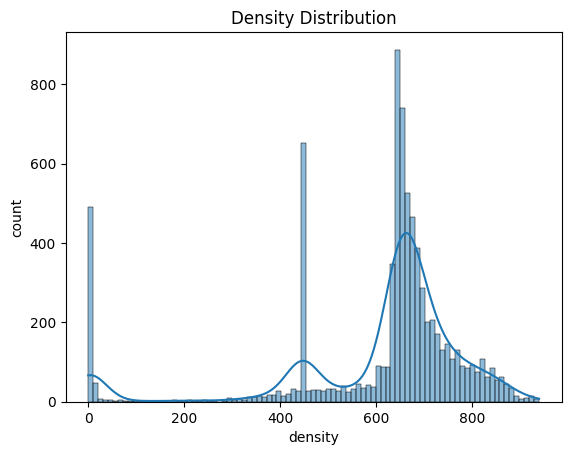

In [22]:
sns.histplot(combined_df['density'], kde=True)
plt.xlabel('density')
plt.ylabel('count')
plt.title('Density Distribution')
plt.show()

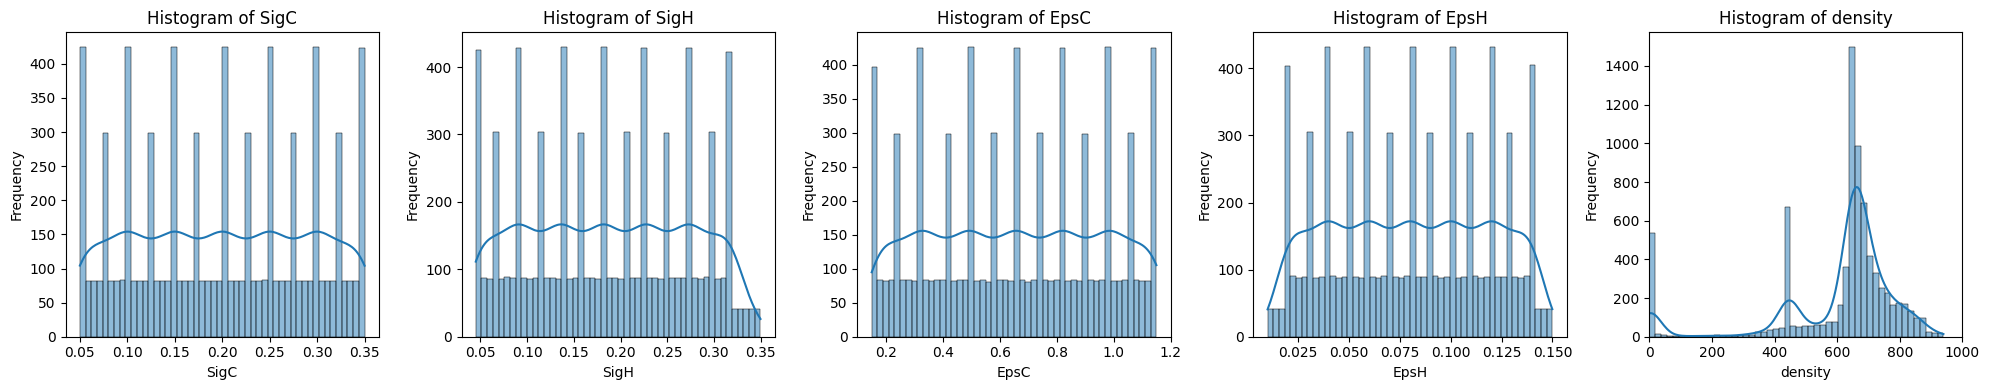

In [23]:
distribution_plot_feat_lab(combined_df)

Die unterschiedlichen Sample-Methoden für die Erstellung des Datensatzes kann hier gut beobachtet werden. Die jeweilgen Spikes bei den Inputs sind die Grid Samples (7<sup>4</sup> und 6<sup>4</sup>), während der Rest mit Sobol-Sampling erstellt wurde.

In [24]:
density_counts = combined_df['density'].value_counts()
print(density_counts.head())

density
446.143    621
0.000      277
635.945      3
852.605      2
652.599      2
Name: count, dtype: int64


621 Einträge bei genau 446.143 kg/m<sup>3</sup> und 277 Einträge bei 0 kg/m^<sup>3</sup> deuten auf einen klaren Simualtionsfehler. Der Grund für den Simulationsfehler konnte nicht gefunden werden, die Vermutung liegt jedoch in numerischer Instabilität innerhalb der MD-Simualtion selbst.

Aus diesem Grund werden diese Zeilen gelöscht. Außerdem werden alle Einträge, bei denen die Dichte unter 50 kg/m^3 liegt ebenfalls gelöscht, da diese keinen physikalischen Mehrwert bieten. Genauso alle Einträge, bei denen die Spalte `estimErr` ungültig ist.

In [25]:
df_removed = combined_df[~combined_df['density'].isin([446.143, 0.0])]
df_over_50__ = df_removed[df_removed['density'] > 50]
df_over_50 = df_over_50__[df_over_50__['estimErr'] != '--']

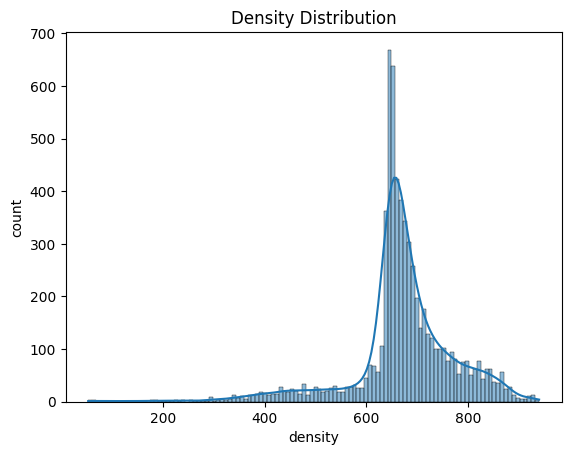

In [26]:
sns.histplot(df_over_50['density'], kde=True)
plt.xlabel('density')
plt.ylabel('count')
plt.title('Density Distribution')
plt.show()

Nun sind die beiden Ausreißer ganz entfernt. Um nun jedoch auszuschließen, dass zwischen 600 und 700 ebenfalls Ausreißer sind, kann sich der Plot in nur diesem Abschnitt betrachtet werden.

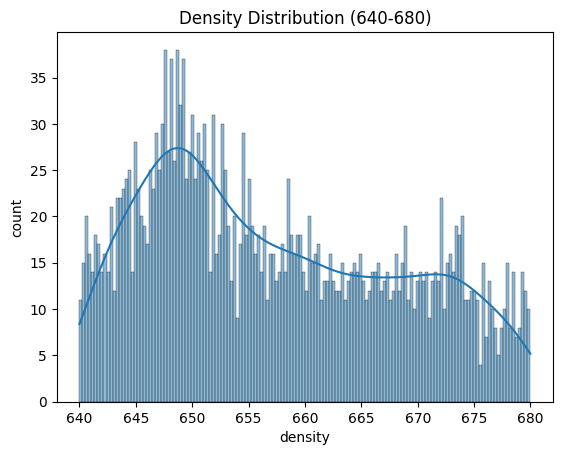

In [27]:
sns.histplot(df_over_50[(df_over_50['density'] >= 640) & (df_over_50['density'] <= 680)]['density'], kde=True, bins=150)
plt.xlabel('density')
plt.ylabel('count')
plt.title('Density Distribution (640-680)')
plt.show()

Wie auch schon vorher an der Auflistung gesehen, ist in diesem Bereich kein spzifischer Ausreißer vorhanden.

Nun kann der bereinigte Datensatz gespechert werden, um ihn für spätere Anwendungen nutzen zu können.

In [28]:
df_over_50.to_csv('over_50_with_estimErr.csv', index=False)

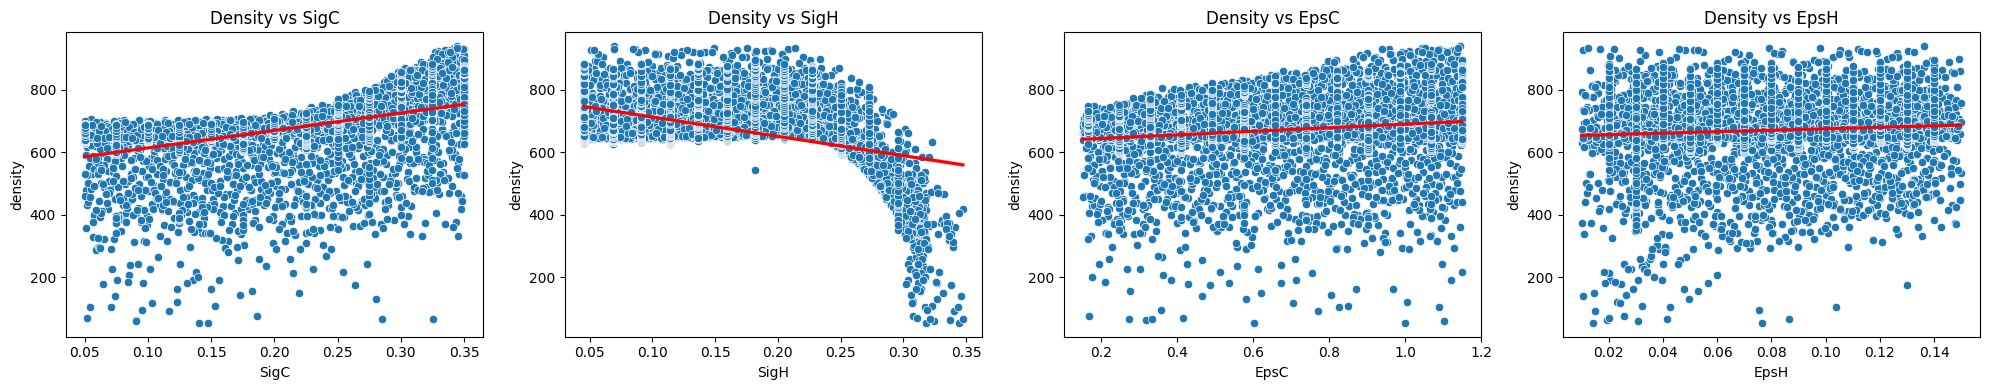

In [33]:
feature_density_scatter(df_over_50, fit=True, titles=["Density vs Features (density > 50)"])

Wie bereits im Vorprojekt erkannt wurde, sind die Features und die Dichte größtenteils nicht linear abhängig. In oberen Extrema hingegen zeigen sie zwar eine Abhängigkeit, die jedoch nicht für die Modellierung eines Surrogate Models ausreicht. Aus diesem Grund wurde sich gegen das weitere Testen von klassischen Regressionsmodellen entschieden.

In [34]:
data = pd.read_csv('over_50_with_estimErr.csv')
data_no_estimErr = data.drop(columns=['estimErr'])

In [35]:
FEATURES = ["SigC", "SigH", "EpsC", "EpsH"]
TARGET = "density"
ESTIM_ERR = "estimErr"

In [36]:
X = data_no_estimErr[FEATURES].values
y = data_no_estimErr[TARGET].values
estim_err = data[ESTIM_ERR].values

### Splitting the Dataset

In diesem Schritt wird der Datensatz in drei Teile geteilt. Diese Teile bleiben über das gesamte Projekt bestehen und werden daher immer wieder verwendet. Änderungen in diesen Zellen hat zur Folge, dass auch alle weiteren Zellen erneut gestartet werden müssen, um die Konsistenz über das Gesamtprojekt zu bewahren.

Die Splits werden folgendermaßen aufgeteilt:

| Split         | Anteil    | Verwendungszweck                                                                                          |
|---------------|-----------|-----------------------------------------------------------------------------------------------------------|
| Train         | 70%       | Modell wird auf diesen Daten trainiert. Das Modell kennt diese Daten nach dem Training                    |
| Validation    | 15%       | Wird zur Modellvalidierung während des Trainings verwendet                                                |
| Test          | 15%       | Finale, unabhängige Bewertung der Modellleistung. Realistische Einschätzung der Generalisierungsfähigkeit |

In [37]:
split_train = 0.7
split_val = 0.15
split_test = 0.15

In [38]:
X_train_temp, X_test, y_train_temp, y_test, estim_err_train_temp, estim_err_test = train_test_split(
    X, y, estim_err,
    test_size=split_test, # 15% test set
    random_state=SEED
)

X_train, X_val, y_train, y_val, estim_err_train, estim_err_val = train_test_split(
    X_train_temp, y_train_temp, estim_err_train_temp,
    test_size=split_val / split_train,  # 15% validation set (relative to the original dataset)
    random_state=SEED
)

Der Testsplit wird hier gespeichert, um ein versehentliches Verlieren vorzubeugen und die Evaluation unabhängig des restlichen Projekts zu machen.

In [40]:
df_test = pd.DataFrame(X_test, columns=FEATURES)
df_test[TARGET] = y_test
df_test[ESTIM_ERR] = estim_err_test

df_test.to_csv(PATH_TEST_DATA, index=False)

## Modeling

### Custom Model Class

Ein Custom Model Class ist notwendig, um die Konsistenz über alle Modelle zu gewährleisten. 

---

#### Architektur

Als Surrogatmodell wird ein vollständig verbundenes neuronales Netz (Multilayer Perceptron) verwendet:

- Eingabeschicht: 4 Neuronen
- Versteckte Schichten: 16 → 32 → 8 Neuronen
- Aktivierungsfunktion: ReLU
- Ausgabeschicht: 1 Neuron (Dichte)

Die Architektur wurde bewusst einfach gehalten und wird in allen weiteren Experimenten unverändert verwendet, um eine vergleichbare Bewertung verschiedener Trainingsstrategien zu ermöglichen.

In [53]:
class RegressionNet(nn.Module):
    def __init__(self, num_features=4):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(num_features, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 8),
            nn.ReLU(),
            nn.Linear(8, 1)
        )

    def forward(self, x):
        return self.model(x)

### Modellieren eines simplen neuronalen Netzwerks (NN)

Für die Approximation der Simulationsdaten wird ein einfaches, voll verbundenes neuronales Netzwerk (Feedforward Neural Network) verwendet. Ziel ist es, einen nichtlinearen Zusammenhang zwischen Eingangsparametern und Zielgröße zu modellieren.

---

**Ablauf**

Ein typischer Trainingsprozess umfasst folgende Schritte pro Epoche:

1. **Forward Pass**

    Eingabedaten werden durch das Netzwerk propagiert --> Vorhersage 

2. **Loss-Berechnung**

    Berechnung des Fehlers zwischen Vorhersage und Zielwert

3. **Backward Pass (Backpropagation)**

    Berechnung der Gradienten der Loss-Funktion bezüglich aller Modellparameter

4. **Parameter-Update**

    Anpassung der Gewichte mithilfe des Optimierers

Dieser Prozess wird über mehrere Epochen wiederholt, bis:

- die Loss-Funktion konvergiert

- ein Early-Stopping-Kriterium erfüllt ist

- oder eine maximale Epochenanzahl erreicht wird

#### Kopieren für NN Training

In [ ]:
# Copy to separate logic
X_train_nn = copy.deepcopy(X_train)
y_train_nn = copy.deepcopy(y_train)

X_val_nn = copy.deepcopy(X_val)
y_val_nn = copy.deepcopy(y_val)

X_test_nn = copy.deepcopy(X_test)
y_test_nn = copy.deepcopy(y_test)

#### Skalieren und Transformieren der Daten

Vor derm Training des Modells werden die Eingabe- und Zielgrößen skaliert und transformiert. Dieser Schritt ist besonders bei neuronalen Netzen entscheidend, da die numerische Größenordnung der Daten das Traningsverhalten stark beeinflusst.

Der hier verwendete Ansatz ist die "Standard"-Methode:

$$
x_{\text{scaled}} = \frac{x - \mu}{\sigma}
$$

Dabei gilt:

- $x$: Ursprünglicher Wert

- $\mu$: Mittelwert des Features (berechnet aus dem Trainingsset, da dies der für das Modell bekannte Datensatz ist)

- $\sigma$: Standardabweichung des Features (ebenfalls aus dem Trainingsset)

Daraus ergibt sich ein neuer Mittelwert von 0 und eine Standardabweichung von 1.

In [ ]:
feature_scaler_nn = StandardScaler()
target_scaler_nn = StandardScaler()

X_train_scaled_nn = feature_scaler_nn.fit_transform(X_train_nn)
X_val_scaled_nn = feature_scaler_nn.transform(X_val_nn)
X_test_scaled_nn = feature_scaler_nn.transform(X_test_nn)

y_train_scaled_nn = target_scaler_nn.fit_transform(y_train_nn.reshape(-1, 1)).ravel()
y_val_scaled_nn = target_scaler_nn.transform(y_val_nn.reshape(-1, 1)).ravel()
y_test_scaled_nn = target_scaler_nn.transform(y_test_nn.reshape(-1, 1)).ravel()

In [ ]:
FEATURE_SCALER_NN = feature_scaler_nn
TARGET_SCALER_NN = target_scaler_nn

joblib.dump(feature_scaler_nn, PATH_FEATURE_SCALER_NN)
joblib.dump(target_scaler_nn, PATH_TARGET_SCALER_NN)

['final/scalers/target_scaler_nn.pkl']

`estimErr` wird nicht skaliert, da es sich hierbei um Metadaten handelt.

#### Konvertierung zu Tensors

In [ ]:
X_train_tensor_nn = torch.tensor(X_train_scaled_nn, dtype=torch.float32)
y_train_tensor_nn = torch.tensor(y_train_scaled_nn, dtype=torch.float32).unsqueeze(1)

X_val_tensor_nn = torch.tensor(X_val_scaled_nn, dtype=torch.float32)
y_val_tensor_nn = torch.tensor(y_val_scaled_nn, dtype=torch.float32).unsqueeze(1)

X_test_tensor_nn = torch.tensor(X_test_scaled_nn, dtype=torch.float32)
y_test_tensor_nn = torch.tensor(y_test_scaled_nn, dtype=torch.float32).unsqueeze(1)

#### Loader erstellen

In [ ]:
train_ds_nn = TensorDataset(X_train_tensor_nn, y_train_tensor_nn)
val_ds_nn = TensorDataset(X_val_tensor_nn, y_val_tensor_nn)
test_ds_nn = TensorDataset(X_test_tensor_nn, y_test_tensor_nn)

train_loader_nn = DataLoader(train_ds_nn, batch_size=BATCH_SIZE, shuffle=True)
val_loader_nn = DataLoader(val_ds_nn, batch_size=BATCH_SIZE, shuffle=False)
test_loader_nn = DataLoader(test_ds_nn, batch_size=BATCH_SIZE, shuffle=False)

#### Initialize model, loss & optimizer

Die verwendete Loss-Funkion ist der Mean Squared Error. Große Abweichungen werden demnach stärker bestraft.

Der Adam-Optimizer (Adaptive Moment Estimation) kombiniert adaptive Lernraten und Momentum, um Parameter effizient zu optimieren. Dabei wird für jeden Parameter die Lernrate individuell angepasst.

In [ ]:
model_nn = RegressionNet(4).to(DEVICE)

criterion_nn = nn.MSELoss()
optimizer_nn = torch.optim.Adam(model_nn.parameters(), lr=0.001)

#### Training loop

In [ ]:
best_val_loss = float('inf')
best_rmse = float('inf')
epochs_no_improve = 0

for epoch in range(NUM_EPOCHS):
    # --- TRAIN ---
    model_nn.train()
    train_loss = 0.0

    for xb, yb in train_loader_nn:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)

        optimizer_nn.zero_grad()
        outputs = model_nn(xb)
        loss = criterion_nn(outputs, yb)
        loss.backward()
        optimizer_nn.step()

        train_loss += loss.item() * xb.size(0)
    
    train_loss /= len(train_loader_nn.dataset)

    # --- VALIDATION (ONLY for early stopping) ---
    model_nn.eval()
    val_loss = 0.0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for xb, yb in val_loader_nn:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            outputs = model_nn(xb)
            loss = criterion_nn(outputs, yb)
            val_loss += loss.item() * xb.size(0)

            # collect for inverse transform
            all_preds.append(outputs.cpu())
            all_targets.append(yb.cpu())
    
    val_loss /= len(val_loader_nn.dataset)

    # concatenate
    all_preds = torch.cat(all_preds, dim=0).numpy()
    all_targets = torch.cat(all_targets, dim=0).numpy()

    # inverse transform
    all_preds_inv = target_scaler_nn.inverse_transform(all_preds)
    all_targets_inv = target_scaler_nn.inverse_transform(all_targets)

    # compute metrics
    rmse = root_mean_squared_error(all_targets_inv, all_preds_inv)
    mae  = mean_absolute_error(all_targets_inv, all_preds_inv)

    # --- EARLY STOPPING LOGIC ---
    if val_loss < (best_val_loss - MIN_DELTA):
        best_val_loss = val_loss
        best_rmse = rmse
        epochs_no_improve = 0

        BEST_NN = copy.deepcopy(model_nn)

        torch.save(model_nn.state_dict(), PATH_NN)
    else:
        epochs_no_improve += 1

    
    if epoch % SAVE_STEP == 0:
        os.makedirs(f"{RUN}/{DIR_MODEL_SAVE}/NN", exist_ok=True)
        torch.save(model_nn.state_dict(), f"{RUN}/{DIR_MODEL_SAVE}/NN/model_nn_epoch_{epoch:03d}.pt")
        print(f"Epoch {epoch:03d} | RMSE: {rmse:.4f} | MAE: {mae:.4f} | Best RMSE: {best_rmse:.4f} | Epochs No Improve: {epochs_no_improve}")

    if epochs_no_improve >= PATIENCE:
        print(f"Early stopping at epoch {epoch:03d} after {PATIENCE} epochs with no improvement.")
        break

    LOSS_NN_TRAIN.append(train_loss)
    LOSS_NN_VAL.append(val_loss)
    RMSE_VAL_NN.append(rmse)
    MAE_VAL_NN.append(mae)

Epoch 000 | RMSE: 47.8669 | MAE: 32.3327 | Best RMSE: 47.8669 | Epochs No Improve: 0
Epoch 005 | RMSE: 16.3900 | MAE: 9.9554 | Best RMSE: 16.3900 | Epochs No Improve: 0
Epoch 010 | RMSE: 14.0031 | MAE: 8.8376 | Best RMSE: 14.0031 | Epochs No Improve: 0
Epoch 015 | RMSE: 12.8656 | MAE: 8.1490 | Best RMSE: 12.8656 | Epochs No Improve: 0
Epoch 020 | RMSE: 12.5372 | MAE: 7.7845 | Best RMSE: 12.0988 | Epochs No Improve: 1
Epoch 025 | RMSE: 12.2796 | MAE: 8.0813 | Best RMSE: 11.9279 | Epochs No Improve: 2
Epoch 030 | RMSE: 11.7748 | MAE: 7.3008 | Best RMSE: 11.5590 | Epochs No Improve: 4
Epoch 035 | RMSE: 12.4618 | MAE: 8.5590 | Best RMSE: 11.2354 | Epochs No Improve: 1
Epoch 040 | RMSE: 11.2376 | MAE: 7.0569 | Best RMSE: 11.2354 | Epochs No Improve: 6
Epoch 045 | RMSE: 12.0733 | MAE: 7.5779 | Best RMSE: 11.2354 | Epochs No Improve: 11
Epoch 050 | RMSE: 11.7138 | MAE: 7.1865 | Best RMSE: 10.9303 | Epochs No Improve: 3
Epoch 055 | RMSE: 11.2385 | MAE: 7.0230 | Best RMSE: 10.9303 | Epochs No I

In [ ]:
with open(f"{RUN}/{DIR_LOSS_SAVE}/rmse_nn.csv", 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(RMSE_VAL_NN)

with open(f"{RUN}/{DIR_LOSS_SAVE}/mae_nn.csv", 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(MAE_VAL_NN)

### Active Learning

Active Learning (AL) ist eine iterative Trainingsstrategie, bei der das Modell nicht mit einem großen, fest definierten Trainingsdatensatz startet, sondern iterativ entscheidet, welche neuen Datenpunkte am informativsten sind.

Das Ziel ist es mit möglichst wenigen Trainingsdaten eine möglichst hohe Modellgüt bei minimalem Simulationsaufwand zu erreichen. Die ist gerade bei teuren Simulationen entscheidend, da jeder neue Datenpunkt zunächst Rechenzeit kostet.

---

**Ablauf**

Eine typische Iteration sieht folgendermaßen aus:

- Trainiere Modell auf dem aktuellen Trainingsset

- Bewerte Fehler auf den Validation-Daten

- Wähle die informativsten Samples aus dem Pool

- Füge diese dem Trainingsset hinzu

- Skaliere und Transfomiere basierend auf den Trainingsdaten erneut

- Wiederhole den Prozess

Dabei wächst das Trainingsset schrittweise, während der Pool kleiner wird.

---

**Auswahlkriterien**

Im weiteren Verlauf werden mögliche Auswahlstrategien vorgestellt und implementiert. Hier ein erster Überblick:

- Random

- Boundary

- Sparse

- Error-based

- Query-By-Committee

---

**Ziele**

- Entwicklung des RMSE mit wachsender Trainingsmenge

- Vergleich der Konvergenz geszielter Auswahlstrategien

- Daten-Effizienz

- Performanz

In [41]:
# Copy to separate logic
X_train_temp_al = copy.deepcopy(X_train)
y_train_temp_al = copy.deepcopy(y_train)

X_val_al = copy.deepcopy(X_val)
y_val_al = copy.deepcopy(y_val)

X_test_al = copy.deepcopy(X_test)
y_test_al = copy.deepcopy(y_test)

#### Create an active pool and initial training set

| Split      | Anteil |
| ---------- | ------ |
| Train      | 0.3 %  |
| Pool       | 66.4 % |
| Validation | 18.2 % |
| Test       | 15 %   |

**Train**

- Sehr kleines initiales Trainingsset
- Dient als Startpunkt für das Modell
- Enthält nur einen minimalen Bruchteil der verfügbaren Daten

**Pool**

- Enthält noch nicht verwendete Daten --> Übernimmt die Rolle der Simulation
- Aus diesem Pool werden iterativ neue Trainingspunkte ausgewählt
- Simuliert die eigentliche MD-Simulation, da während des Porjekts kein Zugriff auf die MD-Simulation möglich war

**Validation**

- Dient zur Überwachung des Trainings
- Wird nicht aktiv erweitert

**Test**

- Wird ausschließlich für die finale Bewertung verwendet
- Gleiches Set, wie vorher und überall sonst

In [42]:
initial_train_size = 0.005

In [43]:
X_train_al, X_pool_al, y_train_al, y_pool_al = train_test_split(
    X_train_temp_al, y_train_temp_al,
    test_size=1 - initial_train_size,
    random_state=SEED
)

In [44]:
len(X_train_al), len(X_pool_al), len(X_val_al), len(X_test_al)

(22, 4389, 1204, 992)

#### Skalieren und Transformieren

Auch hier wurden die gleiche Strategie wie beim einfachen neuronalen Netz verwendet.

In [ ]:
feature_scaler_al = StandardScaler()
target_scaler_al = StandardScaler()

X_train_scaled_al = feature_scaler_al.fit_transform(X_train_al)
X_pool_scaled_al = feature_scaler_al.transform(X_pool_al)
X_val_scaled_al = feature_scaler_al.transform(X_val_al)
X_test_scaled_al = feature_scaler_al.transform(X_test_al)

y_train_scaled_al = target_scaler_al.fit_transform(y_train_al.reshape(-1, 1)).ravel()
y_pool_scaled_al = target_scaler_al.transform(y_pool_al.reshape(-1, 1)).ravel()
y_val_scaled_al = target_scaler_al.transform(y_val_al.reshape(-1, 1)).ravel()
y_test_scaled_al = target_scaler_al.transform(y_test_al.reshape(-1, 1)).ravel()

#### Strategies

##### Random Sampling

Wählt zufällig `k`-viele Punkte aus dem Pool.

In [ ]:
def sample_random(X_pool, k, seed=SEED):
    """
    Randomly select k indices from the pool.

    Parameters
    ----------
    X_pool : np.ndarray
        Pool features, shape (N_pool, d)
    k : int
        Number of samples to acquire
    seed : int or None
        Random seed

    Returns
    -------
    selected_idx : np.ndarray
        Indices (relative to pool) of selected samples
    """
    n_pool = len(X_pool)
    if k > n_pool:
        raise ValueError("k must be smaller than pool size")

    rng = np.random.default_rng(seed)
    selected_idx = rng.choice(n_pool, size=k, replace=False)

    return selected_idx

##### Boundary Sampling (Randbereich)

Ein Punkt ist Randpunkt, wenn mindestens ein Feature im unteren oder oberen Quantil (5%) liegt. Falls mehr als `k`-viele Randpunkte existieren, wird zufällig aus diesen gewählt, sonst alle.

Diese Strategie ist rein geometrisch motiviert und adressiert gezielt Rand- und Extrembereiche, die für Surrogatmodelle besonders herausfordernd sind.

Erweiterbar:

- Progressive Randbereiche. Mit laufender Iteration den Randbereich verkleinern (Bspw.: 20& --> 1%)

- statt mindestens ein Feature, müssen alle Feature im Randbereich liegen

In [ ]:
def sample_boundary(X_pool, k, quantile=0.05, seed=SEED):
    """
    Select k samples from the pool that are closest to the decision boundary of a simple linear model.

    Parameters
    ----------
    X_pool : np.ndarray
        Pool features, shape (N_pool, d)
    k : int
        Number of samples to acquire
    quantile : float
        Quantile to determine boundary threshold (e.g. 0.05 for 5% closest)
    seed : int or None
        Random seed

    Returns
    -------
    selected_idx : np.ndarray
        Indices (relative to pool) of selected samples
    """
    if k > len(X_pool):
        raise ValueError("k must be smaller than pool size")

    # compute feature-wise quantiles
    lower = np.quantile(X_pool, quantile, axis=0)
    upper = np.quantile(X_pool, 1 - quantile, axis=0)

    # boundary mask
    is_boundary = np.any(
        (X_pool <= lower) | (X_pool >= upper),
        axis=1,
    )

    boundary_idx = np.where(is_boundary)[0]

    if len(boundary_idx) == 0:
        raise RuntimeError("No boundary points found")

    rng = np.random.default_rng(seed)

    if len(boundary_idx) > k:
        selected_idx = rng.choice(boundary_idx, size=k, replace=False)
    else:
        selected_idx = boundary_idx

    return selected_idx

##### Sparse Sampling

Beim Sparse Sampling werden gezielt Datenpunkte ausgewählt, die im Parameterraum möglichst weit von den bisherigen Trainingspunkten entfernt liegen.

Für jeden Punkt $x \in X_{pool}$:

$$
d(x) = \min_{x' \in X_{train}} || x - x' ||
$$

Wähle die `k` Punkte mit dem größten $d(x)$

Distanzen sind jedoch nur sinnvoll im skaliertem Raum, da die Feautures unterschiedliche Skalen haben. Es wird der selbe Feature-Scaler genutzt, der auf dem aktuellen Trainingsset gefittet wurde.

Dieses Auswahlkriterium soll "Cluster-Überlernen" verhinden.

In [ ]:
def sample_sparse(X_train, X_pool, k, seed=SEED):
    """
    Select k samples from the pool that are furthest from any training sample (i.e. most "sparse" region).
    
    Parameters
    ----------
    X_train : np.ndarray
        Training features, shape (N_train, d)
    X_pool : np.ndarray
        Pool features, shape (N_pool, d)
    k : int
        Number of samples to acquire
    seed : int or None
        Random seed (not used here but kept for consistency with other functions)
    Returns
    -------
    selected_idx : np.ndarray
        Indices (relative to pool) of selected samples
    """
    if k > len(X_pool):
        raise ValueError("k must be smaller than pool size")

    distances = pairwise_distances(X_pool, X_train, metric='sqeuclidean')

    min_distances = distances.min(axis=1)

    selected_idx = np.argsort(min_distances)[-k:]

    return selected_idx

##### Error-based Sampling

Es ist nicht möglich direkt die schlechten Punkte in das Training aufzunehmen, da wir im online Active Learning die Label nicht kennen. Daher müssen wir die Fehler in einem Raum berechnen und auf das Pool projezieren.

Annahme: Wo das Modell im bekannten Raum schlecht ist, ist es vermutlich auch im ähnlichen unbekannten Raum schlecht.

Das Modell wird auf dem aktuellen Trainingsset trainiert. Daraufhin wird der Fehler mit dem Validationsset berechnet. Die schlechtesten Punkte werden daraus abgelesen (Bspw. Top 10%) und aus dem Pool werden die nächsten Nachbarn (euklidische Distanzmessung) (Bspw. 20 pro Raum) zu diesen Punkten in das Trainingsset aufgenommen.

> Der Fehler auf einem separaten Validierungssatz wird verwendet, um Regionen zu identifizieren, in denen das Modell strukturell schwach ist. Anschließend werden ähnliche Punkte aus dem Pool gezielt dem Trainingsdatensatz hinzugefügt.

In [ ]:
def sample_error_based(
    model,
    X_val,
    y_val,
    X_pool,
    feature_scaler,
    target_scaler,
    k,
    top_frac=0.05,
    seed=SEED,
):
    """
    Select k samples from the pool that are closest to the worst-performing validation samples (i.e. where the model has highest error).

    Parameters
    ----------
    model : torch.nn.Module
        The trained model to evaluate on the validation set
    X_val : np.ndarray
        Validation features, shape (N_val, d)
    y_val : np.ndarray
        Validation targets, shape (N_val,)
    X_pool : np.ndarray
        Pool features, shape (N_pool, d)
    feature_scaler : sklearn scaler
        Scaler used for features (fitted on training features)
    target_scaler : sklearn scaler
        Scaler used for target (fitted on training targets)
    k : int
        Number of samples to acquire
    top_frac : float
        Fraction of validation samples to consider as "worst" (e.g. 0.05 for top 5%)
    seed : int or None
        Random seed (not used here but kept for consistency with other functions)

    Returns
    -------
    selected_idx : np.ndarray
        Indices (relative to pool) of selected samples
    """
    device = next(model.parameters()).device
    model.eval()

    X_val_scaled = feature_scaler.transform(X_val)

    if not np.isfinite(X_val_scaled).all():
        raise ValueError("X_val_scaled contains NaN or Inf")

    # validation prediction
    X_val_t = torch.tensor(X_val_scaled, dtype=torch.float32).to(device)

    with torch.no_grad():
        preds_val_scaled = model(X_val_t).cpu().numpy().ravel()

    preds_val = target_scaler.inverse_transform(preds_val_scaled.reshape(-1, 1)).ravel()

    errors = np.abs(preds_val - y_val)

    n_worst = max(1, int(top_frac * len(errors)))
    worst_idx = np.argsort(errors)[-n_worst:]

    X_val_worst = X_val[worst_idx]

    X_pool_scaled = feature_scaler.transform(X_pool)
    X_worst_scaled = feature_scaler.transform(X_val_worst)

    if not np.isfinite(X_pool_scaled).all():
        raise ValueError("X_pool_scaled contains NaN or Inf")

    if not np.isfinite(X_worst_scaled).all():
        raise ValueError("X_worst_scaled contains NaN or Inf")

    # distances: pool vs worst validation points
    distances = pairwise_distances(
        X_pool_scaled,
        X_worst_scaled,
        metric="sqeuclidean",
    )

    min_dist = distances.min(axis=1)

    selected_idx = np.argsort(min_dist)[:k]

    return selected_idx


##### Query-By-Committee

Hier werden mehrere Modelle gleicher Architektur, aber unterschiedlicher Initialisierungen genutzt, um Vohersage-Streuungen als Auswahlkriterium neuer Punkte zu nutzen.

Für jeden Punkt im Pool wird die Varianz der Modellvorhersagen berechnet. Punkte mit hoher Varianz weisen auf Modellinstabilität hin und werden als besonders informativ betrachtet.

Diese Varianz dient als Proxy für epistemische Unsicherheit, ohne explizit bayesianische Methoden zu verwenden.

In [ ]:
def sample_qbc(
    X_train,
    y_train,
    X_val,
    y_val,
    X_pool,
    feature_scaler,
    target_scaler,
    k,
    model_factory,
    train_fn,
    n_models=5,
    n_epochs=200,
    seed_base=0,
    device=DEVICE,
):
    """
    Select k samples from the pool based on Query by Committee (QBC) using an ensemble of models trained on the current training set.

    Parameters
    ----------
    X_train : np.ndarray
        Training features, shape (N_train, d)
    y_train : np.ndarray
        Training targets, shape (N_train,)
    X_val : np.ndarray
        Validation featuers
    y_val : np.ndarray
        Validation targets
    X_pool : np.ndarray
        Pool features, shape (N_pool, d)
    feature_scaler : sklearn scaler
        Scaler used for features (fitted on training features)
    target_scaler : sklearn scaler
        Scaler used for target (fitted on training targets)
    k : int
        Number of samples to acquire
    model_factory : function
        Function that takes input dimension and returns a new untrained model instance
    train_fn : function
        Function that takes (model, X_train, y_train, n_epochs, device) and trains the model, returning the trained model
    n_models : int
        Number of models in the committee
    n_epochs : int
        Number of epochs to train each model
    seed_base : int
        Base random seed for reproducibility (each model will use seed_base + i)
    device : torch.device
        Device to run training on (e.g. 'cpu', 'cuda', 'mps')

    Returns
    -------
    selected_idx : np.ndarray
        Indices (relative to pool) of selected samples
    """
    preds_all = []

    X_train_t = torch.tensor(
        X_train, dtype=torch.float32
    ).to(device)
    y_train_t = torch.tensor(
        y_train, dtype=torch.float32
    ).unsqueeze(1).to(device)

    X_val_s = feature_scaler.transform(X_val)
    y_val_s = target_scaler.transform(y_val.reshape(-1, 1)).ravel()

    X_pool_t = torch.tensor(
        X_pool, dtype=torch.float32
    ).to(device)

    for i in range(n_models):
        torch.manual_seed(seed_base + i)

        model = model_factory(X_train.shape[1]).to(device)

        model = train_fn(
            model,
            X_train,
            y_train,
            n_epochs=n_epochs,
            device=device,
            X_val_s=X_val_s,
            y_val_s=y_val_s,
        )

        model.eval()
        with torch.no_grad():
            preds = model(X_pool_t).cpu().numpy().ravel()
            preds_all.append(preds)

    preds_all = np.stack(preds_all, axis=0)

    variances = preds_all.var(axis=0)

    selected_idx = np.argsort(variances)[-k:]

    return selected_idx

#### Active Learning Training

In diesem Abschnitt werden die Modelle nach den oben eingeführten Auswahlkriterien trainiert.

##### Random Sampling

In [ ]:
X_train_al_random = copy.deepcopy(X_train_al)
y_train_al_random = copy.deepcopy(y_train_al)
X_pool_al_random = copy.deepcopy(X_pool_al)
y_pool_al_random = copy.deepcopy(y_pool_al)
X_val_al_random = copy.deepcopy(X_val_al)
y_val_al_random = copy.deepcopy(y_val_al)
X_test_al_random = copy.deepcopy(X_test_al)
y_test_al_random = copy.deepcopy(y_test_al)

X_train_scaled_al_random = copy.deepcopy(X_train_scaled_al)
y_train_scaled_al_random = copy.deepcopy(y_train_scaled_al)
X_pool_scaled_al_random = copy.deepcopy(X_pool_scaled_al)
y_pool_scaled_al_random = copy.deepcopy(y_pool_scaled_al)
X_val_scaled_al_random = copy.deepcopy(X_val_scaled_al)
y_val_scaled_al_random = copy.deepcopy(y_val_scaled_al)
X_test_scaled_al_random = copy.deepcopy(X_test_scaled_al)
y_test_scaled_al_random = copy.deepcopy(y_test_scaled_al)

RMSE_VAL_AL_RANDOM = []
MAE_VAL_AL_RANDOM = []

In [ ]:
epochs_no_improve = 0
epoch = 0
best_rmse = float('inf')
feature_scaler_al_random_best_model = None
target_scaler_al_random_best_model = None

model_random = RegressionNet(4).to(DEVICE)
model_random = train_model(
    model_random,
    X_train_scaled_al_random,
    y_train_scaled_al_random,
    n_epochs=NUM_EPOCHS,
    device=DEVICE,
    X_val_s=X_val_scaled_al_random,
    y_val_s=y_val_scaled_al_random,
    patience=PATIENCE,
    min_delta=MIN_DELTA,
)

while(len(X_pool_al_random) > K): # Train as long as data is available
# for _ in range(10): # Max 100 iterations to prevent infinite loop in case of bugs
    epoch += 1
    selected_idx_test = sample_random(
        X_pool=X_pool_al_random, 
        k=K, 
        seed=SEED
    )

    X_train_al_random, y_train_al_random, X_pool_al_random, y_pool_al_random = transfer_from_pool_to_train(
        X_train_al_random,
        y_train_al_random,
        X_pool_al_random,
        y_pool_al_random,
        selected_idx_test,
    )

    (
        X_train_scaled_al_random, y_train_scaled_al_random,
        X_val_scaled_al_random, y_val_scaled_al_random,
        X_pool_scaled_al_random, y_pool_scaled_al_random,
        X_test_scaled_al_random, y_test_scaled_al_random,
        feature_scaler_al_random, target_scaler_al_random
    ) = scale_data(
        X_train_al_random, y_train_al_random,
        X_val_al_random, y_val_al_random,
        X_pool_al_random, y_pool_al_random,
        X_test_al_random, y_test_al_random
    )

    model_random = RegressionNet(4).to(DEVICE)
    model_random = train_model(
        model_random,
        X_train_scaled_al_random,
        y_train_scaled_al_random,
        n_epochs=NUM_EPOCHS,
        device=DEVICE,
        X_val_s=X_val_scaled_al_random,
        y_val_s=y_val_scaled_al_random,
        patience=PATIENCE,
        min_delta=MIN_DELTA,
    )

    rmse, mae = evaluate_model(
        model_random,
        X_val_scaled_al_random,
        y_val_scaled_al_random,
        target_scaler_al_random,
        device=DEVICE
    )
    RMSE_VAL_AL_RANDOM.append(rmse)
    MAE_VAL_AL_RANDOM.append(mae)

    # Save best model
    if rmse < best_rmse:
        best_rmse = rmse
        BEST_AL_RANDOM = copy.deepcopy(model_random)
        feature_scaler_al_random_best_model = copy.deepcopy(feature_scaler_al_random)
        target_scaler_al_random_best_model = copy.deepcopy(target_scaler_al_random)
        torch.save(model_random.state_dict(), PATH_AL_RANDOM)
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
    
    if epoch % SAVE_STEP == 0:
        os.makedirs(f"{RUN}/{DIR_MODEL_SAVE}/Random", exist_ok=True)
        os.makedirs(f"{RUN}/{DIR_SCALERS_SAVE}/Random", exist_ok=True)
        torch.save(model_random.state_dict(), f"{RUN}/{DIR_MODEL_SAVE}/Random/model_random_epoch_{epoch:03d}.pt")
        joblib.dump(feature_scaler_al_random, f"{RUN}/{DIR_SCALERS_SAVE}/Random/feature_scaler_epoch_{epoch:03d}.pkl")
        joblib.dump(target_scaler_al_random, f"{RUN}/{DIR_SCALERS_SAVE}/Random/target_scaler_epoch_{epoch:03d}.pkl")
        print(f"Epoch {epoch:03d} | RMSE: {rmse:.4f} | MAE: {mae:.4f} | Best RMSE: {best_rmse:.4f} | Epochs No Improve: {epochs_no_improve}")

    if epochs_no_improve >= PATIENCE:
        print(f"Early stopping at epoch {epoch:03d} after {PATIENCE} epochs with no improvement.")
        break

Epoch 005 | RMSE: 17.5023 | MAE: 10.9342 | Best RMSE: 17.5023 | Epochs No Improve: 0
Epoch 010 | RMSE: 15.5012 | MAE: 9.7711 | Best RMSE: 14.0286 | Epochs No Improve: 2
Epoch 015 | RMSE: 14.4293 | MAE: 9.3407 | Best RMSE: 12.9857 | Epochs No Improve: 2
Epoch 020 | RMSE: 12.9335 | MAE: 8.1538 | Best RMSE: 12.9335 | Epochs No Improve: 0
Epoch 025 | RMSE: 13.9017 | MAE: 9.3886 | Best RMSE: 12.3971 | Epochs No Improve: 3
Epoch 030 | RMSE: 15.1271 | MAE: 9.2745 | Best RMSE: 12.3971 | Epochs No Improve: 8
Epoch 035 | RMSE: 13.2395 | MAE: 8.3776 | Best RMSE: 12.3971 | Epochs No Improve: 13
Epoch 040 | RMSE: 11.4525 | MAE: 7.6709 | Best RMSE: 11.4174 | Epochs No Improve: 3
Epoch 045 | RMSE: 12.6204 | MAE: 7.9027 | Best RMSE: 11.4174 | Epochs No Improve: 8
Epoch 050 | RMSE: 11.2156 | MAE: 7.7662 | Best RMSE: 11.2156 | Epochs No Improve: 0
Epoch 055 | RMSE: 11.5415 | MAE: 7.4113 | Best RMSE: 11.1598 | Epochs No Improve: 2
Epoch 060 | RMSE: 11.0333 | MAE: 7.1709 | Best RMSE: 11.0333 | Epochs No I

save everything important (best model already saved during training)

In [ ]:
FEATURE_SCALER_AL_RANDOM = feature_scaler_al_random_best_model
TARGET_SCALER_AL_RANDOM = target_scaler_al_random_best_model

joblib.dump(feature_scaler_al_random_best_model, PATH_FEATURE_SCALER_AL_RANDOM)
joblib.dump(target_scaler_al_random_best_model, PATH_TARGET_SCALER_AL_RANDOM)

os.makedirs(f"{RUN}/{DIR_LOSS_SAVE}", exist_ok=True)

with open(f"{RUN}/{DIR_LOSS_SAVE}/rmse_al_random.csv", 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(RMSE_VAL_AL_RANDOM)

with open(f"{RUN}/{DIR_LOSS_SAVE}/mae_al_random.csv", 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(MAE_VAL_AL_RANDOM)

##### Boundary Sampling

In [ ]:
X_train_al_boundary = copy.deepcopy(X_train_al)
y_train_al_boundary = copy.deepcopy(y_train_al)
X_pool_al_boundary = copy.deepcopy(X_pool_al)
y_pool_al_boundary = copy.deepcopy(y_pool_al)
X_val_al_boundary = copy.deepcopy(X_val_al)
y_val_al_boundary = copy.deepcopy(y_val_al)
X_test_al_boundary = copy.deepcopy(X_test_al)
y_test_al_boundary = copy.deepcopy(y_test_al)

X_train_scaled_al_boundary = copy.deepcopy(X_train_scaled_al)
y_train_scaled_al_boundary = copy.deepcopy(y_train_scaled_al)
X_pool_scaled_al_boundary = copy.deepcopy(X_pool_scaled_al)
y_pool_scaled_al_boundary = copy.deepcopy(y_pool_scaled_al)
X_val_scaled_al_boundary = copy.deepcopy(X_val_scaled_al)
y_val_scaled_al_boundary = copy.deepcopy(y_val_scaled_al)
X_test_scaled_al_boundary = copy.deepcopy(X_test_scaled_al)
y_test_scaled_al_boundary = copy.deepcopy(y_test_scaled_al)

RMSE_VAL_AL_BOUNDARY = []
MAE_VAL_AL_BOUNDARY = []

In [ ]:
epochs_no_improve = 0
epoch = 0
best_rmse = float('inf')
feature_scaler_al_boundary_best_model = None
target_scaler_al_boundary_best_model = None

model_boundary = RegressionNet(4).to(DEVICE)
model_boundary = train_model(
    model_boundary,
    X_train_scaled_al_boundary,
    y_train_scaled_al_boundary,
    n_epochs=NUM_EPOCHS,
    device=DEVICE,
    X_val_s=X_val_scaled_al_boundary,
    y_val_s=y_val_scaled_al_boundary,
    patience=PATIENCE,
    min_delta=MIN_DELTA,
)

while(len(X_pool_al_boundary) > K): # Train as long as data is available
# for _ in range(10): # Max 100 iterations to prevent infinite loop in case of bugs
    epoch += 1
    selected_idx_test = sample_boundary(
        X_pool=X_pool_al_boundary, 
        k=K, 
        seed=SEED
    )

    X_train_al_boundary, y_train_al_boundary, X_pool_al_boundary, y_pool_al_boundary = transfer_from_pool_to_train(
        X_train_al_boundary,
        y_train_al_boundary,
        X_pool_al_boundary,
        y_pool_al_boundary,
        selected_idx_test,
    )

    (
        X_train_scaled_al_boundary, y_train_scaled_al_boundary,
        X_val_scaled_al_boundary, y_val_scaled_al_boundary,
        X_pool_scaled_al_boundary, y_pool_scaled_al_boundary,
        X_test_scaled_al_boundary, y_test_scaled_al_boundary,
        feature_scaler_al_boundary, target_scaler_al_boundary
    ) = scale_data(
        X_train_al_boundary, y_train_al_boundary,
        X_val_al_boundary, y_val_al_boundary,
        X_pool_al_boundary, y_pool_al_boundary,
        X_test_al_boundary, y_test_al_boundary
    )

    model_boundary = RegressionNet(4).to(DEVICE)
    model_boundary = train_model(
        model_boundary,
        X_train_scaled_al_boundary,
        y_train_scaled_al_boundary,
        n_epochs=NUM_EPOCHS,
        device=DEVICE,
        X_val_s=X_val_scaled_al_boundary,
        y_val_s=y_val_scaled_al_boundary,
        patience=PATIENCE,
        min_delta=MIN_DELTA,
    )

    rmse, mae = evaluate_model(
        model_boundary,
        X_val_scaled_al_boundary,
        y_val_scaled_al_boundary,
        target_scaler_al_boundary,
        device=DEVICE
    )
    RMSE_VAL_AL_BOUNDARY.append(rmse)
    MAE_VAL_AL_BOUNDARY.append(mae)

    # Save best model
    if rmse < best_rmse:
        best_rmse = rmse
        BEST_AL_BOUNDARY = copy.deepcopy(model_boundary)
        feature_scaler_al_boundary_best_model = copy.deepcopy(feature_scaler_al_boundary)
        target_scaler_al_boundary_best_model = copy.deepcopy(target_scaler_al_boundary)
        torch.save(model_boundary.state_dict(), PATH_AL_BOUNDARY)
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
    
    if epoch % SAVE_STEP == 0:
        os.makedirs(f"{RUN}/{DIR_SCALERS_SAVE}/Boundary", exist_ok=True)
        os.makedirs(f"{RUN}/{DIR_MODEL_SAVE}/Boundary", exist_ok=True)
        torch.save(model_boundary.state_dict(), f"{RUN}/{DIR_MODEL_SAVE}/Boundary/model_boundary_epoch_{epoch:03d}.pt")
        joblib.dump(feature_scaler_al_boundary, f"{RUN}/{DIR_SCALERS_SAVE}/Boundary/feature_scaler_epoch_{epoch:03d}.pkl")
        joblib.dump(target_scaler_al_boundary, f"{RUN}/{DIR_SCALERS_SAVE}/Boundary/target_scaler_epoch_{epoch:03d}.pkl")
        print(f"Epoch {epoch:03d} | RMSE: {rmse:.4f} | MAE: {mae:.4f} | Best RMSE: {best_rmse:.4f} | Epochs No Improve: {epochs_no_improve}")

    if epochs_no_improve >= PATIENCE:
        print(f"Early stopping at epoch {epoch:03d} after {PATIENCE} epochs with no improvement.")
        break

Epoch 005 | RMSE: 22.3182 | MAE: 14.5475 | Best RMSE: 22.3182 | Epochs No Improve: 0
Epoch 010 | RMSE: 19.7430 | MAE: 11.6742 | Best RMSE: 19.7430 | Epochs No Improve: 0
Epoch 015 | RMSE: 16.5638 | MAE: 11.3089 | Best RMSE: 14.5888 | Epochs No Improve: 1
Epoch 020 | RMSE: 14.9101 | MAE: 10.3437 | Best RMSE: 13.6645 | Epochs No Improve: 2
Epoch 025 | RMSE: 12.6657 | MAE: 8.5322 | Best RMSE: 12.6657 | Epochs No Improve: 0
Epoch 030 | RMSE: 13.8917 | MAE: 9.3211 | Best RMSE: 12.6657 | Epochs No Improve: 5
Epoch 035 | RMSE: 12.7740 | MAE: 8.4340 | Best RMSE: 12.6657 | Epochs No Improve: 10
Epoch 040 | RMSE: 13.3502 | MAE: 8.5782 | Best RMSE: 12.2002 | Epochs No Improve: 1
Epoch 045 | RMSE: 12.5125 | MAE: 8.2379 | Best RMSE: 12.2002 | Epochs No Improve: 6
Epoch 050 | RMSE: 12.9612 | MAE: 8.3590 | Best RMSE: 10.6530 | Epochs No Improve: 1
Epoch 055 | RMSE: 12.9678 | MAE: 8.5514 | Best RMSE: 10.6530 | Epochs No Improve: 6
Epoch 060 | RMSE: 11.7355 | MAE: 7.5196 | Best RMSE: 10.6530 | Epochs N

In [ ]:
FEATURE_SCALER_AL_BOUNDARY = feature_scaler_al_boundary_best_model
TARGET_SCALER_AL_BOUNDARY = target_scaler_al_boundary_best_model
    
joblib.dump(feature_scaler_al_boundary_best_model, PATH_FEATURE_SCALER_AL_BOUNDARY)
joblib.dump(target_scaler_al_boundary_best_model, PATH_TARGET_SCALER_AL_BOUNDARY)

os.makedirs(f"{RUN}/{DIR_LOSS_SAVE}", exist_ok=True)

with open(f"{RUN}/{DIR_LOSS_SAVE}/rmse_al_boundary.csv", 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(RMSE_VAL_AL_BOUNDARY)

with open(f"{RUN}/{DIR_LOSS_SAVE}/mae_al_boundary.csv", 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(MAE_VAL_AL_BOUNDARY)

##### Sparse Sampling

In [ ]:
X_train_al_sparse = copy.deepcopy(X_train_al)
y_train_al_sparse = copy.deepcopy(y_train_al)
X_pool_al_sparse = copy.deepcopy(X_pool_al)
y_pool_al_sparse = copy.deepcopy(y_pool_al)
X_val_al_sparse = copy.deepcopy(X_val_al)
y_val_al_sparse = copy.deepcopy(y_val_al)
X_test_al_sparse = copy.deepcopy(X_test_al)
y_test_al_sparse = copy.deepcopy(y_test_al)

X_train_scaled_al_sparse = copy.deepcopy(X_train_scaled_al)
y_train_scaled_al_sparse = copy.deepcopy(y_train_scaled_al)
X_pool_scaled_al_sparse = copy.deepcopy(X_pool_scaled_al)
y_pool_scaled_al_sparse = copy.deepcopy(y_pool_scaled_al)
X_val_scaled_al_sparse = copy.deepcopy(X_val_scaled_al)
y_val_scaled_al_sparse = copy.deepcopy(y_val_scaled_al)
X_test_scaled_al_sparse = copy.deepcopy(X_test_scaled_al)
y_test_scaled_al_sparse = copy.deepcopy(y_test_scaled_al)

RMSE_VAL_AL_SPARSE = []
MAE_VAL_AL_SPARSE = []

In [ ]:
epochs_no_improve = 0
epoch = 0
best_rmse = float('inf')
feature_scaler_al_sparse_best_model = None
target_scaler_al_sparse_best_model = None

model_sparse = RegressionNet(4).to(DEVICE)
model_sparse = train_model(
    model_sparse,
    X_train_scaled_al_sparse,
    y_train_scaled_al_sparse,
    n_epochs=NUM_EPOCHS,
    device=DEVICE,
    X_val_s=X_val_scaled_al_sparse,
    y_val_s=y_val_scaled_al_sparse,
    patience=PATIENCE,
    min_delta=MIN_DELTA,
)

while(len(X_pool_al_sparse) > K): # Train as long as data is available
# for _ in range(10): # Max 100 iterations to prevent infinite loop in case of bugs
    epoch += 1
    selected_idx_test = sample_sparse(
        X_train=X_train_al_sparse, 
        X_pool=X_pool_al_sparse, 
        k=K, 
        seed=SEED
    )

    X_train_al_sparse, y_train_al_sparse, X_pool_al_sparse, y_pool_al_sparse = transfer_from_pool_to_train(
        X_train_al_sparse,
        y_train_al_sparse,
        X_pool_al_sparse,
        y_pool_al_sparse,
        selected_idx_test,
    )

    (
        X_train_scaled_al_sparse, y_train_scaled_al_sparse,
        X_val_scaled_al_sparse, y_val_scaled_al_sparse,
        X_pool_scaled_al_sparse, y_pool_scaled_al_sparse,
        X_test_scaled_al_sparse, y_test_scaled_al_sparse,
        feature_scaler_al_sparse, target_scaler_al_sparse
    ) = scale_data(
        X_train_al_sparse, y_train_al_sparse,
        X_val_al_sparse, y_val_al_sparse,
        X_pool_al_sparse, y_pool_al_sparse,
        X_test_al_sparse, y_test_al_sparse
    )

    model_sparse = RegressionNet(4).to(DEVICE)
    model_sparse = train_model(
        model_sparse,
        X_train_scaled_al_sparse,
        y_train_scaled_al_sparse,
        n_epochs=NUM_EPOCHS,
        device=DEVICE,
        X_val_s=X_val_scaled_al_sparse,
        y_val_s=y_val_scaled_al_sparse,
        patience=PATIENCE,
        min_delta=MIN_DELTA,
    )

    rmse, mae = evaluate_model(
        model_sparse,
        X_val_scaled_al_sparse,
        y_val_scaled_al_sparse,
        target_scaler_al_sparse,
        device=DEVICE
    )
    RMSE_VAL_AL_SPARSE.append(rmse)
    MAE_VAL_AL_SPARSE.append(mae)

    # Save best model
    if rmse < best_rmse:
        best_rmse = rmse
        BEST_AL_SPARSE = copy.deepcopy(model_sparse)
        feature_scaler_al_sparse_best_model = copy.deepcopy(feature_scaler_al_sparse)
        target_scaler_al_sparse_best_model = copy.deepcopy(target_scaler_al_sparse)
        torch.save(model_sparse.state_dict(), PATH_AL_SPARSE)
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
    
    if epoch % SAVE_STEP == 0:
        os.makedirs(f"{RUN}/{DIR_MODEL_SAVE}/Sparse", exist_ok=True)
        os.makedirs(f"{RUN}/{DIR_SCALERS_SAVE}/Sparse", exist_ok=True)
        torch.save(model_sparse.state_dict(), f"{RUN}/{DIR_MODEL_SAVE}/Sparse/model_sparse_epoch_{epoch:03d}.pt")
        joblib.dump(feature_scaler_al_sparse, f"{RUN}/{DIR_SCALERS_SAVE}/Sparse/feature_scaler_epoch_{epoch:03d}.pkl")
        joblib.dump(target_scaler_al_sparse, f"{RUN}/{DIR_SCALERS_SAVE}/Sparse/target_scaler_epoch_{epoch:03d}.pkl")
        print(f"Epoch {epoch:03d} | RMSE: {rmse:.4f} | MAE: {mae:.4f} | Best RMSE: {best_rmse:.4f} | Epochs No Improve: {epochs_no_improve}")

    if epochs_no_improve >= PATIENCE:
        print(f"Early stopping at epoch {epoch:03d} after {PATIENCE} epochs with no improvement.")
        break

Epoch 005 | RMSE: 25.2878 | MAE: 15.7019 | Best RMSE: 25.2878 | Epochs No Improve: 0
Epoch 010 | RMSE: 19.7465 | MAE: 12.6870 | Best RMSE: 17.0779 | Epochs No Improve: 2
Epoch 015 | RMSE: 13.0516 | MAE: 8.9583 | Best RMSE: 13.0516 | Epochs No Improve: 0
Epoch 020 | RMSE: 13.4328 | MAE: 9.0682 | Best RMSE: 13.0516 | Epochs No Improve: 5
Epoch 025 | RMSE: 13.0868 | MAE: 8.1916 | Best RMSE: 11.7821 | Epochs No Improve: 1
Epoch 030 | RMSE: 14.3946 | MAE: 9.3093 | Best RMSE: 11.7821 | Epochs No Improve: 6
Epoch 035 | RMSE: 14.9820 | MAE: 10.7633 | Best RMSE: 11.7821 | Epochs No Improve: 11
Epoch 040 | RMSE: 13.0821 | MAE: 8.6739 | Best RMSE: 11.7821 | Epochs No Improve: 16
Epoch 045 | RMSE: 12.5959 | MAE: 8.3742 | Best RMSE: 11.7408 | Epochs No Improve: 3
Epoch 050 | RMSE: 12.3062 | MAE: 8.2994 | Best RMSE: 11.0328 | Epochs No Improve: 3
Epoch 055 | RMSE: 11.9403 | MAE: 8.1265 | Best RMSE: 10.9386 | Epochs No Improve: 2
Epoch 060 | RMSE: 12.2360 | MAE: 7.6662 | Best RMSE: 10.0454 | Epochs N

In [ ]:
FEATURE_SCALER_AL_SPARSE = feature_scaler_al_sparse_best_model
TARGET_SCALER_AL_SPARSE = target_scaler_al_sparse_best_model

joblib.dump(feature_scaler_al_sparse_best_model, PATH_FEATURE_SCALER_AL_SPARSE)
joblib.dump(target_scaler_al_sparse_best_model, PATH_TARGET_SCALER_AL_SPARSE)

os.makedirs(f"{RUN}/{DIR_LOSS_SAVE}", exist_ok=True)

with open(f"{RUN}/{DIR_LOSS_SAVE}/rmse_al_sparse.csv", 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(RMSE_VAL_AL_SPARSE)

with open(f"{RUN}/{DIR_LOSS_SAVE}/mae_al_sparse.csv", 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(MAE_VAL_AL_SPARSE)

##### Error-based Sampling

In [ ]:
X_train_al_error_based = copy.deepcopy(X_train_al)
y_train_al_error_based = copy.deepcopy(y_train_al)
X_pool_al_error_based = copy.deepcopy(X_pool_al)
y_pool_al_error_based = copy.deepcopy(y_pool_al)
X_val_al_error_based = copy.deepcopy(X_val_al)
y_val_al_error_based = copy.deepcopy(y_val_al)
X_test_al_error_based = copy.deepcopy(X_test_al)
y_test_al_error_based = copy.deepcopy(y_test_al)

X_train_scaled_al_error_based = copy.deepcopy(X_train_scaled_al)
y_train_scaled_al_error_based = copy.deepcopy(y_train_scaled_al)
X_pool_scaled_al_error_based = copy.deepcopy(X_pool_scaled_al)
y_pool_scaled_al_error_based = copy.deepcopy(y_pool_scaled_al)
X_val_scaled_al_error_based = copy.deepcopy(X_val_scaled_al)
y_val_scaled_al_error_based = copy.deepcopy(y_val_scaled_al)
X_test_scaled_al_error_based = copy.deepcopy(X_test_scaled_al)
y_test_scaled_al_error_based = copy.deepcopy(y_test_scaled_al)

RMSE_VAL_AL_ERROR_BASED = []
MAE_VAL_AL_ERROR_BASED = []

In [ ]:
epochs_no_improve = 0
epoch = 0
best_rmse = float('inf')
feature_scaler_al_error_based = feature_scaler_al
target_scaler_al_error_based = target_scaler_al
feature_scaler_al_error_based_best_model = None
target_scaler_al_error_based_best_model = None

model_error_based = RegressionNet(4).to(DEVICE)
model_error_based = train_model(
    model_error_based,
    X_train_scaled_al_error_based,
    y_train_scaled_al_error_based,
    n_epochs=NUM_EPOCHS,
    device=DEVICE,
    X_val_s=X_val_scaled_al_error_based,
    y_val_s=y_val_scaled_al_error_based,
    patience=PATIENCE,
    min_delta=MIN_DELTA,
)

while(len(X_pool_al_error_based) > K): # Train as long as data is available
# for _ in range(10): # Max 100 iterations to prevent infinite loop in case of bugs
    epoch += 1
    selected_idx_test = sample_error_based(
        model=model_error_based,
        X_val=X_val_al_error_based, 
        y_val=y_val_al_error_based, 
        X_pool=X_pool_al_error_based, 
        feature_scaler=feature_scaler_al_error_based,
        target_scaler=target_scaler_al_error_based,
        k=K, 
        seed=SEED
    )

    X_train_al_error_based, y_train_al_error_based, X_pool_al_error_based, y_pool_al_error_based = transfer_from_pool_to_train(
        X_train_al_error_based,
        y_train_al_error_based,
        X_pool_al_error_based,
        y_pool_al_error_based,
        selected_idx_test,
    )

    (
        X_train_scaled_al_error_based, y_train_scaled_al_error_based,
        X_val_scaled_al_error_based, y_val_scaled_al_error_based,
        X_pool_scaled_al_error_based, y_pool_scaled_al_error_based,
        X_test_scaled_al_error_based, y_test_scaled_al_error_based,
        feature_scaler_al_error_based, target_scaler_al_error_based
    ) = scale_data(
        X_train_al_error_based, y_train_al_error_based,
        X_val_al_error_based, y_val_al_error_based,
        X_pool_al_error_based, y_pool_al_error_based,
        X_test_al_error_based, y_test_al_error_based
    )

    model_error_based = RegressionNet(4).to(DEVICE)
    model_error_based = train_model(
        model_error_based,
        X_train_scaled_al_error_based,
        y_train_scaled_al_error_based,
        n_epochs=NUM_EPOCHS,
        device=DEVICE,
        X_val_s=X_val_scaled_al_error_based,
        y_val_s=y_val_scaled_al_error_based,
        patience=PATIENCE,
        min_delta=MIN_DELTA,
    )

    rmse, mae = evaluate_model(
        model_error_based,
        X_val_scaled_al_error_based,
        y_val_scaled_al_error_based,
        target_scaler_al_error_based,
        device=DEVICE
    )
    RMSE_VAL_AL_ERROR_BASED.append(rmse)
    MAE_VAL_AL_ERROR_BASED.append(mae)

    # Save best model
    if rmse < best_rmse:
        best_rmse = rmse
        BEST_AL_ERROR_BASED = copy.deepcopy(model_error_based)
        feature_scaler_al_error_based_best_model = copy.deepcopy(feature_scaler_al_error_based)
        target_scaler_al_error_based_best_model = copy.deepcopy(target_scaler_al_error_based)
        torch.save(model_error_based.state_dict(), PATH_AL_ERROR_BASED)
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
    
    if epoch % SAVE_STEP == 0:
        os.makedirs(f"{RUN}/{DIR_MODEL_SAVE}/Error-based", exist_ok=True)
        os.makedirs(f"{RUN}/{DIR_SCALERS_SAVE}/Error-based", exist_ok=True)
        torch.save(model_error_based.state_dict(), f"{RUN}/{DIR_MODEL_SAVE}/Error-based/model_error_based_epoch_{epoch:03d}.pt")
        joblib.dump(feature_scaler_al_error_based, f"{RUN}/{DIR_SCALERS_SAVE}/Error-based/feature_scaler_error_based_epoch_{epoch:03d}.pkl")
        joblib.dump(target_scaler_al_error_based, f"{RUN}/{DIR_SCALERS_SAVE}/Error-based/target_scaler_error_based_epoch_{epoch:03d}.pkl")
        print(f"Epoch {epoch:03d} | RMSE: {rmse:.4f} | MAE: {mae:.4f} | Best RMSE: {best_rmse:.4f} | Epochs No Improve: {epochs_no_improve}")

    if epochs_no_improve >= PATIENCE:
        print(f"Early stopping at epoch {epoch:03d} after {PATIENCE} epochs with no improvement.")
        break

Epoch 005 | RMSE: 17.2859 | MAE: 11.4880 | Best RMSE: 17.2859 | Epochs No Improve: 0
Epoch 010 | RMSE: 15.4646 | MAE: 10.4272 | Best RMSE: 15.4646 | Epochs No Improve: 0
Epoch 015 | RMSE: 15.9519 | MAE: 10.4790 | Best RMSE: 13.9632 | Epochs No Improve: 4
Epoch 020 | RMSE: 14.8946 | MAE: 9.5008 | Best RMSE: 13.5699 | Epochs No Improve: 1
Epoch 025 | RMSE: 14.2985 | MAE: 9.3088 | Best RMSE: 12.7535 | Epochs No Improve: 1
Epoch 030 | RMSE: 12.9597 | MAE: 8.1549 | Best RMSE: 12.7535 | Epochs No Improve: 6
Epoch 035 | RMSE: 14.8471 | MAE: 9.0085 | Best RMSE: 11.2964 | Epochs No Improve: 1
Epoch 040 | RMSE: 12.2719 | MAE: 8.1352 | Best RMSE: 10.8830 | Epochs No Improve: 3
Epoch 045 | RMSE: 12.1167 | MAE: 7.6513 | Best RMSE: 10.8830 | Epochs No Improve: 8
Epoch 050 | RMSE: 12.5109 | MAE: 8.1580 | Best RMSE: 10.8830 | Epochs No Improve: 13
Epoch 055 | RMSE: 12.0200 | MAE: 7.4666 | Best RMSE: 10.8830 | Epochs No Improve: 18
Epoch 060 | RMSE: 12.2867 | MAE: 8.5224 | Best RMSE: 10.8830 | Epochs N

In [ ]:
FEATURE_SCALER_AL_ERROR_BASED = feature_scaler_al_error_based_best_model
TARGET_SCALER_AL_ERROR_BASED = target_scaler_al_error_based_best_model

joblib.dump(feature_scaler_al_error_based_best_model, PATH_FEATURE_SCALER_AL_ERROR_BASED)
joblib.dump(target_scaler_al_error_based_best_model, PATH_TARGET_SCALER_AL_ERROR_BASED)

os.makedirs(f"{RUN}/{DIR_LOSS_SAVE}", exist_ok=True)

with open(f"{RUN}/{DIR_LOSS_SAVE}/rmse_al_error_based.csv", 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(RMSE_VAL_AL_ERROR_BASED)

with open(f"{RUN}/{DIR_LOSS_SAVE}/mae_al_error_based.csv", 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(MAE_VAL_AL_ERROR_BASED)

##### Query-by-Committee

In [ ]:
X_train_al_qbc = copy.deepcopy(X_train_al)
y_train_al_qbc = copy.deepcopy(y_train_al)
X_pool_al_qbc = copy.deepcopy(X_pool_al)
y_pool_al_qbc = copy.deepcopy(y_pool_al)
X_val_al_qbc = copy.deepcopy(X_val_al)
y_val_al_qbc = copy.deepcopy(y_val_al)
X_test_al_qbc = copy.deepcopy(X_test_al)
y_test_al_qbc = copy.deepcopy(y_test_al)

X_train_scaled_al_qbc = copy.deepcopy(X_train_scaled_al)
y_train_scaled_al_qbc = copy.deepcopy(y_train_scaled_al)
X_pool_scaled_al_qbc = copy.deepcopy(X_pool_scaled_al)
y_pool_scaled_al_qbc = copy.deepcopy(y_pool_scaled_al)
X_val_scaled_al_qbc = copy.deepcopy(X_val_scaled_al)
y_val_scaled_al_qbc = copy.deepcopy(y_val_scaled_al)
X_test_scaled_al_qbc = copy.deepcopy(X_test_scaled_al)
y_test_scaled_al_qbc = copy.deepcopy(y_test_scaled_al)

feature_scaler_al_qbc = copy.deepcopy(feature_scaler_al)
target_scaler_al_qbc = copy.deepcopy(target_scaler_al)

RMSE_VAL_AL_QBC = []
MAE_VAL_AL_QBC = []

In [ ]:
epochs_no_improve = 0
epoch = 0
best_rmse = float('inf')
feature_scaler_al_qbc_best_model = None
target_scaler_al_qbc_best_model = None

def model_factory(input_dim=4):
    return RegressionNet(input_dim)

model_qbc = RegressionNet(4).to(DEVICE)
model_qbc = train_model(
    model_qbc,
    X_train_scaled_al_qbc,
    y_train_scaled_al_qbc,
    n_epochs=NUM_EPOCHS,
    device=DEVICE,
    X_val_s=X_val_scaled_al_qbc,
    y_val_s=y_val_scaled_al_qbc,
    patience=PATIENCE,
    min_delta=MIN_DELTA,
)

while(len(X_pool_al_qbc) > K): # Train as long as data is available
# for _ in range(10): # Max 100 iterations to prevent infinite loop in case of bugs
    epoch += 1
    selected_idx_test = sample_qbc(
        X_train=X_train_al_qbc,
        y_train=y_train_al_qbc,
        X_val=X_val_al_qbc,
        y_val=y_val_al_qbc,
        X_pool=X_pool_al_qbc,
        feature_scaler=feature_scaler_al_qbc,
        target_scaler=target_scaler_al_qbc, 
        k=K, 
        model_factory=model_factory,
        train_fn=train_model,
        n_models=5,
        n_epochs=NUM_EPOCHS,
    )

    X_train_al_qbc, y_train_al_qbc, X_pool_al_qbc, y_pool_al_qbc = transfer_from_pool_to_train(
        X_train_al_qbc,
        y_train_al_qbc,
        X_pool_al_qbc,
        y_pool_al_qbc,
        selected_idx_test,
    )

    (
        X_train_scaled_al_qbc, y_train_scaled_al_qbc,
        X_val_scaled_al_qbc, y_val_scaled_al_qbc,
        X_pool_scaled_al_qbc, y_pool_scaled_al_qbc,
        X_test_scaled_al_qbc, y_test_scaled_al_qbc,
        feature_scaler_al_qbc, target_scaler_al_qbc
    ) = scale_data(
        X_train_al_qbc, y_train_al_qbc,
        X_val_al_qbc, y_val_al_qbc,
        X_pool_al_qbc, y_pool_al_qbc,
        X_test_al_qbc, y_test_al_qbc
    )

    model_qbc = RegressionNet(4).to(DEVICE)
    model_qbc = train_model(
        model_qbc,
        X_train_scaled_al_qbc,
        y_train_scaled_al_qbc,
        n_epochs=NUM_EPOCHS,
        device=DEVICE,
        X_val_s=X_val_scaled_al_qbc,
        y_val_s=y_val_scaled_al_qbc,
        patience=PATIENCE,
        min_delta=MIN_DELTA,
    )

    rmse, mae = evaluate_model(
        model_qbc,
        X_val_scaled_al_qbc,
        y_val_scaled_al_qbc,
        target_scaler_al_qbc,
        device=DEVICE
    )
    RMSE_VAL_AL_QBC.append(rmse)
    MAE_VAL_AL_QBC.append(mae)

    # Save best model
    if rmse < best_rmse:
        best_rmse = rmse
        BEST_AL_QBC = copy.deepcopy(model_qbc)
        feature_scaler_al_qbc_best_model = copy.deepcopy(feature_scaler_al_qbc)
        target_scaler_al_qbc_best_model = copy.deepcopy(target_scaler_al_qbc)
        torch.save(model_qbc.state_dict(), PATH_AL_QBC)
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
    
    if epoch % SAVE_STEP == 0:
        os.makedirs(f"{RUN}/{DIR_MODEL_SAVE}/QBC", exist_ok=True)
        os.makedirs(f"{RUN}/{DIR_MODEL_SAVE}/QBC", exist_ok=True)
        torch.save(model_qbc.state_dict(), f"{RUN}/{DIR_MODEL_SAVE}/QBC/model_qbc_epoch_{epoch:03d}.pt")
        joblib.dump(feature_scaler_al_qbc, f"{RUN}/{DIR_MODEL_SAVE}/QBC/feature_scaler_epoch_{epoch:03d}.pkl")
        joblib.dump(target_scaler_al_qbc, f"{RUN}/{DIR_MODEL_SAVE}/QBC/target_scaler_epoch_{epoch:03d}.pkl")
        print(f"Epoch {epoch:03d} | RMSE: {rmse:.4f} | MAE: {mae:.4f} | Best RMSE: {best_rmse:.4f} | Epochs No Improve: {epochs_no_improve}")

    if epochs_no_improve >= PATIENCE:
        print(f"Early stopping at epoch {epoch:03d} after {PATIENCE} epochs with no improvement.")
        break

Epoch 005 | RMSE: 28.2914 | MAE: 18.9740 | Best RMSE: 28.2914 | Epochs No Improve: 0
Epoch 010 | RMSE: 23.7409 | MAE: 14.0003 | Best RMSE: 20.6574 | Epochs No Improve: 2
Epoch 015 | RMSE: 19.6023 | MAE: 12.6773 | Best RMSE: 19.6023 | Epochs No Improve: 0
Epoch 020 | RMSE: 17.4589 | MAE: 11.1622 | Best RMSE: 17.4589 | Epochs No Improve: 0
Epoch 025 | RMSE: 22.6607 | MAE: 13.8982 | Best RMSE: 17.4589 | Epochs No Improve: 5
Epoch 030 | RMSE: 16.6397 | MAE: 10.4321 | Best RMSE: 15.9954 | Epochs No Improve: 3
Epoch 035 | RMSE: 15.8374 | MAE: 10.5847 | Best RMSE: 13.5371 | Epochs No Improve: 3
Epoch 040 | RMSE: 14.0149 | MAE: 9.9959 | Best RMSE: 13.5371 | Epochs No Improve: 8
Epoch 045 | RMSE: 13.7080 | MAE: 10.0768 | Best RMSE: 13.0223 | Epochs No Improve: 1
Epoch 050 | RMSE: 16.4713 | MAE: 12.8757 | Best RMSE: 12.1634 | Epochs No Improve: 2
Epoch 055 | RMSE: 12.7586 | MAE: 9.3385 | Best RMSE: 11.2386 | Epochs No Improve: 3
Epoch 060 | RMSE: 17.4762 | MAE: 11.3227 | Best RMSE: 11.1787 | Epo

In [ ]:
FEATURE_SCALER_AL_QBC = feature_scaler_al_qbc_best_model
TARGET_SCALER_AL_QBC = target_scaler_al_qbc_best_model

joblib.dump(feature_scaler_al_qbc_best_model, PATH_FEATURE_SCALER_AL_QBC)
joblib.dump(target_scaler_al_qbc_best_model, PATH_TARGET_SCALER_AL_QBC)

os.makedirs(f"{RUN}/{DIR_LOSS_SAVE}", exist_ok=True)

with open(f"{RUN}/{DIR_LOSS_SAVE}/rmse_al_qbc.csv", 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(RMSE_VAL_AL_QBC)

with open(f"{RUN}/{DIR_LOSS_SAVE}/mae_al_qbc.csv", 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(MAE_VAL_AL_QBC)

## Evaluation von NN and AL

Die Evaluation dieses Projekts untersucht nicht nur die reine Vorhersagegüte des neuronalen Netzwerks, sondern auch die Daten-Effizienz des Active Learning sowie die Einordnung der Modellfehler im Kontext der inhärenten Unsicherheit der MD-Simulation (estimErr).

Die Analyse gliedert sich in drei zentrale Bereiche:

---

### 1. Effizienz der Strategien

Zunächst wird untersucht, wie effizient die Modelle je nach AL-Strategien lernen.

Im Fokus steht dabei die Frage:

> Wie schnell verbessert sich das modell bei wachsender Trainingsmenge?

Hier wird analysiert:

- Entwicklung des Fehlers über AL-Iterationen

- Vergleich zwischen Active Learning und klassischem (z. B. zufälligem) Sampling

- Benötigte Trainingsdatenmenge bis zum Erreichen eines bestimmten Fehlerniveaus

Ziel ist es zu zeigen, ob Active Learning mit weniger Simulationsdaten eine vergleichbare oder bessere Modellgüte erreicht als ein klassischer Trainingsansatz.

---

### 2. Performanz des neuronalen Netzwerks

Im zweiten Schritt wird die reine Modellgüte bewertet.

Metriken sind:

- RMSE

- MAE

Betrachtet wird dabei die Generalisierungsfähigkeit des Modells, also der Leistung auf bisher ungesehenen Testdaten.

---

### 3. Bewertung unter Berücksichtigung der Simulationsunsicherheit (`estimErr`)

Abschließend wird der Modellfehler in Relation zur inhärenten Unsicherheit der MD-Simulation (`estimErr`) gesetzt.

Diese Betrachtung erlaubt eine realistischere Einschätzung der Modellqualität und erlaubt uns eine Aussage, ob die Modelle die MD-Simulation vollständig oder teilweise ablösen können.

### Objekte/Konfigurationen für die Evaluation & Helper Functions

In [71]:
models_info = [
    {
        'name': 'NN',
        'model': PATH_NN,
        'feature_scaler': PATH_FEATURE_SCALER_NN,
        'target_scaler': PATH_TARGET_SCALER_NN,
        'val_mae': f"{RUN}/{DIR_LOSS_SAVE}/mae_nn.csv",
        'val_rmse': f"{RUN}/{DIR_LOSS_SAVE}/rmse_nn.csv"
    },
    {
        'name': 'AL_RANDOM',
        'model': PATH_AL_RANDOM,
        'feature_scaler': PATH_FEATURE_SCALER_AL_RANDOM,
        'target_scaler': PATH_TARGET_SCALER_AL_RANDOM,
        'val_mae': f"{RUN}/{DIR_LOSS_SAVE}/mae_al_random.csv",
        'val_rmse': f"{RUN}/{DIR_LOSS_SAVE}/rmse_al_random.csv"
    },
    {
        'name': 'AL_BOUNDARY',
        'model': PATH_AL_BOUNDARY,
        'feature_scaler': PATH_FEATURE_SCALER_AL_BOUNDARY,
        'target_scaler': PATH_TARGET_SCALER_AL_BOUNDARY,
        'val_mae': f"{RUN}/{DIR_LOSS_SAVE}/mae_al_boundary.csv",
        'val_rmse': f"{RUN}/{DIR_LOSS_SAVE}/rmse_al_boundary.csv"
    },
    {
        'name': 'AL_SPARSE',
        'model': PATH_AL_SPARSE,
        'feature_scaler': PATH_FEATURE_SCALER_AL_SPARSE,
        'target_scaler': PATH_TARGET_SCALER_AL_SPARSE,
        'val_mae': f"{RUN}/{DIR_LOSS_SAVE}/mae_al_sparse.csv",
        'val_rmse': f"{RUN}/{DIR_LOSS_SAVE}/rmse_al_sparse.csv"
    },
    {
        'name': 'AL_ERROR_BASED',
        'model': PATH_AL_ERROR_BASED,
        'feature_scaler': PATH_FEATURE_SCALER_AL_ERROR_BASED,
        'target_scaler': PATH_TARGET_SCALER_AL_ERROR_BASED,
        'val_mae': f"{RUN}/{DIR_LOSS_SAVE}/mae_al_error_based.csv",
        'val_rmse': f"{RUN}/{DIR_LOSS_SAVE}/rmse_al_error_based.csv"
    },
    {
        'name': 'AL_QBC',
        'model': PATH_AL_QBC,
        'feature_scaler': PATH_FEATURE_SCALER_AL_QBC,
        'target_scaler': PATH_TARGET_SCALER_AL_QBC,
        'val_mae': f"{RUN}/{DIR_LOSS_SAVE}/mae_al_qbc.csv",
        'val_rmse': f"{RUN}/{DIR_LOSS_SAVE}/rmse_al_qbc.csv"
    }
]

In [ ]:
models_boundary = [
    {
        'name': 'AL_BOUNDARY_Epoch_10',
        'model': f"{RUN}/{DIR_MODEL_SAVE}/Boundary/model_boundary_epoch_010.pt",
        'feature_scaler': f"{RUN}/{DIR_SCALERS_SAVE}/Boundary/feature_scaler_epoch_010.pkl",
        'target_scaler': f"{RUN}/{DIR_SCALERS_SAVE}/Boundary/target_scaler_epoch_010.pkl",
        'val_mae': f"{RUN}/{DIR_LOSS_SAVE}/mae_al_boundary.csv",
        'val_rmse': f"{RUN}/{DIR_LOSS_SAVE}/rmse_al_boundary.csv"
    },
    {
        'name': 'AL_BOUNDARY_Epoch_20',
        'model': f"{RUN}/{DIR_MODEL_SAVE}/Boundary/model_boundary_epoch_020.pt",
        'feature_scaler': f"{RUN}/{DIR_SCALERS_SAVE}/Boundary/feature_scaler_epoch_020.pkl",
        'target_scaler': f"{RUN}/{DIR_SCALERS_SAVE}/Boundary/target_scaler_epoch_020.pkl",
        'val_mae': f"{RUN}/{DIR_LOSS_SAVE}/mae_al_boundary.csv",
        'val_rmse': f"{RUN}/{DIR_LOSS_SAVE}/rmse_al_boundary.csv"
    },
    {
        'name': 'AL_BOUNDARY_Epoch_30',
        'model': f"{RUN}/{DIR_MODEL_SAVE}/Boundary/model_boundary_epoch_030.pt",
        'feature_scaler': f"{RUN}/{DIR_SCALERS_SAVE}/Boundary/feature_scaler_epoch_030.pkl",
        'target_scaler': f"{RUN}/{DIR_SCALERS_SAVE}/Boundary/target_scaler_epoch_030.pkl",
        'val_mae': f"{RUN}/{DIR_LOSS_SAVE}/mae_al_boundary.csv",
        'val_rmse': f"{RUN}/{DIR_LOSS_SAVE}/rmse_al_boundary.csv"
    },
    {
        'name': 'AL_BOUNDARY_Epoch_40',
        'model': f"{RUN}/{DIR_MODEL_SAVE}/Boundary/model_boundary_epoch_040.pt",
        'feature_scaler': f"{RUN}/{DIR_SCALERS_SAVE}/Boundary/feature_scaler_epoch_040.pkl",
        'target_scaler': f"{RUN}/{DIR_SCALERS_SAVE}/Boundary/target_scaler_epoch_040.pkl",
        'val_mae': f"{RUN}/{DIR_LOSS_SAVE}/mae_al_boundary.csv",
        'val_rmse': f"{RUN}/{DIR_LOSS_SAVE}/rmse_al_boundary.csv"
    },
    {
        'name': 'AL_BOUNDARY_Epoch_50',
        'model': f"{RUN}/{DIR_MODEL_SAVE}/Boundary/model_boundary_epoch_050.pt",
        'feature_scaler': f"{RUN}/{DIR_SCALERS_SAVE}/Boundary/feature_scaler_epoch_050.pkl",
        'target_scaler': f"{RUN}/{DIR_SCALERS_SAVE}/Boundary/target_scaler_epoch_050.pkl",
        'val_mae': f"{RUN}/{DIR_LOSS_SAVE}/mae_al_boundary.csv",
        'val_rmse': f"{RUN}/{DIR_LOSS_SAVE}/rmse_al_boundary.csv"
    },
    {
        'name': 'AL_BOUNDARY_Epoch_60',
        'model': f"{RUN}/{DIR_MODEL_SAVE}/Boundary/model_boundary_epoch_060.pt",
        'feature_scaler': f"{RUN}/{DIR_SCALERS_SAVE}/Boundary/feature_scaler_epoch_060.pkl",
        'target_scaler': f"{RUN}/{DIR_SCALERS_SAVE}/Boundary/target_scaler_epoch_060.pkl",
        'val_mae': f"{RUN}/{DIR_LOSS_SAVE}/mae_al_boundary.csv",
        'val_rmse': f"{RUN}/{DIR_LOSS_SAVE}/rmse_al_boundary.csv"
    },
    {
        'name': 'AL_BOUNDARY_Epoch_70',
        'model': f"{RUN}/{DIR_MODEL_SAVE}/Boundary/model_boundary_epoch_070.pt",
        'feature_scaler': f"{RUN}/{DIR_SCALERS_SAVE}/Boundary/feature_scaler_epoch_070.pkl",
        'target_scaler': f"{RUN}/{DIR_SCALERS_SAVE}/Boundary/target_scaler_epoch_070.pkl",
        'val_mae': f"{RUN}/{DIR_LOSS_SAVE}/mae_al_boundary.csv",
        'val_rmse': f"{RUN}/{DIR_LOSS_SAVE}/rmse_al_boundary.csv"
    },
    {
        'name': 'AL_BOUNDARY_Epoch_80',
        'model': f"{RUN}/{DIR_MODEL_SAVE}/Boundary/model_boundary_epoch_080.pt",
        'feature_scaler': f"{RUN}/{DIR_SCALERS_SAVE}/Boundary/feature_scaler_epoch_080.pkl",
        'target_scaler': f"{RUN}/{DIR_SCALERS_SAVE}/Boundary/target_scaler_epoch_080.pkl",
        'val_mae': f"{RUN}/{DIR_LOSS_SAVE}/mae_al_boundary.csv",
        'val_rmse': f"{RUN}/{DIR_LOSS_SAVE}/rmse_al_boundary.csv"
    },
    {
        'name': 'AL_BOUNDARY_Epoch_90',
        'model': f"{RUN}/{DIR_MODEL_SAVE}/Boundary/model_boundary_epoch_090.pt",
        'feature_scaler': f"{RUN}/{DIR_SCALERS_SAVE}/Boundary/feature_scaler_epoch_090.pkl",
        'target_scaler': f"{RUN}/{DIR_SCALERS_SAVE}/Boundary/target_scaler_epoch_090.pkl",
        'val_mae': f"{RUN}/{DIR_LOSS_SAVE}/mae_al_boundary.csv",
        'val_rmse': f"{RUN}/{DIR_LOSS_SAVE}/rmse_al_boundary.csv"
    },
    {
        'name': 'AL_BOUNDARY_Epoch_100',
        'model': f"{RUN}/{DIR_MODEL_SAVE}/Boundary/model_boundary_epoch_100.pt",
        'feature_scaler': f"{RUN}/{DIR_SCALERS_SAVE}/Boundary/feature_scaler_epoch_100.pkl",
        'target_scaler': f"{RUN}/{DIR_SCALERS_SAVE}/Boundary/target_scaler_epoch_100.pkl",
        'val_mae': f"{RUN}/{DIR_LOSS_SAVE}/mae_al_boundary.csv",
        'val_rmse': f"{RUN}/{DIR_LOSS_SAVE}/rmse_al_boundary.csv"
    },
]

In [ ]:
models_nn = [
    {
        'name': 'AL_NN_Epoch_10',
        'model': f"{RUN}/{DIR_MODEL_SAVE}/NN/model_nn_epoch_010.pt",
        'feature_scaler': f"{RUN}/{DIR_SCALERS_SAVE}/feature_scaler_nn.pkl",
        'target_scaler': f"{RUN}/{DIR_SCALERS_SAVE}/target_scaler_nn.pkl",
        'val_mae': f"{RUN}/{DIR_LOSS_SAVE}/mae_nn.csv",
        'val_rmse': f"{RUN}/{DIR_LOSS_SAVE}/rmse_nn.csv"
    },
    {
        'name': 'AL_NN_Epoch_20',
        'model': f"{RUN}/{DIR_MODEL_SAVE}/NN/model_nn_epoch_020.pt",
        'feature_scaler': f"{RUN}/{DIR_SCALERS_SAVE}/feature_scaler_nn.pkl",
        'target_scaler': f"{RUN}/{DIR_SCALERS_SAVE}/target_scaler_nn.pkl",
        'val_mae': f"{RUN}/{DIR_LOSS_SAVE}/mae_nn.csv",
        'val_rmse': f"{RUN}/{DIR_LOSS_SAVE}/rmse_nn.csv"
    },
    {
        'name': 'AL_NN_Epoch_30',
        'model': f"{RUN}/{DIR_MODEL_SAVE}/NN/model_nn_epoch_030.pt",
        'feature_scaler': f"{RUN}/{DIR_SCALERS_SAVE}/feature_scaler_nn.pkl",
        'target_scaler': f"{RUN}/{DIR_SCALERS_SAVE}/target_scaler_nn.pkl",
        'val_mae': f"{RUN}/{DIR_LOSS_SAVE}/mae_nn.csv",
        'val_rmse': f"{RUN}/{DIR_LOSS_SAVE}/rmse_nn.csv"
    },
    {
        'name': 'AL_NN_Epoch_40',
        'model': f"{RUN}/{DIR_MODEL_SAVE}/NN/model_nn_epoch_040.pt",
        'feature_scaler': f"{RUN}/{DIR_SCALERS_SAVE}/feature_scaler_nn.pkl",
        'target_scaler': f"{RUN}/{DIR_SCALERS_SAVE}/target_scaler_nn.pkl",
        'val_mae': f"{RUN}/{DIR_LOSS_SAVE}/mae_nn.csv",
        'val_rmse': f"{RUN}/{DIR_LOSS_SAVE}/rmse_nn.csv"
    },
    {
        'name': 'AL_NN_Epoch_50',
        'model': f"{RUN}/{DIR_MODEL_SAVE}/NN/model_nn_epoch_050.pt",
        'feature_scaler': f"{RUN}/{DIR_SCALERS_SAVE}/feature_scaler_nn.pkl",
        'target_scaler': f"{RUN}/{DIR_SCALERS_SAVE}/target_scaler_nn.pkl",
        'val_mae': f"{RUN}/{DIR_LOSS_SAVE}/mae_nn.csv",
        'val_rmse': f"{RUN}/{DIR_LOSS_SAVE}/rmse_nn.csv"
    },
    {
        'name': 'AL_NN_Epoch_60',
        'model': f"{RUN}/{DIR_MODEL_SAVE}/NN/model_nn_epoch_060.pt",
        'feature_scaler': f"{RUN}/{DIR_SCALERS_SAVE}/feature_scaler_nn.pkl",
        'target_scaler': f"{RUN}/{DIR_SCALERS_SAVE}/target_scaler_nn.pkl",
        'val_mae': f"{RUN}/{DIR_LOSS_SAVE}/mae_nn.csv",
        'val_rmse': f"{RUN}/{DIR_LOSS_SAVE}/rmse_nn.csv"
    },
    {
        'name': 'AL_NN_Epoch_70',
        'model': f"{RUN}/{DIR_MODEL_SAVE}/NN/model_nn_epoch_070.pt",
        'feature_scaler': f"{RUN}/{DIR_SCALERS_SAVE}/feature_scaler_nn.pkl",
        'target_scaler': f"{RUN}/{DIR_SCALERS_SAVE}/target_scaler_nn.pkl",
        'val_mae': f"{RUN}/{DIR_LOSS_SAVE}/mae_nn.csv",
        'val_rmse': f"{RUN}/{DIR_LOSS_SAVE}/rmse_nn.csv"
    },
    {
        'name': 'AL_NN_Epoch_80',
        'model': f"{RUN}/{DIR_MODEL_SAVE}/NN/model_nn_epoch_080.pt",
        'feature_scaler': f"{RUN}/{DIR_SCALERS_SAVE}/feature_scaler_nn.pkl",
        'target_scaler': f"{RUN}/{DIR_SCALERS_SAVE}/target_scaler_nn.pkl",
        'val_mae': f"{RUN}/{DIR_LOSS_SAVE}/mae_nn.csv",
        'val_rmse': f"{RUN}/{DIR_LOSS_SAVE}/rmse_nn.csv"
    },
    {
        'name': 'AL_NN_Epoch_90',
        'model': f"{RUN}/{DIR_MODEL_SAVE}/NN/model_nn_epoch_090.pt",
        'feature_scaler': f"{RUN}/{DIR_SCALERS_SAVE}/feature_scaler_nn.pkl",
        'target_scaler': f"{RUN}/{DIR_SCALERS_SAVE}/target_scaler_nn.pkl",
        'val_mae': f"{RUN}/{DIR_LOSS_SAVE}/mae_nn.csv",
        'val_rmse': f"{RUN}/{DIR_LOSS_SAVE}/rmse_nn.csv"
    },
    {
        'name': 'AL_NN_Epoch_100',
        'model': f"{RUN}/{DIR_MODEL_SAVE}/NN/model_nn_epoch_100.pt",
        'feature_scaler': f"{RUN}/{DIR_SCALERS_SAVE}/feature_scaler_nn.pkl",
        'target_scaler': f"{RUN}/{DIR_SCALERS_SAVE}/target_scaler_nn.pkl",
        'val_mae': f"{RUN}/{DIR_LOSS_SAVE}/mae_nn.csv",
        'val_rmse': f"{RUN}/{DIR_LOSS_SAVE}/rmse_nn.csv"
    },
]

In [ ]:
models_sparse = [
    {
        'name': 'AL_SPARSE_Epoch_10',
        'model': f"{RUN}/{DIR_MODEL_SAVE}/Sparse/model_sparse_epoch_010.pt",
        'feature_scaler': f"{RUN}/{DIR_SCALERS_SAVE}/Sparse/feature_scaler_epoch_010.pkl",
        'target_scaler': f"{RUN}/{DIR_SCALERS_SAVE}/Sparse/target_scaler_epoch_010.pkl",
        'val_mae': f"{RUN}/{DIR_LOSS_SAVE}/mae_al_sparse.csv",
        'val_rmse': f"{RUN}/{DIR_LOSS_SAVE}/rmse_al_sparse.csv"
    },
    {
        'name': 'AL_SPARSE_Epoch_20',
        'model': f"{RUN}/{DIR_MODEL_SAVE}/Sparse/model_sparse_epoch_020.pt",
        'feature_scaler': f"{RUN}/{DIR_SCALERS_SAVE}/Sparse/feature_scaler_epoch_020.pkl",
        'target_scaler': f"{RUN}/{DIR_SCALERS_SAVE}/Sparse/target_scaler_epoch_020.pkl",
        'val_mae': f"{RUN}/{DIR_LOSS_SAVE}/mae_al_sparse.csv",
        'val_rmse': f"{RUN}/{DIR_LOSS_SAVE}/rmse_al_sparse.csv"
    },
    {
        'name': 'AL_SPARSE_Epoch_30',
        'model': f"{RUN}/{DIR_MODEL_SAVE}/Sparse/model_sparse_epoch_030.pt",
        'feature_scaler': f"{RUN}/{DIR_SCALERS_SAVE}/Sparse/feature_scaler_epoch_030.pkl",
        'target_scaler': f"{RUN}/{DIR_SCALERS_SAVE}/Sparse/target_scaler_epoch_030.pkl",
        'val_mae': f"{RUN}/{DIR_LOSS_SAVE}/mae_al_sparse.csv",
        'val_rmse': f"{RUN}/{DIR_LOSS_SAVE}/rmse_al_sparse.csv"
    },
    {
        'name': 'AL_SPARSE_Epoch_40',
        'model': f"{RUN}/{DIR_MODEL_SAVE}/Sparse/model_sparse_epoch_040.pt",
        'feature_scaler': f"{RUN}/{DIR_SCALERS_SAVE}/Sparse/feature_scaler_epoch_040.pkl",
        'target_scaler': f"{RUN}/{DIR_SCALERS_SAVE}/Sparse/target_scaler_epoch_040.pkl",
        'val_mae': f"{RUN}/{DIR_LOSS_SAVE}/mae_al_sparse.csv",
        'val_rmse': f"{RUN}/{DIR_LOSS_SAVE}/rmse_al_sparse.csv"
    },
    {
        'name': 'AL_SPARSE_Epoch_50',
        'model': f"{RUN}/{DIR_MODEL_SAVE}/Sparse/model_sparse_epoch_050.pt",
        'feature_scaler': f"{RUN}/{DIR_SCALERS_SAVE}/Sparse/feature_scaler_epoch_050.pkl",
        'target_scaler': f"{RUN}/{DIR_SCALERS_SAVE}/Sparse/target_scaler_epoch_050.pkl",
        'val_mae': f"{RUN}/{DIR_LOSS_SAVE}/mae_al_sparse.csv",
        'val_rmse': f"{RUN}/{DIR_LOSS_SAVE}/rmse_al_sparse.csv"
    },
    {
        'name': 'AL_SPARSE_Epoch_60',
        'model': f"{RUN}/{DIR_MODEL_SAVE}/Sparse/model_sparse_epoch_060.pt",
        'feature_scaler': f"{RUN}/{DIR_SCALERS_SAVE}/Sparse/feature_scaler_epoch_060.pkl",
        'target_scaler': f"{RUN}/{DIR_SCALERS_SAVE}/Sparse/target_scaler_epoch_060.pkl",
        'val_mae': f"{RUN}/{DIR_LOSS_SAVE}/mae_al_sparse.csv",
        'val_rmse': f"{RUN}/{DIR_LOSS_SAVE}/rmse_al_sparse.csv"
    },
    {
        'name': 'AL_SPARSE_Epoch_70',
        'model': f"{RUN}/{DIR_MODEL_SAVE}/Sparse/model_sparse_epoch_070.pt",
        'feature_scaler': f"{RUN}/{DIR_SCALERS_SAVE}/Sparse/feature_scaler_epoch_070.pkl",
        'target_scaler': f"{RUN}/{DIR_SCALERS_SAVE}/Sparse/target_scaler_epoch_070.pkl",
        'val_mae': f"{RUN}/{DIR_LOSS_SAVE}/mae_al_sparse.csv",
        'val_rmse': f"{RUN}/{DIR_LOSS_SAVE}/rmse_al_sparse.csv"
    },
    {
        'name': 'AL_SPARSE_Epoch_80',
        'model': f"{RUN}/{DIR_MODEL_SAVE}/Sparse/model_sparse_epoch_080.pt",
        'feature_scaler': f"{RUN}/{DIR_SCALERS_SAVE}/Sparse/feature_scaler_epoch_080.pkl",
        'target_scaler': f"{RUN}/{DIR_SCALERS_SAVE}/Sparse/target_scaler_epoch_080.pkl",
        'val_mae': f"{RUN}/{DIR_LOSS_SAVE}/mae_al_sparse.csv",
        'val_rmse': f"{RUN}/{DIR_LOSS_SAVE}/rmse_al_sparse.csv"
    },
    {
        'name': 'AL_SPARSE_Epoch_90',
        'model': f"{RUN}/{DIR_MODEL_SAVE}/Sparse/model_sparse_epoch_090.pt",
        'feature_scaler': f"{RUN}/{DIR_SCALERS_SAVE}/Sparse/feature_scaler_epoch_090.pkl",
        'target_scaler': f"{RUN}/{DIR_SCALERS_SAVE}/Sparse/target_scaler_epoch_090.pkl",
        'val_mae': f"{RUN}/{DIR_LOSS_SAVE}/mae_al_sparse.csv",
        'val_rmse': f"{RUN}/{DIR_LOSS_SAVE}/rmse_al_sparse.csv"
    },
    {
        'name': 'AL_SPARSE_Epoch_100',
        'model': f"{RUN}/{DIR_MODEL_SAVE}/Sparse/model_sparse_epoch_100.pt",
        'feature_scaler': f"{RUN}/{DIR_SCALERS_SAVE}/Sparse/feature_scaler_epoch_100.pkl",
        'target_scaler': f"{RUN}/{DIR_SCALERS_SAVE}/Sparse/target_scaler_epoch_100.pkl",
        'val_mae': f"{RUN}/{DIR_LOSS_SAVE}/mae_al_sparse.csv",
        'val_rmse': f"{RUN}/{DIR_LOSS_SAVE}/rmse_al_sparse.csv"
    },
]

In [55]:
def resolve_models_info(models_info, model_class=RegressionNet, device=DEVICE):
    """
    Loads models and scalers from paths in models_info and returns a list of dicts with actual objects.

    Parameters
    ----------
    models_info : list of dict
        Each dict must have keys:
            - 'name': str
            - 'model': str (path to model .pt file)
            - 'feature_scaler': str (path to feature scaler .pkl)
            - 'target_scaler': str (path to target scaler .pkl)
    model_class : class
        The PyTorch model class to instantiate (e.g. RegressionNet).
    device : torch.device
        Device to load models on.

    Returns
    -------
    resolved : list of dict
        Same as input, but with loaded model and scaler objects.
    """
    resolved = []
    for info in models_info:
        # Load model
        model = model_class(4).to(device)
        model.load_state_dict(torch.load(info['model'], map_location=device))
        model.eval()
        # Load scalers
        feature_scaler = joblib.load(info['feature_scaler'])
        target_scaler = joblib.load(info['target_scaler'])
        with open(info['val_mae'], 'r') as f:
            reader = csv.reader(f)
            mae_val = next(reader)
            mae_val = [float(val) for val in mae_val]
        with open(info['val_rmse'], 'r') as f:
            reader = csv.reader(f)
            rmse_val = next(reader)
            rmse_val = [float(val) for val in rmse_val]
        resolved.append({
            'name': info['name'],
            'model': model,
            'feature_scaler': feature_scaler,
            'target_scaler': target_scaler,
            'val_mae': mae_val,
            'val_rmse': rmse_val
        })
    return resolved

In [72]:
model_info_values = resolve_models_info(models_info)

In [79]:
df_test = pd.read_csv(PATH_TEST_DATA)

X_test = df_test[FEATURES].values
y_test = df_test[TARGET].values
estim_err_test = df_test[ESTIM_ERR].values

In [ ]:
to_evaluate = {
    "NN": (PATH_NN, FEATURE_SCALER_NN, TARGET_SCALER_NN),
    "AL_RANDOM": (PATH_AL_RANDOM, FEATURE_SCALER_AL_RANDOM, TARGET_SCALER_AL_RANDOM),
    "AL_BOUNDARY": (PATH_AL_BOUNDARY, FEATURE_SCALER_AL_BOUNDARY, TARGET_SCALER_AL_BOUNDARY),
    "AL_SPARSE": (PATH_AL_SPARSE, FEATURE_SCALER_AL_SPARSE, TARGET_SCALER_AL_SPARSE),
    "AL_ERROR_BASED": (PATH_AL_ERROR_BASED, FEATURE_SCALER_AL_ERROR_BASED, TARGET_SCALER_AL_ERROR_BASED),
    "AL_QBC": (PATH_AL_QBC, FEATURE_SCALER_AL_QBC, TARGET_SCALER_AL_QBC)
}

### **Effizienz**

**Warum RMSE = 10 als Zielwert**

Das beste NN-Modell liegt bei einem RMSE von rund 10 kg/m<sup>3</sup>. Wir wollen herausfinden, wie viele Daten es tatsächlich benötigt, um eine ähnliche Modellqualität zu erreichen.

In [81]:
target_rmse = 10

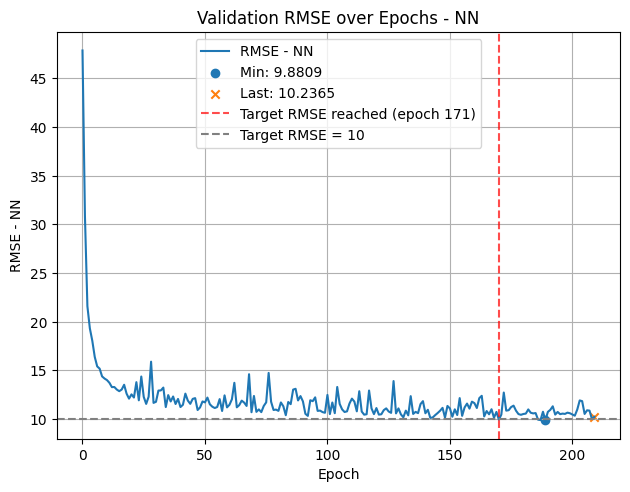

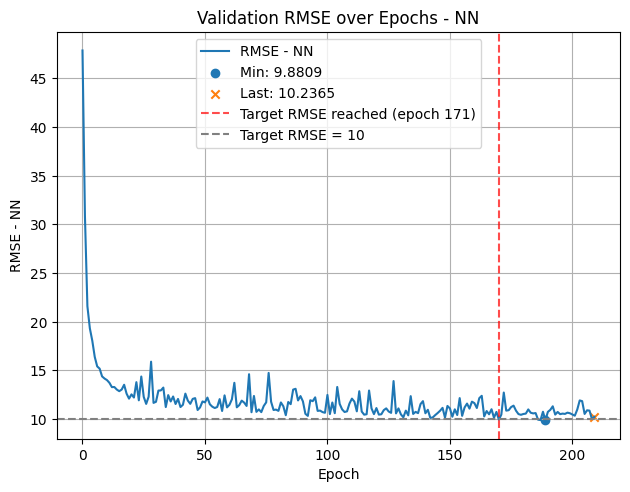

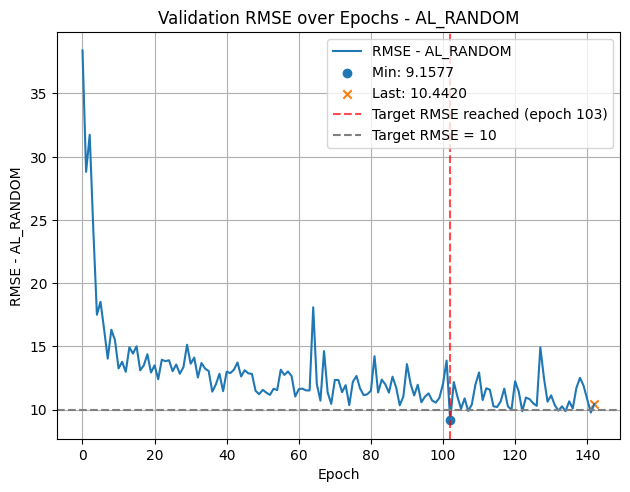

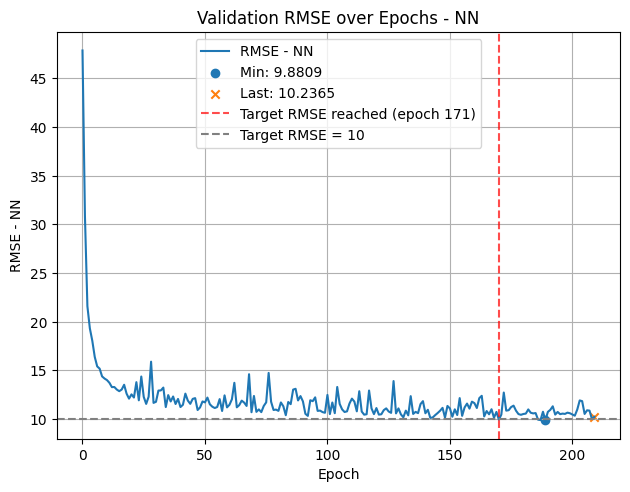

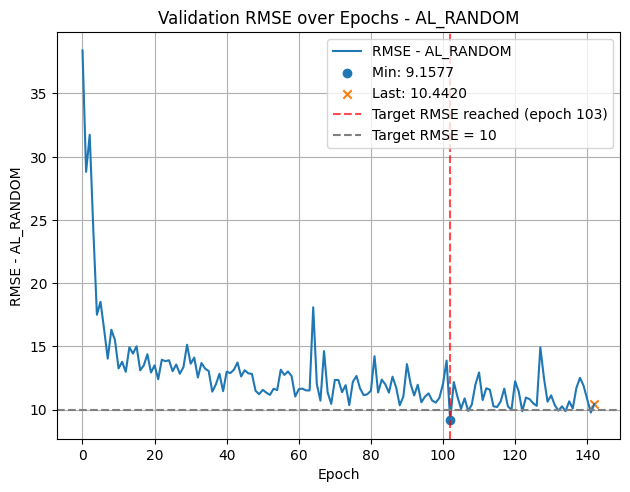

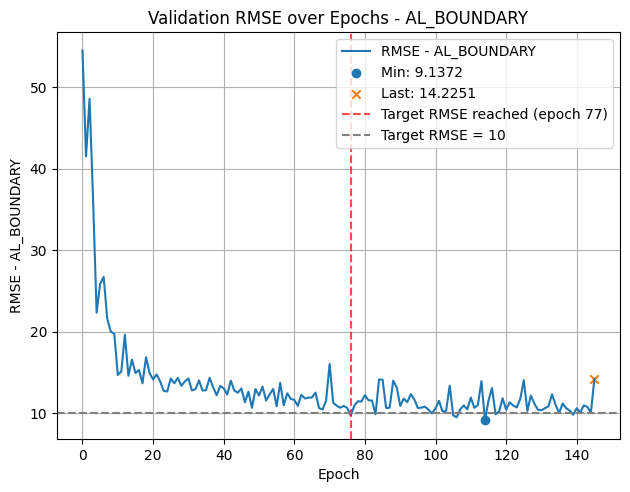

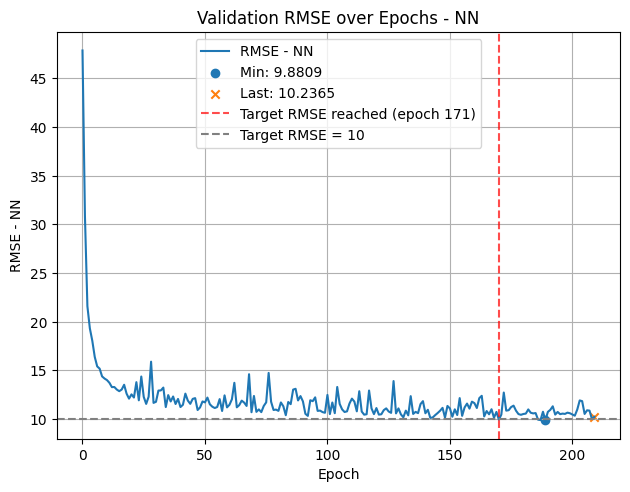

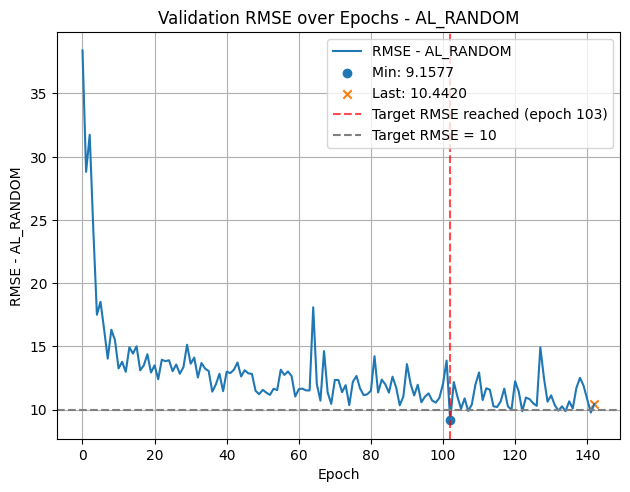

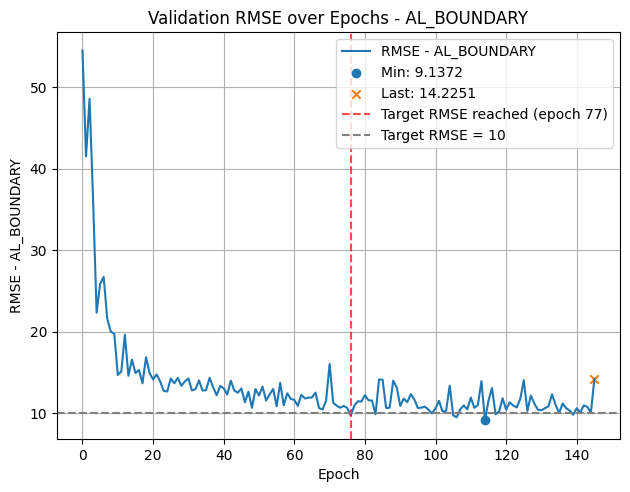

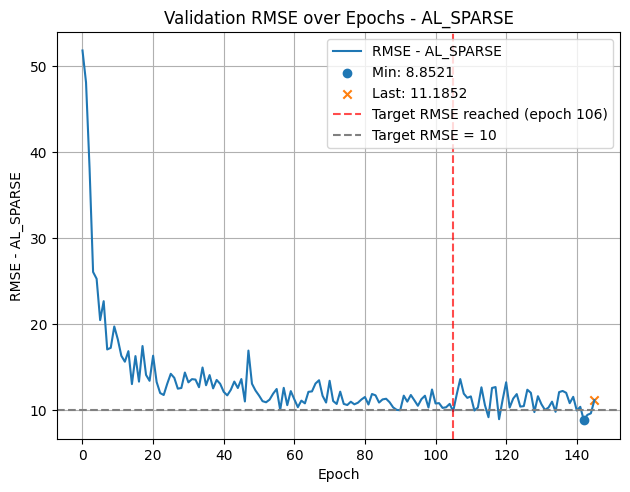

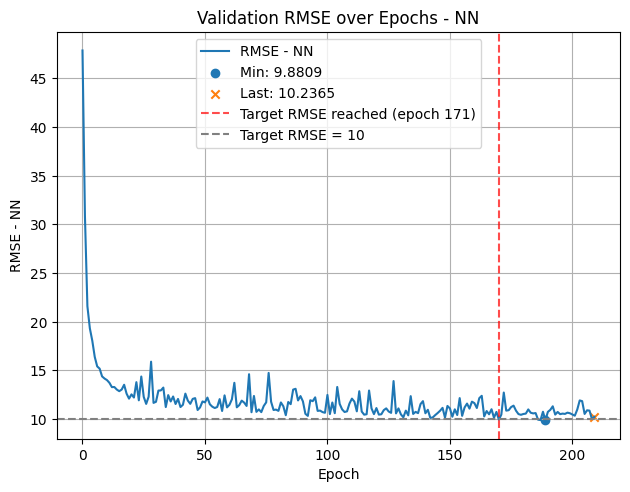

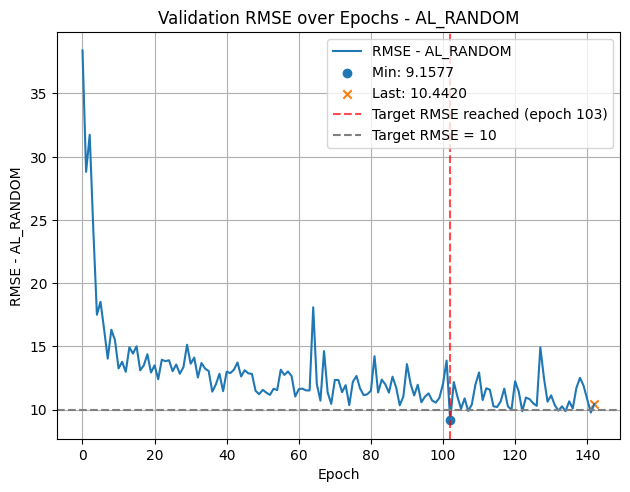

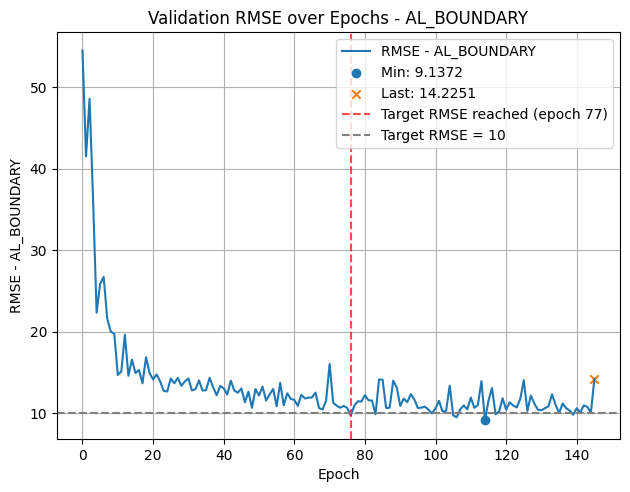

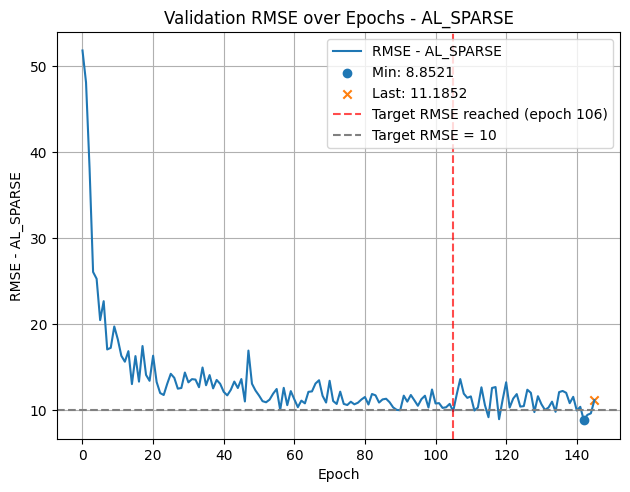

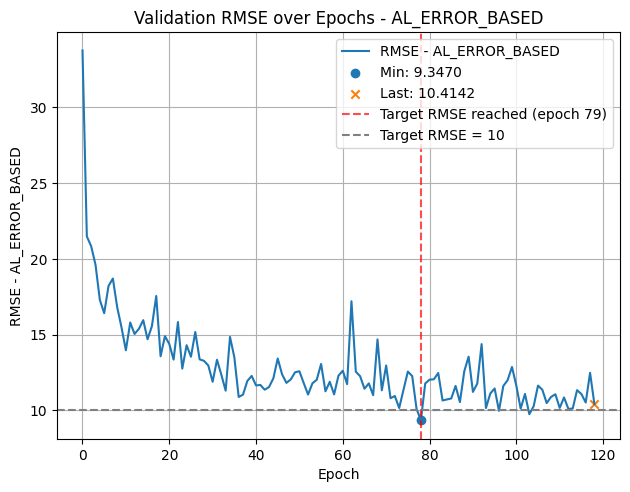

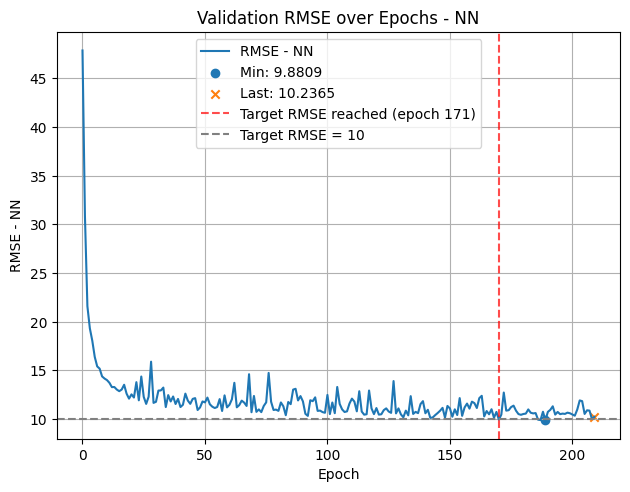

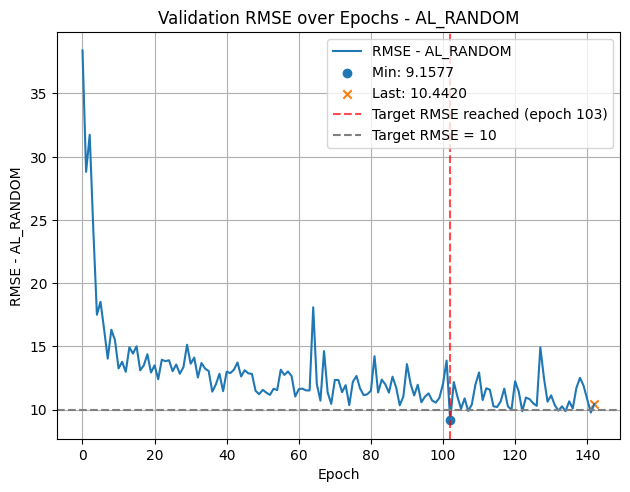

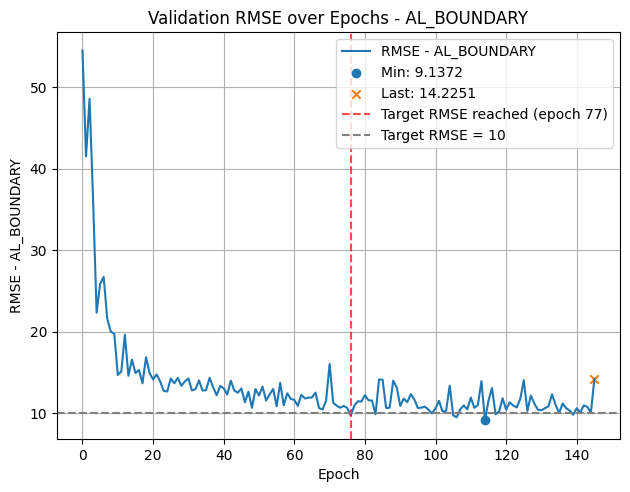

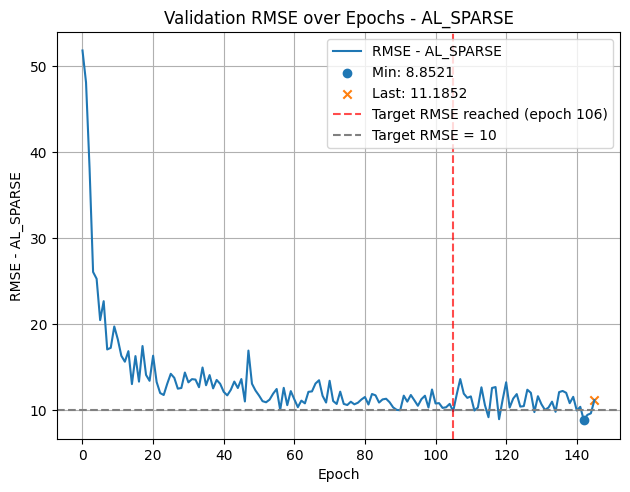

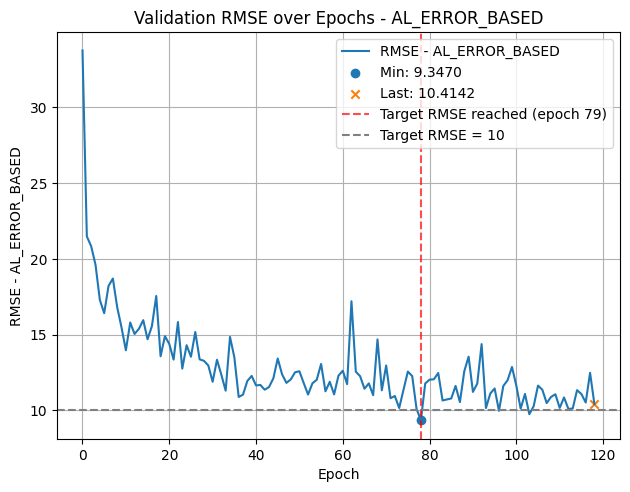

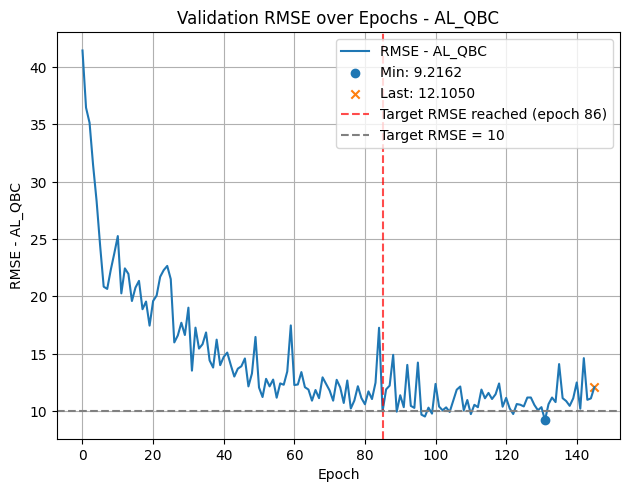

In [82]:
for info in model_info_values:
    plot_loss_curve(info['val_rmse'], label=f"RMSE - {info['name']}", title=f"Validation RMSE over Epochs - {info['name']}", target_rmse=target_rmse)


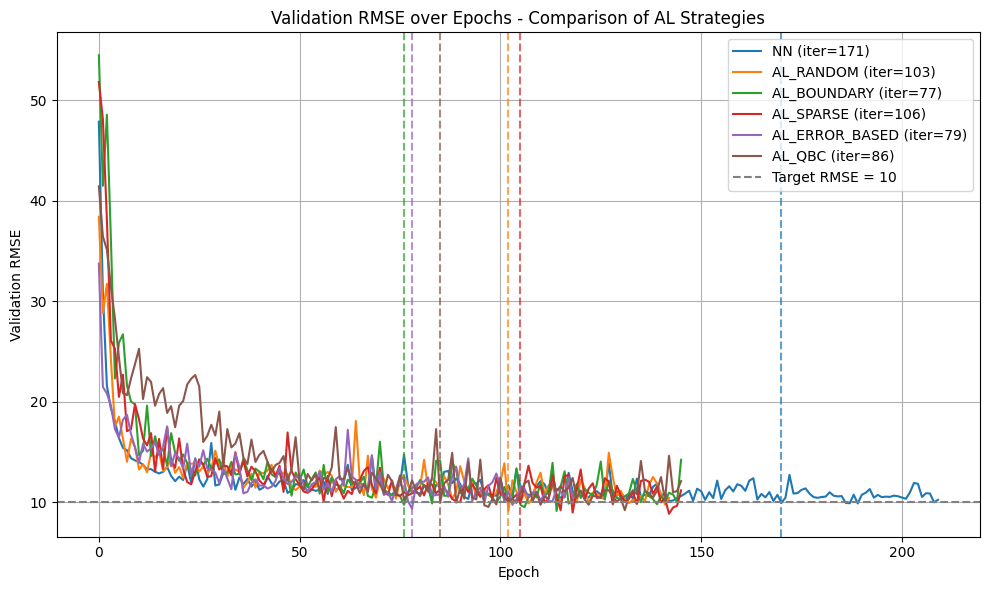

In [ ]:
plot_multiple_loss_curves(
    [info['val_rmse'] for info in model_info_values],
    labels=[info['name'] for info in model_info_values],
    title="Validation RMSE over Epochs - Comparison of AL Strategies",
    # exclude=["NN"]
    target_rmse=10
)

#### Ergebnis

| Model             | benötigte Iterationen | benötigte Datenmenge  |
| ----------------- | --------------------- | --------------------- |
| NN                |                   171 |                  5615 |
| AL_Random         |                   103 |                  3112 |
| AL_Boundary       |                    77 |                  2332 |
| AL_Sparse         |                   106 |                  3202 |
| AL_Error_based    |                    79 |                  2392 |
| AL_QBC            |                    86 |                  2602 |

Aus dieser Tabelle lässt sich ablesen, dass für das Erreichen der gleichen Modelleistung, wie ein neuronales Netz, das mit dem gesamten Trainingsdatensatz tainiert wurde, im besten Fall nur 2332 Datenpunkte notwendig waren. Im Schnitt werden nur 2728 Datenpunkte benötigt.

Insgesamt lässt sich sagen, dass man die Simulationsdauer für die Erstellung des Trainingsdatensatzes auf 48.58% (rund 50%) reduzieren kann. Dies ist ein erheblicher Vorteil, da die Simulation eines einzelnen Punktes in diesem Fall zwei bis drei Stunden dauert.

> Statt 14000 Stunden (etwa 1.6 Jahre) sind nur 6800 Stunden (etwa 9.3 Monate) Simulationszeit notwendig, um den Trainingsdatensatz zu erstellen.

#### Extra

In [ ]:
def lernkurven_stabilitaet(rmse_list, target=10, window=10):
    """
    Berechnet die Stabilität der Lernkurve:
    - Mittelwert und Standardabweichung der letzten `window` Iterationen vor dem ersten Unterschreiten von `target`
    - Mittelwert und Standardabweichung aller Iterationen ab dem ersten Unterschreiten von `target`
    - Mittelwert und Standardabweichung über das gesamte Zeitfenster (`window` vor und alle nach dem ersten Unterschreiten)

    Parameter
    ---------
    rmse_list : list oder np.ndarray
        Liste der RMSE-Werte pro Iteration/Epoch.
    target : float
        Zielwert, z.B. 10.
    window : int
        Anzahl der Iterationen vor dem ersten Unterschreiten.

    Rückgabe
    --------
    dict mit Mittelwert und Std für beide Bereiche und das Gesamtzeitfenster.
    """
    rmse_arr = np.array(rmse_list)
    idx_below = np.where(rmse_arr < target)[0]
    if len(idx_below) == 0:
        raise ValueError("Kein RMSE unterhalb des Zielwerts gefunden.")
    idx_first = idx_below[0]
    idx_start = max(0, idx_first - window)
    before = rmse_arr[idx_start:idx_first]
    after = rmse_arr[idx_first:]
    window_all = rmse_arr[idx_start:]  # window vor + alles nach target

    result = {
        "vor_target_mean": before.mean() if len(before) > 0 else np.nan,
        "vor_target_std": before.std() if len(before) > 0 else np.nan,
        "nach_target_mean": after.mean(),
        "nach_target_std": after.std(),
        "gesamt_window_mean": window_all.mean(),
        "gesamt_window_std": window_all.std(),
        "idx_first_below_target": idx_first,
        "n_after": len(after),
        "n_before": len(before),
        "n_gesamt_window": len(window_all)
    }
    return result

In [ ]:
for info in model_info_values:
    stability = lernkurven_stabilitaet(info['val_rmse'], target=target_rmse, window=10)
    print(f"{info['name']}: {stability}")

NN: {'vor_target_mean': np.float64(11.078627586364746), 'vor_target_std': np.float64(0.7255908827430951), 'nach_target_mean': np.float64(10.721547293663026), 'nach_target_std': np.float64(0.5514029001163788), 'gesamt_window_mean': np.float64(10.792963352203369), 'gesamt_window_std': np.float64(0.607399017202971), 'idx_first_below_target': np.int64(170), 'n_after': 40, 'n_before': 10, 'n_gesamt_window': 50}
AL_RANDOM: {'vor_target_mean': np.float64(11.406502393077227), 'vor_target_std': np.float64(0.957606573285922), 'nach_target_mean': np.float64(10.954364286274526), 'nach_target_std': np.float64(1.0761649918399314), 'gesamt_window_mean': np.float64(11.043018817020155), 'gesamt_window_std': np.float64(1.0691477816325752), 'idx_first_below_target': np.int64(102), 'n_after': 41, 'n_before': 10, 'n_gesamt_window': 51}
AL_BOUNDARY: {'vor_target_mean': np.float64(11.558268963857977), 'vor_target_std': np.float64(1.5971478954088358), 'nach_target_mean': np.float64(11.192378689067626), 'nach_

### **Performanz**

Gemessen wird die Performanz nur anhand von **RMSE** und **MAE**. Während MAE die durchschnittliche absolute Abweichung misst, gewichtet der RMSE größere Fehler stärker aufgrund der quadrierten Fehlerterme. Dadurch reagiert der RMSE sensibler auf Ausreißer.

Anschließend werden pro Modell und Strategie die Vorhersagen mit den tatsächlichen Werten gegenübergestellt.

#### Helper Functions

In [84]:
def min_rmse_and_mae(rmse_list, mae_list):
    """
    Returns the minimum RMSE and the corresponding MAE from two lists.

    Parameters
    ----------
    rmse_list : list or array-like
        List of RMSE values.
    mae_list : list or array-like
        List of MAE values (same length as rmse_list).

    Returns
    -------
    min_rmse : float
        Minimum RMSE value.
    corresponding_mae : float
        MAE value at the same index as min_rmse.
    min_idx : int
        Index of the minimum RMSE.
    """
    rmse_arr = np.array(rmse_list)
    mae_arr = np.array(mae_list)
    min_idx = np.argmin(rmse_arr)
    return rmse_arr[min_idx], mae_arr[min_idx], min_idx

In [85]:
def compute_rmse_mae(model, X_test, y_test, feature_scaler=None, target_scaler=None, device=DEVICE):
    """
    Computes RMSE and MAE for a model on a test set.

    Parameters
    ----------
    model : torch.nn.Module
        Trained model.
    X_test : np.ndarray or torch.Tensor
        Test features (unscaled).
    y_test : np.ndarray or torch.Tensor
        Test targets (unscaled).
    feature_scaler : sklearn scaler or None
        Scaler used for the feature variables. If provided, X_test will be transformed before prediction.
    target_scaler : sklearn scaler or None
        Scaler used for the target variable (for inverse transform). Should be None if y_test is unscaled.
    device : torch.device
        Device to run evaluation on.

    Returns
    -------
    rmse : float
        Root Mean Squared Error.
    mae : float
        Mean Absolute Error.
    """
    model.eval()
    # Scale features if scaler is provided
    if feature_scaler is not None:
        X_test_proc = feature_scaler.transform(X_test)
    else:
        X_test_proc = X_test
    # Convert to tensor if needed
    if not isinstance(X_test_proc, torch.Tensor):
        X_test_t = torch.tensor(X_test_proc, dtype=torch.float32).to(device)
    else:
        X_test_t = X_test_proc.to(device)
    with torch.no_grad():
        preds = model(X_test_t).cpu().numpy().reshape(-1, 1)
    # Convert y_test to numpy array if needed
    if isinstance(y_test, torch.Tensor):
        actuals = y_test.cpu().numpy().reshape(-1, 1)
    else:
        actuals = np.array(y_test).reshape(-1, 1)
    # Inverse transform predictions if scaler is provided
    if target_scaler is not None:
        preds = target_scaler.inverse_transform(preds).ravel()
    else:
        preds = preds.ravel()
    actuals = actuals.ravel()  # y_test is assumed to be in original units
    rmse = root_mean_squared_error(actuals, preds)
    mae = mean_absolute_error(actuals, preds)
    return rmse, mae

In [86]:
def compute_estimErr_rmse_mae(y_test, estim_err):
    """
    Computes the absolute RMSE and MAE of estimErr using y_test as reference.

    Parameters
    ----------
    y_test : np.ndarray
        True target values (ground truth, shape (N,) or (N,1)).
    estim_err : np.ndarray
        Estimated errors (same shape as y_test).

    Returns
    -------
    rmse : float
        Root Mean Squared Error between estimErr and y_test.
    mae : float
        Mean Absolute Error between estimErr and y_test.
    """
    estim_err = y_test - estim_err
    y_test = np.asarray(y_test).ravel()
    estim_err = np.asarray(estim_err).ravel()
    rmse = np.sqrt(np.mean((estim_err - y_test) ** 2))
    mae = np.mean(np.abs(estim_err - y_test))
    return rmse, mae

In [91]:
def get_highest_errors_with_estimErr(
    model, X_test, y_test, estim_err, feature_scaler=None, target_scaler=None, device=DEVICE, top_n=10
):
    """
    Returns the indices, absolute errors, predictions, actuals, and estimErr for the top_n highest errors.

    Parameters
    ----------
    model : torch.nn.Module
        Trained model.
    X_test : np.ndarray or torch.Tensor
        Test features (unscaled).
    y_test : np.ndarray or torch.Tensor
        Test targets (unscaled).
    estim_err : np.ndarray
        MD error estimates (same order as y_test).
    feature_scaler : sklearn scaler or None
        Scaler for features (if needed).
    target_scaler : sklearn scaler or None
        Scaler for targets (for inverse transform).
    device : torch.device
        Device for model.
    top_n : int
        Number of highest errors to return.

    Returns
    -------
    indices : np.ndarray
        Indices of the top_n highest errors (sorted descending).
    errors : np.ndarray
        Corresponding absolute errors (sorted descending).
    preds : np.ndarray
        Model predictions (original scale).
    actuals : np.ndarray
        True values (original scale).
    estim_errs : np.ndarray
        estimErr values for these points.
    """
    model.eval()
    with np.errstate(divide='ignore', over='ignore', invalid='ignore'):
        # Scale features if needed
        if feature_scaler is not None:
            X_test_proc = feature_scaler.transform(X_test)
        else:
            X_test_proc = X_test
        # To tensor
        if not isinstance(X_test_proc, torch.Tensor):
            X_test_t = torch.tensor(X_test_proc, dtype=torch.float32).to(device)
        else:
            X_test_t = X_test_proc.to(device)
        with torch.no_grad():
            preds = model(X_test_t).cpu().numpy().reshape(-1, 1)
        # True values
        if isinstance(y_test, torch.Tensor):
            actuals = y_test.cpu().numpy().reshape(-1, 1)
        else:
            actuals = np.array(y_test).reshape(-1, 1)
        # Inverse transform if needed
        if target_scaler is not None:
            preds = target_scaler.inverse_transform(preds).ravel()
        else:
            preds = preds.ravel()
        actuals = actuals.ravel()
        # Compute absolute errors
        errors = np.abs(preds - actuals)
        # Get top_n indices
        top_idx = np.argsort(errors)[-top_n:][::-1]
        return top_idx, errors[top_idx], preds[top_idx], actuals[top_idx], np.asarray(estim_err)[top_idx]

In [101]:
def plot_k_nearest_neighbors_density(
    X, y, density_value, k=5, features=None, figsize=(10, 6), marker_size=100
):
    """
    Finds the sample with the closest density to `density_value`, then finds the k nearest neighbors
    in feature space to this sample, and plots their density values (not just their feature positions).

    Parameters
    ----------
    X : np.ndarray
        Feature matrix (N_samples, N_features).
    y : np.ndarray
        Target density values (N_samples,).
    density_value : float
        The density value to find neighbors for.
    k : int
        Number of nearest neighbors to plot.
    features : list or None
        List of feature names for axis labels. If None, uses indices.
    figsize : tuple
        Figure size for the plot.
    marker_size : int
        Size of the scatter plot markers.
    """
    import matplotlib.patches as mpatches

    with np.errstate(divide='ignore', over='ignore', invalid='ignore'):
        X = np.asarray(X)
        y = np.asarray(y).ravel()

        # Find the index of the sample closest to the given density value
        idx_center = np.argmin(np.abs(y - density_value))
        x_center = X[idx_center]

        # Compute distances in feature space to all other points
        dists = pairwise_distances(X, x_center.reshape(1, -1)).ravel()
        # Exclude the center itself, then get k nearest neighbors (in feature space)
        neighbor_indices = np.argsort(dists)[1 : k + 1]

        plt.figure(figsize=figsize)
        # Plot all densities as a smooth line for context
        sorted_idx = np.argsort(y)
        plt.plot(np.arange(len(y)), y[sorted_idx], color='lightgray', lw=2, alpha=0.7, zorder=1, label='All densities (sorted)')
        # Plot all points as faint dots
        plt.scatter(np.arange(len(y)), y, c='lightgray', s=marker_size * 0.4, alpha=0.3, zorder=1)

        # Highlight k nearest neighbors
        plt.scatter(
            neighbor_indices, y[neighbor_indices],
            c='tab:orange', s=marker_size, edgecolor='black', linewidth=1.5, zorder=3,
            label=f'{k} Nächste Nachbarn'
        )
        # Draw lines from center to neighbors
        for ni in neighbor_indices:
            plt.plot([idx_center, ni], [y[idx_center], y[ni]], color='tab:orange', lw=1.5, alpha=0.5, zorder=2)

        # Highlight center point
        plt.scatter(
            idx_center, y[idx_center],
            c='crimson', s=marker_size * 1.4, edgecolor='black', linewidth=2, zorder=4,
            label=f'Zentrum (Dichte={y[idx_center]:.2f})'
        )

        plt.xlabel('Sample Index', fontsize=13)
        plt.ylabel('Dichte', fontsize=13)
        plt.title(
            f"{k} Nächste Nachbarn im Merkmalsraum (Dichte)\nZentrum: Dichte={y[idx_center]:.2f}",
            fontsize=15, pad=15
        )
        plt.legend(fontsize=12, frameon=True)
        plt.grid(True, linestyle='--', alpha=0.4)
        plt.tight_layout()
        plt.show()

        return idx_center, neighbor_indices, y[neighbor_indices]

#### Evaluation

In [87]:
rmse, mae = compute_estimErr_rmse_mae(y_test, estim_err_test)
print("estimErr RMSE:", rmse)
print("estimErr MAE:", mae)

estimErr RMSE: 9.70872108591667
estimErr MAE: 5.768445262096774


In [88]:
for info in model_info_values:
    model = RegressionNet(4).to(DEVICE)
    model_name = info["name"]
    model = info["model"]
    rmse, mae = compute_rmse_mae(model, X_test, y_test, feature_scaler=info["feature_scaler"], target_scaler=info["target_scaler"], device=DEVICE)
    print(f"{model_name}: RMSE={rmse:.4f}, MAE={mae:.4f}")

NN: RMSE=16.4430, MAE=7.7257
AL_RANDOM: RMSE=15.9029, MAE=7.4701
AL_BOUNDARY: RMSE=15.5858, MAE=7.5482
AL_SPARSE: RMSE=15.2466, MAE=7.0173
AL_ERROR_BASED: RMSE=16.5066, MAE=7.3493
AL_QBC: RMSE=15.6076, MAE=7.4846


#### Ergebnis 1

| Methode           | RMSE          | MAE           |
| ----------------- | ------------- | ------------- |
| NN (klassisch)    | 16.4430       | 7.7257        |
| AL_RANDOM         | 15.9029       | 7.4701        |
| AL_BOUNDARY       | 15.5858       | 7.5482        |
| AL_SPARSE         | **15.2466**   | **7.0173**    |
| AL_ERROR_BASED    | 16.5066       | 7.3493        |
| AL_QBC            | 15.6076       | 7.4846        |

Zum Vergleich beträgt die inhärente Unsicherheit der MD-Simulation:

- RMSE: 9.7087

- MAE: 5.7684

---

#### Interpretation

1. Vergleich der Active-Learning Strategien

    - Sparse Sampling zeigt die beste Gesamtperformanz

    - Die meisten AL Strategien schneiden leicht besser ab, als das klassische NN-Training

    - Error-based Sampling liefert hingegen keinen Vorteil gegenüber dem Basismodell. Dies lässt sich vermutlich durch Ausreißer erklären. (Später mehr.)

2. Einordnung relativ zur Simulationsunsicherheit

    Alle Modellvarianten liegen mit ihren Fehlern deutlich oberhalb der estimErr-Werte:

    - RMSE der Modelle: 15-16
    
    - RMSE der Simulation: 9.7

    Das bedeutet, dass das Modell noch nicht die Größenordnung der Simulationsunsicherheit erreicht. Gleichzeitig definiert `estimErr` eine Art untere sinnvolle Fehlergrenze. Selbst ein perfektes Modell könnte realistisch betrachtet keinen Fehler deutlich unterhalb dieser Unsicherheit erreichen.


#### Actual vs Predicted Density

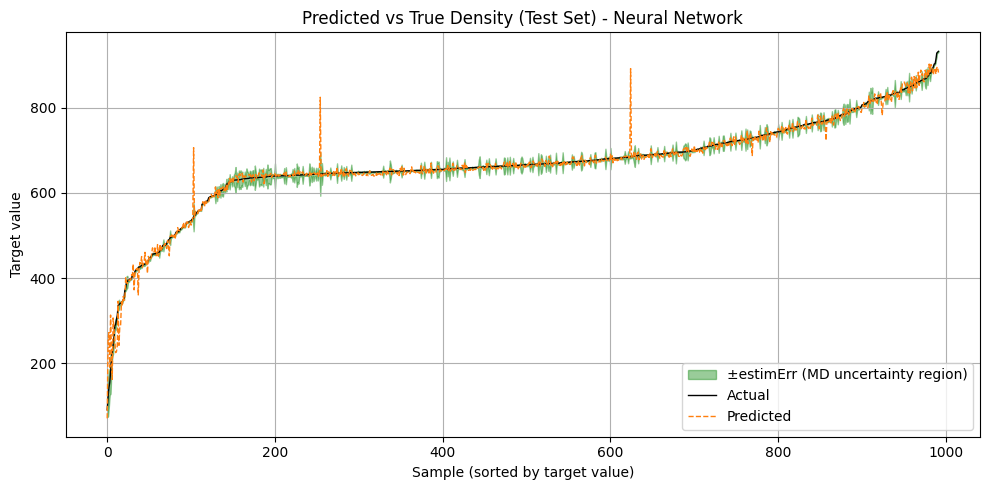

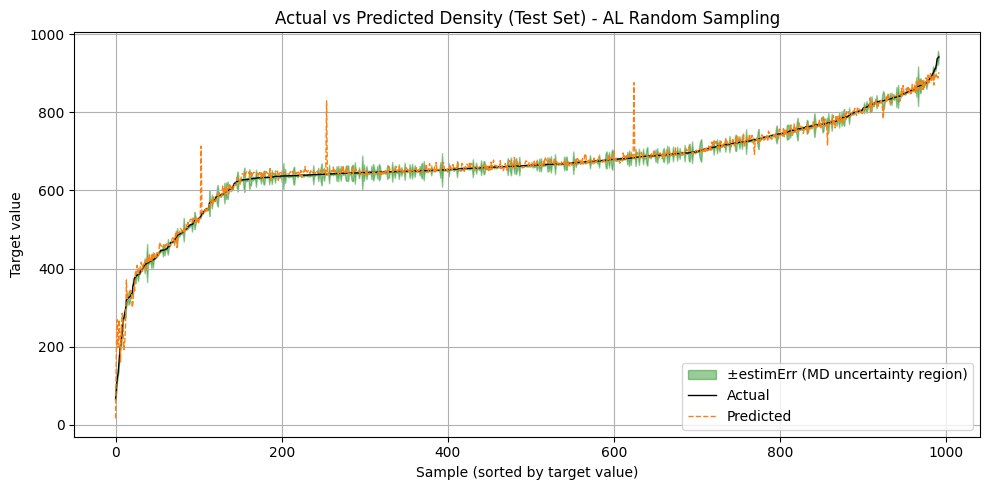

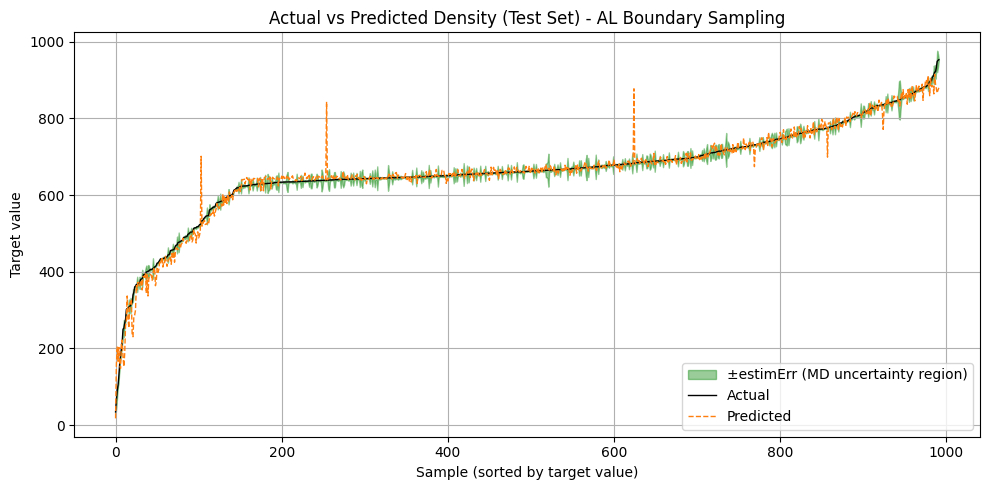

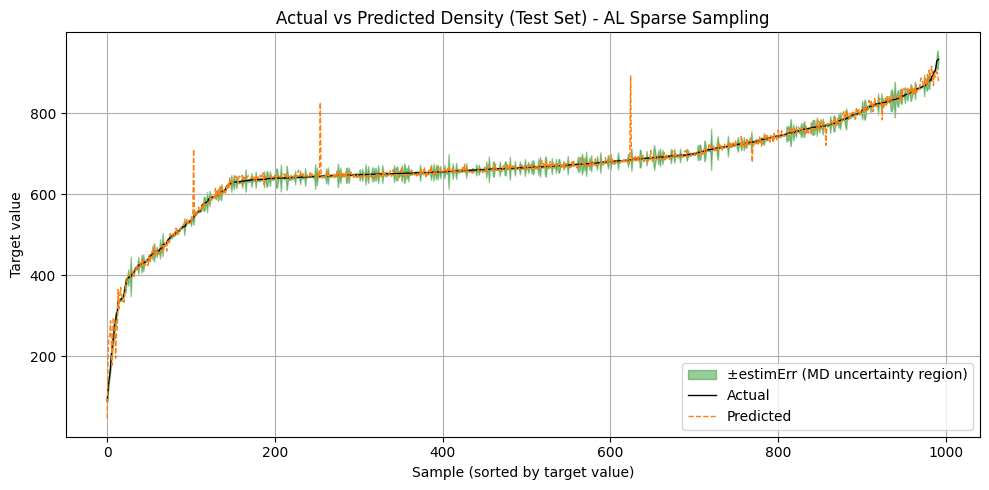

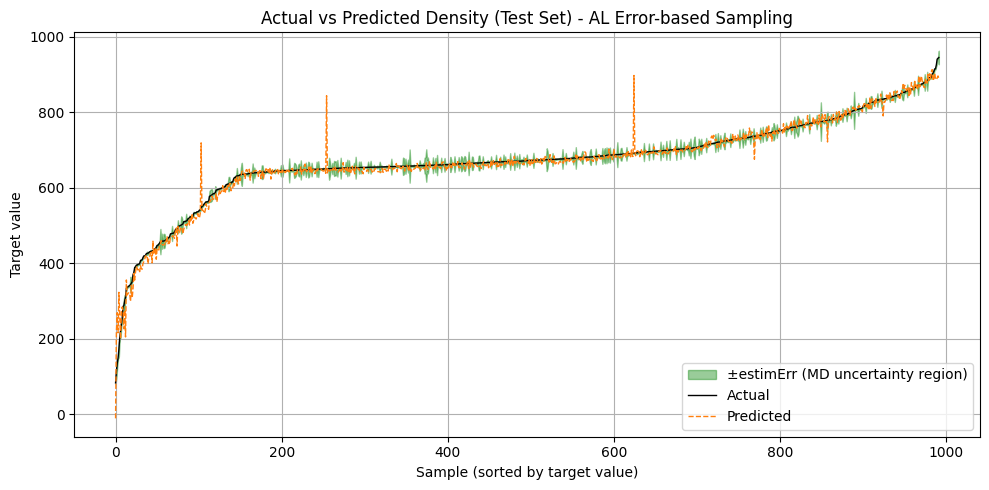

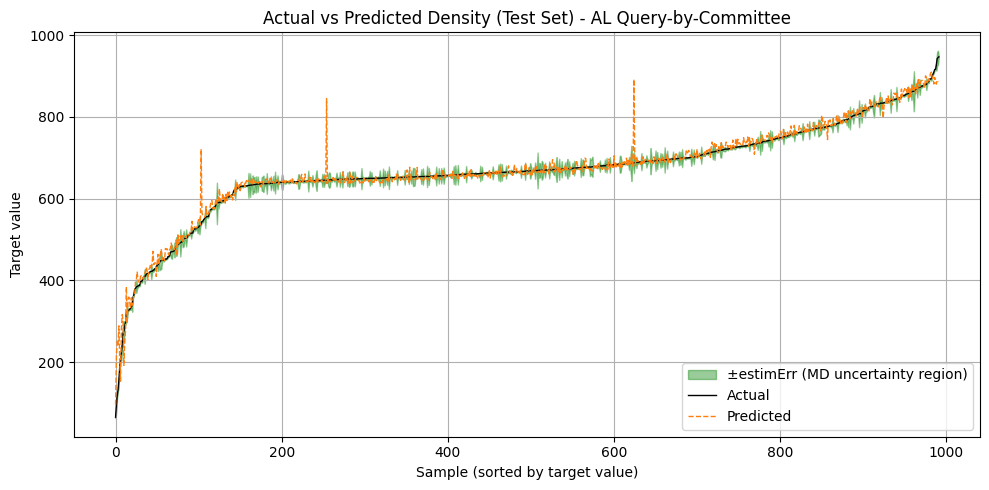

In [ ]:
test_loader_random = get_dataloader(X_test_scaled_al_random, y_test_scaled_al_random)
test_loader_boundary = get_dataloader(X_test_scaled_al_boundary, y_test_scaled_al_boundary)
test_loader_sparse = get_dataloader(X_test_scaled_al_sparse, y_test_scaled_al_sparse)
test_loader_error_based = get_dataloader(X_test_scaled_al_error_based, y_test_scaled_al_error_based)
test_loader_qbc = get_dataloader(X_test_scaled_al_qbc, y_test_scaled_al_qbc)

plot_actual_vs_predicted_with_estimErr(
    BEST_NN,
    test_loader_nn,
    y_scaler=target_scaler_nn,
    estim_err=estim_err_test,
    title="Predicted vs True Density (Test Set) - Neural Network"
)

plot_actual_vs_predicted_with_estimErr(
    BEST_AL_RANDOM,
    test_loader_random,
    y_scaler=target_scaler_al_random_best_model,
    estim_err=estim_err_test,
    title="Actual vs Predicted Density (Test Set) - AL Random Sampling"
)

plot_actual_vs_predicted_with_estimErr(
    BEST_AL_BOUNDARY,
    test_loader_boundary,
    y_scaler=target_scaler_al_boundary_best_model,
    estim_err=estim_err_test,
    title="Actual vs Predicted Density (Test Set) - AL Boundary Sampling"
)

plot_actual_vs_predicted_with_estimErr(
    BEST_AL_SPARSE,
    test_loader_sparse,
    y_scaler=target_scaler_al_sparse_best_model,
    estim_err=estim_err_test,
    title="Actual vs Predicted Density (Test Set) - AL Sparse Sampling"
)

plot_actual_vs_predicted_with_estimErr(
    BEST_AL_ERROR_BASED,
    test_loader_error_based,
    y_scaler=target_scaler_al_error_based_best_model,
    estim_err=estim_err_test,
    title="Actual vs Predicted Density (Test Set) - AL Error-based Sampling"
)

plot_actual_vs_predicted_with_estimErr(
    BEST_AL_QBC,
    test_loader_qbc,
    y_scaler=target_scaler_al_qbc_best_model,
    estim_err=estim_err_test,
    title="Actual vs Predicted Density (Test Set) - AL Query-by-Committee"
)

In [94]:
info = model_info_values[4]  # or select by name: next(i for i in model_info_values if i['name'] == 'NN')

top_idx, errors, preds, actuals, estims = get_highest_errors_with_estimErr(
    model=info['model'],
    X_test=X_test,
    y_test=y_test,
    estim_err=estim_err_test,
    feature_scaler=info['feature_scaler'],
    target_scaler=info['target_scaler'],
    device=DEVICE,
    top_n=10
)

# print("Indices:", top_idx)
print("Absolute Errors:", errors)
print("Predictions:", preds)
print("Actuals:", actuals)
print("estimErr:", estims)

Absolute Errors: [205.63667627 182.76510937 165.55111035 164.09987231 140.64137378
 127.4340249   96.41847046  94.02866834  83.51305029  74.1137478 ]
Predictions: [890.8807    827.1621    708.4381    341.53787   282.63937   246.53802
 215.28653    -3.3637683 237.71405   281.72275  ]
Actuals: [685.244  644.397  542.887  177.438  141.998  119.104  311.705   90.6649
 154.201  207.609 ]
estimErr: [ 3.6 51.  33.  49.  43.  44.   4.6 17.  29.  24. ]


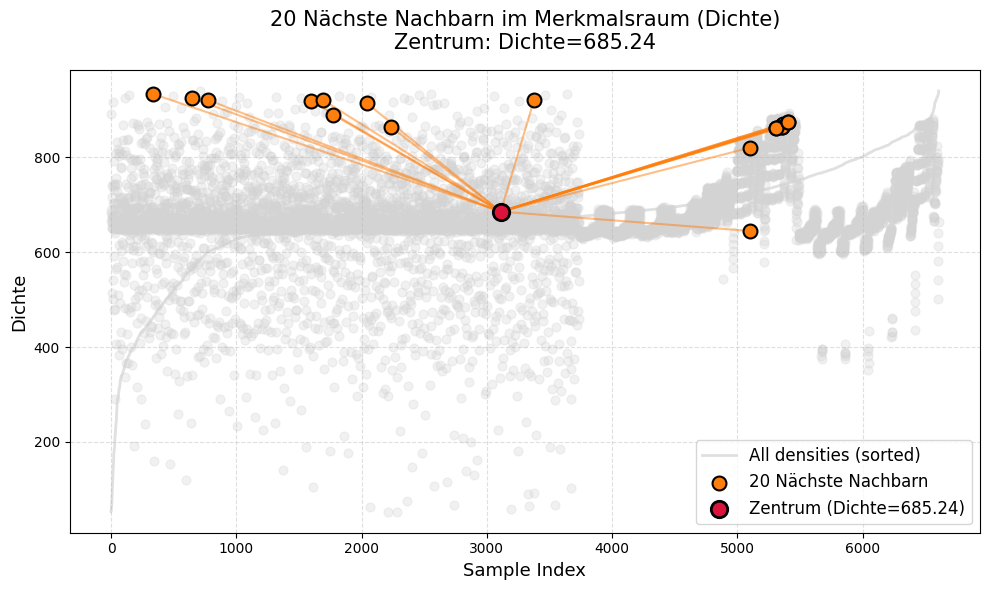

Mean of neighbor densities of 685.244: 873.4104000000001


In [110]:
center, idx, val = plot_k_nearest_neighbors_density(X, y, density_value=685.244, k=20)
print(f"Mean of neighbor densities of 685.244: {val.mean()}")

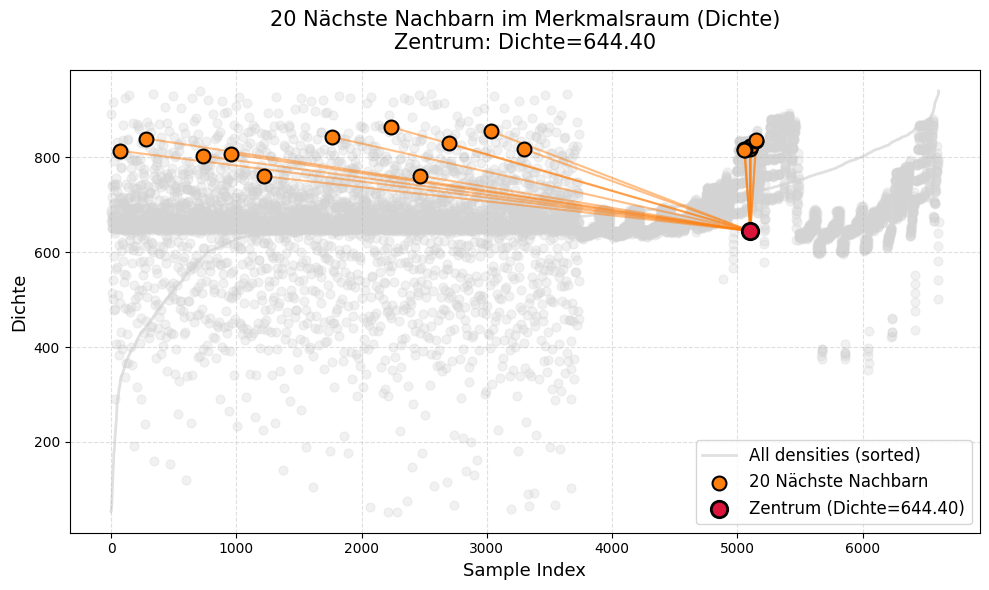

Mean of neighbor densities of 644.397: 819.568


In [111]:
center, idx, val = plot_k_nearest_neighbors_density(X, y, density_value=644.397, k=20)
print(f"Mean of neighbor densities of 644.397: {val.mean()}")

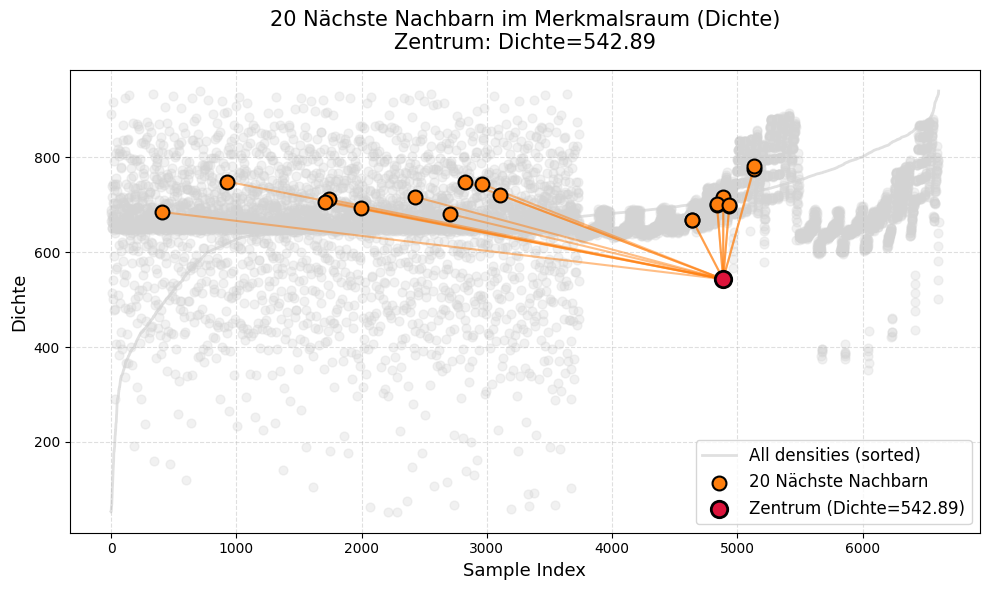

Mean of neighbor densities of 542.887: 713.33215


In [112]:
center, idx, val = plot_k_nearest_neighbors_density(X, y, density_value=542.887, k=20)
print(f"Mean of neighbor densities of 542.887: {val.mean()}")

#### Ergebnis 2

Für jede Strategie wurde zusätzlich ein Actual vs. Predicted Plot erstellt.

Dabei gelten:

- Idealfall: Punkte liegen auf der Linie "Actual" --> $y = \hat{y}$

- Streuung um die "Actual"-Linie entspricht der Modellvorhersage

- Grüne Fläche visualisiert den Bereich +- `estimErr`

Diese grüne Zone stellt den Bereich dar, in dem die Vorhersage unter Berücksichtigung der Simulationsunsicherheit als physikalisch konsistent betrachtet werden kann.

---

#### Interpretation

- Punkte innerhalb der grünen Fläche --> Fehler in Größenordnung der Simulation

- Punkte außerhalb --> zusätzlicher Modellfehler

Insgesamt ist die Richtung der Modellvorhersagen sehr gut. Zwischen den Modellen lassen sich nur wenige Unterschiede erkennen. Die Modellvorhersage kann insgesamt als gut bezeichnet werden, da die Streuung insgesamt eher gering ausfällt. Für genauere Aussagen werden im nächsten Schritt die Fehler im Bezug zur Modellunsicherheit betrachtet.

Die drei Peaks lassen sich durch k-nearest-Neighbour erklären. Die ähnlichsten Parameter führen zu sehr unterschiedlichen Dichte-Werten, wodurch das Modell bei diesem Parameterraum eine höhere Dichte vorhersagt.

### **Bewertung unter Berücksichtigung der Modellunsicherheit**

Neben der reinen Fehlerbetrachtung (RMSE, MAE) ist es entscheidend, den Modellfehler im Kontext der natürlichen Unsicherheit der MD-Simulation (`estimErr`) zu interpretieren.

Da die Referenzdaten selbst eine statistische Streuung besitzen, ist nicht jeder beobachtete Fehler automatisch als Modellversagen zu werten. Deshalb werden zwei zusätzliche Kennzahlen betrachtet:

- Coverage

- r (Fehlerverhältnis zur natürlichen Unsicherheit)

In diesem Abschnitt wird die zentrale Frage beantwortet, ob die Modelle innerhalb der natürlichen Schwankungen der Simulation liegt.

#### **Coverage**

Die Coverage misst den Anteil der Vorhersagen, die innerhalb des Unsicherheitsintervalls der Simulation liegen.

- Hohe Coverage: Ein großer Anteil der Vorhersagen ist mit der Simulationsunsicherheit vereinbar.

- Niedrige Coverage: Das Modell erzeugt Fehler, die über die natürliche Streuung hinausgehen.

Coverage beschreibt somit:

> Wie viele Vorhersagen liegen innerhalb des physikalisch erwartbaren Schwankungsbereichs?

---

Für jeden Testpunkt $i$:

1. Modellfehler:

$$
\text{error}_i = ​| \hat{y}_i - y_i |
$$

2. Vergliech mit MD-Schwankung:

$$
\text{within\_MD}_i =
\begin{cases}
1 & \text{wenn } \text{error}_i < \text{estimErr}_i \\\\
0 & \text{sonst}
\end{cases}
$$

3. Gesamtbewertung:

$$
\text{Coverage}_{\text{MD}} = \frac{1}{N} \sum_{i} \text{within\_MD}_i
$$

In [ ]:
def compute_coverage_md(
    model,
    X_test,
    y_test,
    estim_err,
    feature_scaler=None,
    target_scaler=None,
    device=DEVICE
):
    """
    Berechnet Coverage@MD für ein Modell auf dem Test-Set.

    Parameters
    ----------
    model : torch.nn.Module
        Trainiertes Modell.
    X_test : np.ndarray oder torch.Tensor
        Test-Features (unskaliert).
    y_test : np.ndarray oder torch.Tensor
        Test-Targets (unskaliert).
    estim_err : np.ndarray
        MD-Schwankungen (gleiche Reihenfolge wie Test-Set).
    feature_scaler : sklearn Scaler oder None
        Skaler für die Features.
    target_scaler : sklearn Scaler oder None
        Skaler für das Target (für inverse Transformation).
    device : torch.device
        Device für das Modell.

    Returns
    -------
    coverage_md : float
        Anteil der Testpunkte, bei denen der Modellfehler kleiner als die MD-Schwankung ist.
    within_md : np.ndarray
        Binäres Array (1/0) pro Testpunkt.
    errors : np.ndarray
        Absoluter Modellfehler pro Testpunkt.
    """
    model.eval()
    # Features skalieren
    if feature_scaler is not None:
        X_test_proc = feature_scaler.transform(X_test)
    else:
        X_test_proc = X_test
    # Zu Tensor konvertieren
    if not isinstance(X_test_proc, torch.Tensor):
        X_test_t = torch.tensor(X_test_proc, dtype=torch.float32).to(device)
    else:
        X_test_t = X_test_proc.to(device)
    with torch.no_grad():
        preds = model(X_test_t).cpu().numpy().reshape(-1, 1)
    # Targets zu numpy
    if isinstance(y_test, torch.Tensor):
        actuals = y_test.cpu().numpy().reshape(-1, 1)
    else:
        actuals = np.array(y_test).reshape(-1, 1)
    # Inverse transform predictions falls nötig
    if target_scaler is not None:
        preds = target_scaler.inverse_transform(preds).ravel()
    else:
        preds = preds.ravel()
    actuals = actuals.ravel()
    # Fehler berechnen
    errors = np.abs(preds - actuals)
    estim_err = np.asarray(estim_err).ravel()
    # within_MD berechnen
    within_md = (errors < estim_err).astype(int)
    coverage_md = np.mean(within_md)
    
    return coverage_md, within_md, errors

In [ ]:
for model_name, (model_path, feature_scaler, target_scaler) in to_evaluate.items():
    model = RegressionNet(4).to(DEVICE)
    model.load_state_dict(torch.load(model_path))
    coverage_md, within_md, absolute_errors = compute_coverage_md(
        model=model,
        X_test=X_test,
        y_test=y_test,
        estim_err=estim_err_test,
        feature_scaler=feature_scaler,
        target_scaler=target_scaler,
        device=DEVICE
    )
    print(f"{model_name}: Coverage={coverage_md:.4f}")

NN: Coverage=0.3891
AL_RANDOM: Coverage=0.3901
AL_BOUNDARY: Coverage=0.3740
AL_SPARSE: Coverage=0.4002
AL_ERROR_BASED: Coverage=0.4002
AL_QBC: Coverage=0.3931


##### Step Size = 50

Betrachtung der Coverage in feineren 50-er Schritten auf der `density`.

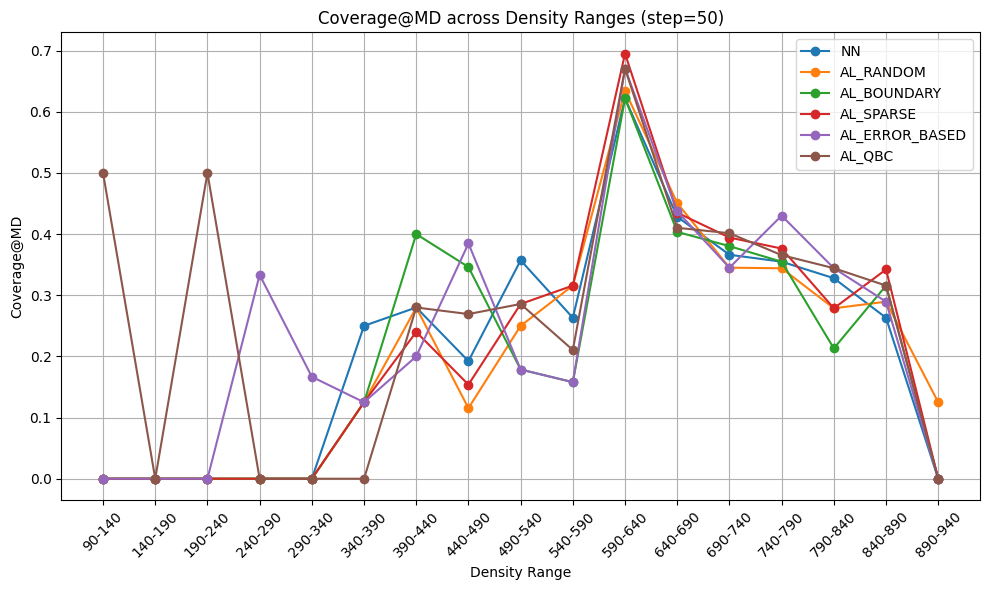

In [ ]:
step = 50
y_min = int(np.floor(y_test.min()))
y_max = int(np.ceil(y_test.max()))

coverage_results = {model_name: [] for model_name in to_evaluate.keys()}
density_ranges = []

for start in range(y_min, y_max, step):
    end = start + step
    density_ranges.append(f"{start}-{end}")
    X_sub, y_sub, estim_err_sub = filter_test_by_y_range(X_test, y_test, estim_err_test, y_min=start, y_max=end)
    for model_name, (model_path, feature_scaler, target_scaler) in to_evaluate.items():
        model = RegressionNet(4).to(DEVICE)
        model.load_state_dict(torch.load(model_path))
        coverage_md, within_md, absolute_errors = compute_coverage_md(
            model=model,
            X_test=X_sub,
            y_test=y_sub,
            estim_err=estim_err_sub,
            feature_scaler=feature_scaler,
            target_scaler=target_scaler,
            device=DEVICE
        )
        coverage_results[model_name].append(coverage_md)

plt.figure(figsize=(10, 6))
for model_name, coverages in coverage_results.items():
    plt.plot(density_ranges, coverages, marker='o', label=model_name)
plt.xlabel("Density Range")
plt.ylabel("Coverage@MD")
plt.title("Coverage@MD across Density Ranges (step=50)")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

##### Ergebnis - Coverage

| Methode           | Coverage      |
| ----------------- | ------------- |
| NN (klassisch)    | 38.91%        |
| AL_RANDOM         | 39.01%        |
| AL_BOUNDARY       | 37.40%        |
| AL_SPARSE         | **40.02**%    |
| AL_ERROR_BASED    | **40.02**%    |
| AL_QBC            | 39.31%        |

Die höchste Coverage bieten Sparse und Error-based Sampling. Trotzdessen ist die Coverage insgesamt niedrig.

Aus der detaillierten Ansicht (Plot 2) lässt sich jedoch sagen, dass die Coverage ähnlich verteilt ist, wie die Menge der vorhandenen Daten. Im "kritischen" Bereich (rund 600) liegt die Coverage bei knapp 70%, was einem guten Modell entspricht. Die Coverage sinkt jedoch außerhalb dessen stark ab.

Um eine genauere Aussage treffen zu können, werden nun die Modellfehler im Vergleich zur natürlichen Unsicherheit betrachtet. So können wir sagen, wie weit die Fehler von der Unsicherheit entfernt sind.

#### **Größe des Modellfehlers im Vergleich zur natürlichen Unsicherheit**

$$
r_i = \frac{| \hat{y_i} - y_i^{MD} |}{\text{estimErr}_i}
$$

Der Wert gibt die Stärke der Abweichung an. Gelesen kann der Wert nach folgender Schablone:

> Der Modellfehler isr für einen Punkt $i$ $r_i$-fach so groß wie `estimErr` an Punkt $i$.

Heißt, der Wert gibt an, um ein wie viel faches der Fehler größer ist, als die Modellunsicherheit.

| Wert von $r_i$   | Bedeutung                                           |
| ---------------- | --------------------------------------------------- |
| $r_i < 1$        | Modell liegt innerhalb der MD-Unsicherheit          |
| $r_i = 1$        | Modellfehler ≈ MD-Schwankung                        |
| $r_i > 1$        | Modell ist schlechter als die Simulation selbst     |

##### Functions

In [114]:
def compute_r_i(
    model, X_test, y_test, estim_err,
    feature_scaler=None, target_scaler=None, device=DEVICE
):
    """
    Berechnet für jeden Testpunkt das Verhältnis r_i = |ŷ_i - y_i| / estimErr_i.

    Parameters
    ----------
    model : torch.nn.Module
        Trainiertes Modell.
    X_test : np.ndarray oder torch.Tensor
        Test-Features (unskaliert).
    y_test : np.ndarray oder torch.Tensor
        Test-Targets (unskaliert).
    estim_err : np.ndarray
        MD-Schwankungen (gleiche Reihenfolge wie Test-Set).
    feature_scaler : sklearn Scaler oder None
        Skaler für die Features.
    target_scaler : sklearn Scaler oder None
        Skaler für das Target (für inverse Transformation).
    device : torch.device
        Device für das Modell.

    Returns
    -------
    r_i : np.ndarray
        Array der Verhältnisse r_i für alle Testpunkte.
    errors : np.ndarray
        Absoluter Modellfehler pro Testpunkt.
    estim_err : np.ndarray
        MD-Schwankungen (wie übergeben, als 1D-Array).
    """
    model.eval()
    # Features skalieren
    if feature_scaler is not None:
        X_test_proc = feature_scaler.transform(X_test)
    else:
        X_test_proc = X_test
    # Zu Tensor konvertieren
    if not isinstance(X_test_proc, torch.Tensor):
        X_test_t = torch.tensor(X_test_proc, dtype=torch.float32).to(device)
    else:
        X_test_t = X_test_proc.to(device)
    with torch.no_grad():
        preds = model(X_test_t).cpu().numpy().reshape(-1, 1)
    # Targets zu numpy
    if isinstance(y_test, torch.Tensor):
        actuals = y_test.cpu().numpy().reshape(-1, 1)
    else:
        actuals = np.array(y_test).reshape(-1, 1)
    # Inverse transform predictions falls nötig
    if target_scaler is not None:
        preds = target_scaler.inverse_transform(preds).ravel()
    else:
        preds = preds.ravel()
    actuals = actuals.ravel()
    # Fehler berechnen
    errors = np.abs(preds - actuals)
    estim_err = np.asarray(estim_err).ravel()
    # r_i berechnen (Division durch 0 vermeiden)
    with np.errstate(divide='ignore', invalid='ignore'):
        r_i = np.where(estim_err != 0, errors / estim_err, np.nan)
    return r_i, errors, estim_err

In [ ]:
def plot_r_i_summary(median_r_i_dict, p90_r_i_dict, figsize=(8, 5), title="Median and 90th Percentile of r_i by Model"):
    """
    Plots a grouped bar chart for median and 90th percentile r_i values for each model,
    and annotates each bar with its value.

    Parameters
    ----------
    median_r_i_dict : dict
        Dictionary mapping model names to their median r_i values.
    p90_r_i_dict : dict
        Dictionary mapping model names to their 90th percentile r_i values.
    figsize : tuple
        Figure size for the plot.
    title : str
        Title for the plot.
    """
    import matplotlib.pyplot as plt
    import numpy as np

    models = list(median_r_i_dict.keys())
    median_r_i = [median_r_i_dict[m] for m in models]
    p90_r_i = [p90_r_i_dict[m] for m in models]

    x = np.arange(len(models))
    width = 0.35

    plt.figure(figsize=figsize)
    bars1 = plt.bar(x - width/2, median_r_i, width, label="Median")
    bars2 = plt.bar(x + width/2, p90_r_i, width, label="90th Percentile")

    plt.xticks(x, models, rotation=30)
    plt.ylabel("relative Error to MD-Uncertainty")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.grid(axis='y', alpha=0.3)

    # Annotate values
    for bar, value in zip(bars1, median_r_i):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f"{value:.2f}", ha='center', va='bottom', fontsize=10)
    for bar, value in zip(bars2, p90_r_i):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f"{value:.2f}", ha='center', va='bottom', fontsize=10)

    plt.show()

##### Evaluation

In [115]:
median_r_i = {}
p_90_r_i = {}
for info in model_info_values:
    r_i = compute_r_i(
        model=info['model'],
        X_test=X_test,
        y_test=y_test,
        estim_err=estim_err_test,
        feature_scaler=info['feature_scaler'],
        target_scaler=info['target_scaler'],
        device=DEVICE
    )[0]
    median_r_i[info['name']] = np.nanmedian(r_i)
    p_90_r_i[info['name']] = np.nanpercentile(r_i, 90)

# median_r_i_sorted = dict(sorted(median_r_i.items(), key=lambda item: item[1]))
# p_90_r_i_sorted = dict(sorted(p_90_r_i.items(), key=lambda item: item[1]))
for model_name, median_value in median_r_i.items():
    print(f"{model_name}: Median r_i = {median_value:.4f}")

for model_name, p_90_value in p_90_r_i.items():
    print(f"{model_name}: 90th percentile r_i = {p_90_value:.4f}")


NN: Median r_i = 1.8066
AL_RANDOM: Median r_i = 1.5687
AL_BOUNDARY: Median r_i = 1.8435
AL_SPARSE: Median r_i = 1.6234
AL_ERROR_BASED: Median r_i = 1.5263
AL_QBC: Median r_i = 1.9942
NN: 90th percentile r_i = 10.4920
AL_RANDOM: 90th percentile r_i = 7.0960
AL_BOUNDARY: 90th percentile r_i = 8.8445
AL_SPARSE: 90th percentile r_i = 7.5467
AL_ERROR_BASED: 90th percentile r_i = 9.8238
AL_QBC: 90th percentile r_i = 10.4408


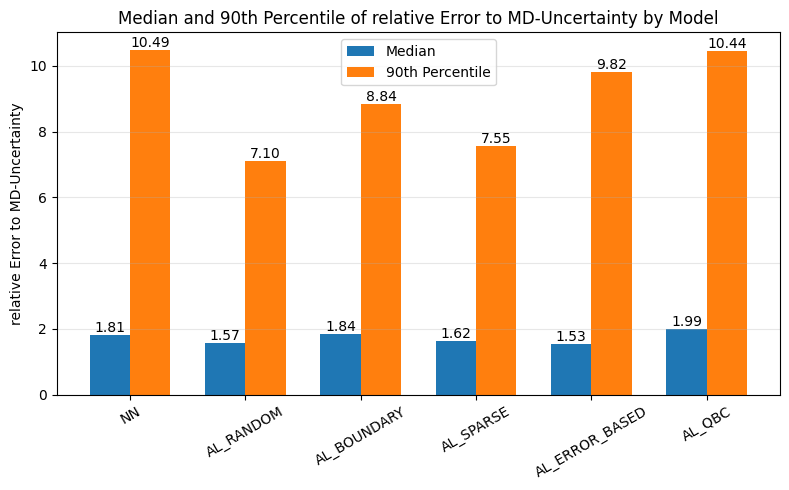

In [ ]:
plot_r_i_summary(median_r_i, p_90_r_i)

##### Ergebnis - Modellfehlers im Vergleich zur natürlichen Unsicherheit

- Median: Wie groß sind die Fehler in 50 % der Fälle?

- 90. Perzentil: Wie groß sind die Fehler in den schlechtesten 10 % der Fälle?

| Methode        | Median ( r_i ) | 90th Percentile ( r_i ) |
| -------------- | -------------- | ----------------------- |
| NN             | 1.8066         | 10.4920                 |
| AL_RANDOM      | 1.5687         | **7.0960**              |
| AL_BOUNDARY    | 1.8435         | 8.8445                  |
| AL_SPARSE      | 1.6234         | 7.5467                  |
| AL_ERROR_BASED | **1.5263**     | 9.8238                  |
| AL_QBC         | 1.9942         | 10.4408                 |

Alle Methoden liegen deutlich über dem Wert 1. Der typische Modellfehler ist somit etwa 1.5 bis 2 mal größer als die natürlicher Unsicherheit. Error-based Sampling (Median) und Random sampling (90. Perzentil) schneiden zwar besser ab, sind jedoch weiterhin unzureichend.

Keines der Modelle erreicht im Median die Größenordnung der Simulationsunsicherheit, jedoch zeigen vereinzelte AL-Strategien eine merkliche Verbesserung gegenüber dem klassischen NN. Eine Verbesserung ist jedoch vor allem im 90. Perzentil beobachtbar. Starke Ausreißer werden somit etwas schwächer. Dennoch sind auch hier die Fehler deutlich größer als die Simulationsunsicherheit.


## Abschluss

Die Ergebnisse zeigen, dass die neuronalen Netze das Verhalten der MD-Simulationen gut approximieren können, Active-Learning Strategien die Daten effizienter nutzen und die Modellfehler moderat reduzieren. Eine große Erkenntnis war, dass durch die Nutzung von Active Learning die nötige Datenmenge für das Modellieren reduziert werden konnte. Heißt, die Zeit für die Erzeugung der nötigen Daten kann um fast die Hälfte reduziert werden.

Allerdings liegen selbst die besten Modelle noch deutlich über der natürlichen Unsicherheit der Simulation (Median von 1.5 bis 2 fache Fehlergröße).

Die Modelle können MD-Simulationen daher nur teilweise ersetzen, insbesondere für schnelle Vorhersagen, erreichen aber nicht die volle Genauigkeit der Simulationen. Sie sind also eher effiziente Approximationen als exakte Ersatzmodelle. Sie eignen sich jeodch besonders, um einen Parameterraum einzugrenzen, um in diesem Simulationen zu starten. Diese Arbeitsweise kann die Simulationskosten ebenfalls erheblich senken.

## Ausblick

Zukünftige Verbesserungen können durch komplexere Netzwerkarchitekturen, hybride Active-Learning Strategien und die Integration physikalischer Restiktionen erreicht werden, um Fehler weiter zu minimieren und näher an die Simulationsunsicherheit zu gelangen.

# Extra

### Vergleich: Relativer Fehler des ML-Modells und der Simulation

**Ziel**

Messen, wie groß der typische Fehler des ML-Modells bzw. der MD Simulation relativ zur Dichte ist.

---

Für jeden Testpunkt $i$:

1. Relativer MAE:

$$
\text{relMAE}_{\text{ML/MD}} = \frac{1}{N} \sum_{i}^{N} ​\left| \frac{\hat{y}_i - y_i}{y_i} \right|
$$

2. Relativer RMSE:

$$
\text{relRMSE}_{\text{ML/MD}} = \sqrt{\frac{1}{N} \sum_{i}^{N} ​\left( \frac{\hat{y}_i - y_i}{y_i} \right)^2}
$$

#### Functions

In [ ]:
def compute_relative_mae_rmse(
    model,
    X_test,
    y_test,
    feature_scaler=None,
    target_scaler=None,
    device=DEVICE
):
    """
    Berechnet den relativen MAE und relativen RMSE für ein Modell auf dem Test-Set.

    Parameters
    ----------
    model : torch.nn.Module
        Trainiertes Modell.
    X_test : np.ndarray oder torch.Tensor
        Test-Features (unskaliert).
    y_test : np.ndarray oder torch.Tensor
        Test-Targets (unskaliert).
    feature_scaler : sklearn Scaler oder None
        Skaler für die Features.
    target_scaler : sklearn Scaler oder None
        Skaler für das Target (für inverse Transformation).
    device : torch.device
        Device für das Modell.

    Returns
    -------
    rel_mae : float
        Relativer MAE.
    rel_rmse : float
        Relativer RMSE.
    """
    model.eval()
    # Features skalieren
    if feature_scaler is not None:
        X_test_proc = feature_scaler.transform(X_test)
    else:
        X_test_proc = X_test
    # Zu Tensor konvertieren
    if not isinstance(X_test_proc, torch.Tensor):
        X_test_t = torch.tensor(X_test_proc, dtype=torch.float32).to(device)
    else:
        X_test_t = X_test_proc.to(device)
    with torch.no_grad():
        preds = model(X_test_t).cpu().numpy().reshape(-1, 1)
    # Targets zu numpy
    if isinstance(y_test, torch.Tensor):
        actuals = y_test.cpu().numpy().reshape(-1, 1)
    else:
        actuals = np.array(y_test).reshape(-1, 1)
    # Inverse transform predictions falls nötig
    if target_scaler is not None:
        preds = target_scaler.inverse_transform(preds).ravel()
    else:
        preds = preds.ravel()
    actuals = actuals.ravel()
    # Relativer Fehler
    rel_errors = np.abs(preds - actuals) / np.abs(actuals)
    rel_mae = np.mean(rel_errors)
    rel_rmse = np.sqrt(np.mean((preds - actuals) ** 2 / (actuals ** 2)))
    return rel_mae, rel_rmse

In [ ]:
def compute_relative_mae_rmse_for_md(y_test, estim_err):
    """
    Berechnet den relativen MAE und relativen RMSE für die MD-Simulation (estimErr) relativ zu y_test.

    Parameters
    ----------
    y_test : np.ndarray
        Wahre Zielwerte (z.B. Dichte) im Testset.
    estim_err : np.ndarray
        MD-Schwankungen (gleiche Reihenfolge wie y_test).

    Returns
    -------
    rel_mae_md : float
        Relativer MAE der MD-Simulation.
    rel_rmse_md : float
        Relativer RMSE der MD-Simulation.
    """
    y_test = np.asarray(y_test).ravel()
    estim_err = np.asarray(estim_err).ravel()
    # Relativer Fehler: estimErr / |y_test|
    rel_errors = np.abs(estim_err) / np.abs(y_test)
    rel_mae_md = np.mean(rel_errors)
    rel_rmse_md = np.sqrt(np.mean((estim_err / y_test) ** 2))
    return rel_mae_md, rel_rmse_md

In [ ]:
def compute_distance_to_md(results, md_mae, md_rmse):
    """
    Berechnet für jedes Modell im results-Dictionary den Abstand (Differenz) zum Wert der MD-Simulation.

    Parameters
    ----------
    results : dict
        Format: {model_name: {'rel_mae': float, 'rel_rmse': float}, ...}
    md_mae : float
        Relativer MAE der MD-Simulation.
    md_rmse : float
        Relativer RMSE der MD-Simulation.

    Returns
    -------
    distances : dict
        Format: {model_name: {'mae_dist': float, 'rmse_dist': float}, ...}
    """
    distances = {}
    for model, vals in results.items():
        mae_dist = vals['rel_mae'] - md_mae
        rmse_dist = vals['rel_rmse'] - md_rmse
        distances[model] = {'mae_dist': mae_dist, 'rmse_dist': rmse_dist}
    return distances

In [ ]:
def plot_relative_mae_rmse_comparison(
    models_info,
    X_test,
    y_test,
    estim_err,
    device=DEVICE,
    md_label="MD Simulation",
    figsize=(7, 5),
    percentage_format=False,
    title="Relativer MAE und RMSE: ML-Modelle vs. MD-Simulation"
):
    """
    Plots relative MAE and RMSE for a list of models and the MD simulation, with value annotations.

    Parameters
    ----------
    models_info : list of dict
        Each dict must have keys:
            - 'name': str, model name/label
            - 'model': torch.nn.Module, trained model
            - 'feature_scaler': sklearn scaler or None
            - 'target_scaler': sklearn scaler or None
    X_test : np.ndarray
        Test features (unscaled).
    y_test : np.ndarray
        Test targets (unscaled).
    estim_err : np.ndarray
        MD error estimates (same order as y_test).
    device : torch.device
        Device for model evaluation.
    md_label : str
        Label for the MD simulation bar.
    figsize : tuple
        Figure size for the plot.
    percentage_format : bool
        If True, formats y-axis as percentage.
    """
    rel_maes = []
    rel_rmses = []
    labels = []

    # ML models
    for info in models_info:
        rel_mae, rel_rmse = compute_relative_mae_rmse(
            info['model'],
            X_test,
            y_test,
            feature_scaler=info.get('feature_scaler'),
            target_scaler=info.get('target_scaler'),
            device=device
        )
        rel_maes.append(rel_mae)
        rel_rmses.append(rel_rmse)
        labels.append(info['name'])

    # MD simulation
    rel_mae_md, rel_rmse_md = compute_relative_mae_rmse_for_md(y_test, estim_err)
    rel_maes.append(rel_mae_md)
    rel_rmses.append(rel_rmse_md)
    labels.append(md_label)

    # Convert to percent if requested
    if percentage_format:
        rel_maes = [v * 100 for v in rel_maes]
        rel_rmses = [v * 100 for v in rel_rmses]
        ylabel = "Relativer Fehler [%]"
        value_fmt = "{:.2f}%"
    else:
        ylabel = "Relativer Fehler"
        value_fmt = "{:.3f}"

    # Plot
    x = np.arange(len(labels))
    width = 0.35

    plt.figure(figsize=figsize)
    bars1 = plt.bar(x - width/2, rel_maes, width, label='relMAE')
    bars2 = plt.bar(x + width/2, rel_rmses, width, label='relRMSE')
    plt.xticks(x, labels, rotation=30)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.tight_layout()

    # Annotate values
    for bar, value in zip(bars1, rel_maes):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), value_fmt.format(value),
                 ha='center', va='bottom', fontsize=10)
    for bar, value in zip(bars2, rel_rmses):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), value_fmt.format(value),
                 ha='center', va='bottom', fontsize=10)

    plt.show()

#### Evaluation

In [ ]:
results = {}
for info in model_info_values:
    rel_mae, rel_rmse = compute_relative_mae_rmse(
        model=info['model'],
        X_test=X_test,
        y_test=y_test,
        feature_scaler=info['feature_scaler'],
        target_scaler=info['target_scaler'],
        device=DEVICE
    )
    results[info['name']] = {'rel_mae': rel_mae, 'rel_rmse': rel_rmse}

results

{'NN': {'rel_mae': np.float64(0.01556120445830137),
  'rel_rmse': np.float64(0.061592652616604265)},
 'AL_RANDOM': {'rel_mae': np.float64(0.01543708091857465),
  'rel_rmse': np.float64(0.061236007396774914)},
 'AL_BOUNDARY': {'rel_mae': np.float64(0.01505439811557757),
  'rel_rmse': np.float64(0.05725163273348902)},
 'AL_SPARSE': {'rel_mae': np.float64(0.014169890379614936),
  'rel_rmse': np.float64(0.05507523800252341)},
 'AL_ERROR_BASED': {'rel_mae': np.float64(0.015627119258844864),
  'rel_rmse': np.float64(0.07173460337697463)},
 'AL_QBC': {'rel_mae': np.float64(0.014602793041834794),
  'rel_rmse': np.float64(0.053963760264232455)}}

In [ ]:
rel_mae_md, rel_rmse_md = compute_relative_mae_rmse_for_md(y_test, estim_err_test)
rel_mae_md, rel_rmse_md

(np.float64(0.009955589745499748), np.float64(0.024377178144290863))

In [ ]:
compute_distance_to_md(results, rel_mae_md, rel_rmse_md)

{'NN': {'mae_dist': np.float64(0.005605614712801622),
  'rmse_dist': np.float64(0.0372154744723134)},
 'AL_RANDOM': {'mae_dist': np.float64(0.005481491173074901),
  'rmse_dist': np.float64(0.03685882925248405)},
 'AL_BOUNDARY': {'mae_dist': np.float64(0.005098808370077822),
  'rmse_dist': np.float64(0.03287445458919816)},
 'AL_SPARSE': {'mae_dist': np.float64(0.004214300634115188),
  'rmse_dist': np.float64(0.030698059858232547)},
 'AL_ERROR_BASED': {'mae_dist': np.float64(0.005671529513345116),
  'rmse_dist': np.float64(0.04735742523268376)},
 'AL_QBC': {'mae_dist': np.float64(0.004647203296335046),
  'rmse_dist': np.float64(0.02958658211994159)}}

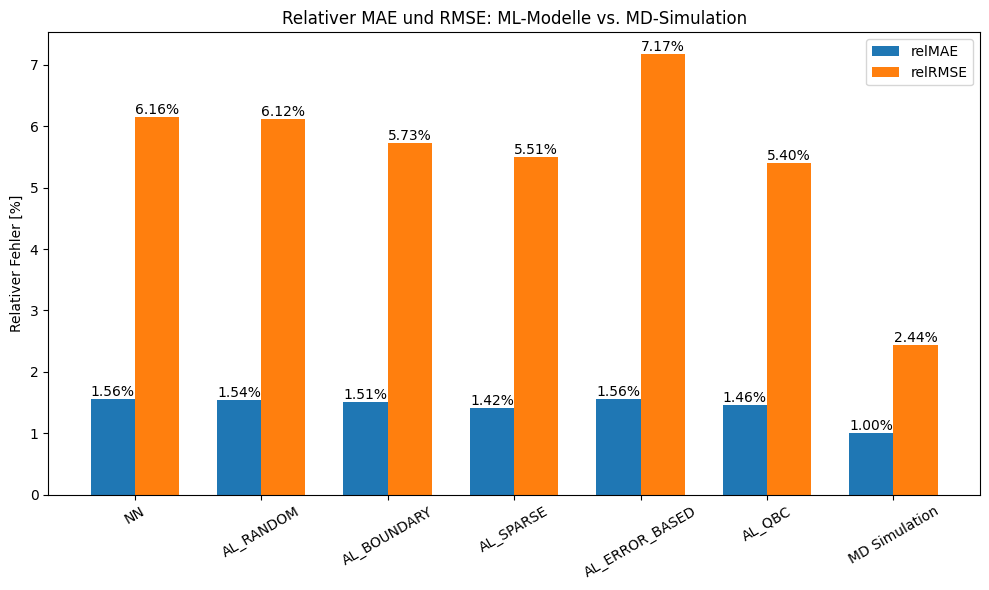

In [ ]:
plot_relative_mae_rmse_comparison(
    model_info_values,
    X_test,
    y_test,
    estim_err_test,
    device=DEVICE,
    md_label="MD Simulation",
    figsize=(10, 6),
    percentage_format=True
)

#### Bewertung


##### **Ziel**

Ziel der Evaluation ist es, die Vorhersagegüte verschiedener ML-Modelle – trainiert mit unterschiedlichen Active-Learning-Strategien – relativ zur intrinsischen Unsicherheit der MD-Simulation (estimErr) zu bewerten.

Die MD-Simulation definiert dabei eine natürliche Genauigkeitsgrenze, da ihre Ergebnisse selbst Schwankungen unterliegen.

---

##### **Referenz: MD-Simulation**

Die MD-Simulation weist folgende relative Fehler auf:

- **relMAE_MD ≈ 1.0 %**

- **relRMSE_MD ≈ 2.4 %**

Diese Werte beschreiben die typische relative Schwankung der simulierten Dichte um ihren Mittelwert.

Ein ML-Modell mit vergleichbarem Fehler wäre somit „so genau wie die Simulation selbst“.

---

##### **Gesamtvergleich der ML-Modelle**

Alle ML-Modelle zeigen höhere relative Fehler als die MD-Simulation.
Die relativen RMSE-Werte der Modelle liegen im Bereich von:

- ≈ 5.4 % bis 7.2 %

Damit überschreiten alle Modelle die intrinsische Unsicherheit der MD-Simulation.

---

##### **Vergleich der Active-Learning-Strategien**

Beste Modelle (niedrigster Fehler)

- AL_QBC

    - relRMSE ≈ 5.40 %

    - geringster Abstand zur MD-Simulation (ΔRMSE ≈ 2.96 %)

- AL_SPARSE

    - relRMSE ≈ 5.51 %

    - zweitkleinster Abstand zur MD-Simulation

Diese beiden Strategien liefern die präzisesten Modelle und nähern sich der MD-Genauigkeit am stärksten an.

---

##### **Mittleres Leistungsniveau**

- AL_BOUNDARY

    - relRMSE ≈ 5.73 %

- NN (ohne Active Learning)

    - relRMSE ≈ 6.16 %

- AL_RANDOM

    - relRMSE ≈ 6.12 %

Random Sampling bringt nur eine marginale Verbesserung gegenüber dem klassischen Training.
Boundary Sampling ist spürbar besser, aber nicht optimal.

---

##### **Schwächstes Modell**

- AL_ERROR_BASED

    - relRMSE ≈ 7.17 %

    - größter Abstand zur MD-Simulation

Error-based Sampling verschlechtert hier die Modellgüte und ist für dieses Problem nicht geeignet.

Der Grund hierzu liegt darin, dass das Modell bei den gleichen drei Punkten durchgehen die größten Fehler hat und somit immer wieder den gleichen Bereich trainiert. (Siehe k-nearest-Neighbours Analyse)

#### Interpretation im Kontext der MD-Unsicherheit

Der Abstand der ML-Modelle zur MD-Simulation zeigt:

- Kein Modell erreicht die intrinsische Genauigkeit der Simulation

- Einige AL-Strategien (QBC, Sparse) reduzieren den Fehler jedoch deutlich

- Active Learning kann die Effizienz verbessern, aber nicht jede Strategie ist sinnvoll